# Results evaluation


### UTILS

In [1]:
from utils_membership_prob import *

In [2]:
import cmasher as cmr
cmap = cmr.get_sub_cmap('brg', 0, 1)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib widget

## Select device

In [5]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:6 device


## Configuration

In [6]:
dataset = 'CIFAR100'

fine_tuned = True

seed = 29

bs = 64

pretrained = True

model_name = 'vgg16'

dataset_name = dataset

len_train = 40000
len_val = 10000

In [7]:
#dims_list = [10, 15, 20, 25, 30]
dims_list = [10]
dims_list = [40, 50, 60, 70, 100]
# dims_list = [100]

num_clusters = [10, 15, 20, 50, 120, 150]

# num_clusters = [
#                 # 10, 15, 20, 50, 100, 
#                 120, 150,
#                 # 200, 250, 300,
#                 350, 500
# ]

method = 'KM'

layers_dict = {'feat': [24,26,28],
               'clas':[0,3],}

dir = 'in'

layer_list =['feat-24', 'feat-26', 'feat-28', 'clas-0', 'clas-3']

In [8]:
ATK = 'CW'

## Load

### Load data

In [9]:
batch_size = 64
data_kwargs = {'num_workers': 4, 'pin_memory': True}

Get classes and `num_classes`

In [10]:
classes = load_data(dataset, 'classes', batch_size=batch_size, data_kwargs={})
num_classes = len(classes.keys())

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_loader = load_data(dataset, 
                         'train', 
                         batch_size=batch_size, 
                         data_kwargs=data_kwargs
                        )

Files already downloaded and verified
Files already downloaded and verified


In [13]:
val_loader = load_data(dataset, 
                       'val', 
                       batch_size=batch_size, 
                       data_kwargs=data_kwargs
                      )

Files already downloaded and verified
Files already downloaded and verified


In [13]:
test_loader = load_data(dataset, 
                       'test', 
                       batch_size=batch_size, 
                       data_kwargs=data_kwargs
                      )

Files already downloaded and verified
Files already downloaded and verified


### Load checkpoint
Load checkpoint from a pretrained and fine-tuned model

In [11]:
model_name = f'vgg16_pretrained={pretrained}_dataset={dataset}-'\
             f'augmented_policy=CIFAR10_bs={bs}_seed={seed}.pth'

In [12]:
abs_models_dir = os.path.join('/srv/newpenny/XAI/LM', 'models')
chkp_path = os.path.join(abs_models_dir, model_name)

if os.path.exists(chkp_path):
    chkp = torch.load(chkp_path, map_location='cpu')
    state_dict = chkp['state_dict']

In [13]:
# see what is saved in the checkpoint (except for the state_dict)
for k, v in chkp.items():
    if k != 'state_dict':
        print(k, v)

train_loss 1.4151224618911744
val_loss 0.8791644280883157
train_accuracy 62.295
val_accuracy 74.96000000000001
epoch 59
batch_size 64
lr 0.001


### Load Activation

In [11]:
dict_activations_train = load_activations(activations_path, portion='train', dataset=dataset_name)

In [12]:
dict_activations_val = load_activations(activations_path, portion='val', dataset=dataset_name)

In [10]:
name = f'dict_activations_attack={ATK}-dataset={dataset_name}.pkl'
dict_activations_attack = load_res_c(name)

NameError: name 'ATK' is not defined

### Load SVD

In [13]:
## configuration

layers_dict = {'clas': [0,3],
              'feat':[24,26,28],
              }

fine_tuned = True

if fine_tuned and (dataset_name=='CIFAR10' or dataset_name=='CIFAR100'):
    seed = 29
else:
    seed = 'nd'

layers = ''

for key in layers_dict.keys():
    for index in layers_dict[key]:
        layer = key + '_' + str(index) + '&'
        layers += layer

dict_file = f'dict_SVD_model={model_name}_layer={layers}_'\
               f'ft={fine_tuned}_seed={seed}_dataset={dataset_name}_.pkl'      

dict_file

'dict_SVD_model=vgg16_layer=clas_0&clas_3&feat_24&feat_26&feat_28&_ft=True_seed=29_dataset=CIFAR100_.pkl'

In [14]:
path = os.path.join('data', 'SVD', dict_file)
with open(path, mode='rb') as fp:
    dict_SVD = pickle.load(fp)

In [15]:
dict_SVD.keys()

dict_keys(['clas-0', 'clas-3', 'feat-28', 'feat-26', 'feat-24'])

### Load model

In [14]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

Modify output shape depending on `num_classes`

In [15]:
in_features = 4096
num_classes = 100
out_features = num_classes 
model.classifier[-1] = nn.Linear(in_features, out_features)

In [16]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
model = model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Load attack dataset

In [18]:
path_ = os.path.join('data', 'attack')
with open(os.path.join(path_, f'adv_dict_train_method={ATK}.pkl'), 'rb') as fp:
    adv_dict = pickle.load(fp)

In [19]:
dataset_ = DictDataset(adv_dict)
 
attack_loader = torch.utils.data.DataLoader(dataset_, 
                                            batch_size=64, 
                                            shuffle=False)

In [30]:
dict_activations_train = load_activations(activations_path, portion='train', dataset=dataset_name)

In [33]:
dict_activations_val = load_activations(activations_path, portion='val', dataset=dataset_name)

### Load Cycles with EP

#### Train & Val

In [ ]:
dict_peephole_train_ = []
dict_peephole_val_ = []
empirical_posterior_ = []
distances_prob_train_ = []
distances_prob_val_ = []
clustering_labels_train_ = []
clustering_labels_val_ = []

for dim in dims_list:
    
    name = f'_dict_peephole_train-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    dict_peephole_train_.append(load_res_lc(name))
    name = f'_dict_peephole_val-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    dict_peephole_val_.append(load_res_lc(name))
    name = f'_empirical_posterior-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    empirical_posterior_.append(load_res_lc(name))
    name = f'_distances_prob_train-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    distances_prob_train_.append(load_res_lc(name))
    name = f'_distances_prob_val-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    distances_prob_val_.append(load_res_lc(name))
    name = f'_clustering_labels_train-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    clustering_labels_train_.append(load_res_lc(name))
    name = f'_clustering_labels_val-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    clustering_labels_val_.append(load_res_lc(name))


In [ ]:
dict_peephole_train = {k: v for d in dict_peephole_train_ for k, v in d.items()}
dict_peephole_val = {k: v for d in dict_peephole_val_ for k, v in d.items()}
empirical_posterior = {k: v for d in empirical_posterior_ for k, v in d.items()}
distances_prob_train = {k: v for d in distances_prob_train_ for k, v in d.items()}
distances_prob_val = {k: v for d in distances_prob_val_ for k, v in d.items()}
clustering_labels_train = {k: v for d in clustering_labels_train_ for k, v in d.items()}
clustering_labels_val = {k: v for d in clustering_labels_val_ for k, v in d.items()}

#### Attack

In [11]:
dict_peephole_attack_ = []

distances_prob_attack_ = []

clustering_labels_attack_ = []

for dim in dims_list:

    name = f'_dict_peephole_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    dict_peephole_attack_.append(load_res(name))

    name = f'_distances_prob_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    distances_prob_attack_.append(load_res(name))
    
    name = f'_clustering_labels_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    clustering_labels_attack_.append(load_res(name))

In [12]:
dict_peephole_attack = {k: v for d in dict_peephole_attack_ for k, v in d.items()}
distances_prob_attack = {k: v for d in distances_prob_attack_ for k, v in d.items()} 
clustering_labels_attack = {k: v for d in clustering_labels_attack_ for k, v in d.items()}

### Load Cycles WITHOUT EP

In [9]:
dist_attack_ = []

dist_val_ = []

for dim in dims_list:

    name = f'_distances_attack={ATK}-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    dist_attack_.append(load_res_lm(name))
    
    name = f'_distances_val-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    dist_val_.append(load_res_lm(name))

In [10]:
dist_attack = {k: v for d in dist_attack_ for k, v in d.items()} 
dist_val = {k: v for d in dist_val_ for k, v in d.items()}

In [11]:
dict_dist_val = {}
dict_dist_attack = {}

for dim in dims_list:

    for n in num_clusters:
        
        dict_dist_val[(dim,n)] = { 'feat-24' : dist_val[(dim,n)][-5],
                                   'feat-26' : dist_val[(dim,n)][-4],
                                   'feat-28' : dist_val[(dim,n)][-3],
                                   'clas-0' : dist_val[(dim,n)][-2],
                                   'clas-3' : dist_val[(dim,n)][-1],}
        
        dict_dist_attack[(dim,n)] = { 'feat-24' : dist_attack[(dim,n)][-5],
                                      'feat-26' : dist_attack[(dim,n)][-4],
                                      'feat-28' : dist_attack[(dim,n)][-3],
                                      'clas-0' : dist_attack[(dim,n)][-2],
                                      'clas-3' : dist_attack[(dim,n)][-1],}

## STORE

### Store SVD

In [7]:
## configuration

layers_dict = {'clas': [0,3],
              'feat':[28],}

model_name = 'vgg16'

dataset_name = 'CIFAR100'

fine_tuned = True

if fine_tuned and (dataset_name=='CIFAR10' or dataset_name=='CIFAR100'):
    seed = 29
else:
    seed = 'nd'

layers = ''

for key in layers_dict.keys():
    for index in layers_dict[key]:
        layer = key + '_' + str(index) + '&'
        layers += layer

dict_file = f'dict_SVD_model={model_name}_layer={layers}_'\
               f'ft={fine_tuned}_seed={seed}_dataset={dataset_name}_.pkl'      

dict_file

'dict_SVD_model=vgg16_layer=clas_0&clas_3&feat_28&_ft=True_seed=29_dataset=CIFAR100_.pkl'

In [8]:
path = os.path.join('data', 'SVD', dict_file)
with open(path, 'wb') as fp:
    pickle.dump(dict_SVD, fp)

NameError: name 'dict_SVD' is not defined

### Store peephole

In [208]:
## configuration

layers_dict = {'clas': [0,3],
              'feat': [28]}

model_name = 'vgg16'

dataset_name = 'CIFAR100'

fine_tuned = True

if fine_tuned and (dataset_name=='CIFAR10' or dataset_name=='CIFAR100'):
    seed = 29
else:
    seed = 'nd'

layers = ''

for key in layers_dict.keys():
    for index in layers_dict[key]:
        layer = key + '_' + str(index) + '&'
        layers += layer

portion = 'val'

dim = '50'

clustering = 'KM'

dict_file = f'dict_peephole_dim={dim}_portion={portion}_model={model_name}_layer={layers}_'\
               f'-clustering_{clustering}_ft={fine_tuned}_seed={seed}_dataset={dataset_name}.pkl'      

dict_file

'dict_peephole_dim=50_portion=val_model=vgg16_layer=clas_0&clas_3&feat_28&_-clustering_KM_ft=True_seed=29_dataset=CIFAR100.pkl'

In [209]:
path = os.path.join('data', 'peephole', dict_file)
with open(path, 'wb') as fp:
    pickle.dump(dict_peephole_val_50, fp)

### Store Empirical posterior

In [204]:
## configuration

if fine_tuned and (dataset_name=='CIFAR10' or dataset_name=='CIFAR100'):
    seed = 29
else:
    seed = 'nd'

layers = ''

for key in layers_dict.keys():
    for index in layers_dict[key]:
        layer = key + '_' + str(index) + '&'
        layers += layer

EP_filename = f'empirical_posterior_model={model_name}_layer={layers}_'\
               f'ft={fine_tuned}_dim={dim}_seed={seed}_dataset={dataset_name}_.pkl'      

EP_filename

'empirical_posterior_model=vgg16_layer=clas_0&clas_3&feat_28&_ft=True_dim=50_seed=29_dataset=CIFAR100_.pkl'

In [205]:
path = os.path.join('data', 'empirical_posterior', EP_filename)
with open(path, 'wb') as fp:
    pickle.dump(empirical_posterior_50, fp)

## Computation

### SVD

In [ ]:
dict_SVD = {}

In [24]:
layer_type = 'classifier'

layer_index = '3'

layer_name = layer_type[0:4] + '-' + layer_index

'clas-3'

In [25]:
U, s, Vh = get_svd(params=state_dict, layer_type=layer_type, layer_index=layer_index, input_shape=None, k=None)

In [29]:
dict_SVD[layer_name] = [U, s, Vh]

#### Working with Conv

In [46]:
name_ = f'unrolled_params_layer=features-28_dataset=CIFAR100.npz'
abs_path = '/srv/newpenny/XAI/LM'

path_ = os.path.join(abs_path, 'data', 'peepholes', name_)
path_

'/srv/newpenny/XAI/LM/data/peepholes/unrolled_params_layer=features-28_dataset=CIFAR100.npz'

In [47]:
W_csr_ = scipy.sparse.load_npz(path_)

In [48]:
U, s, Vh = get_svd_sparse(W_csr_, k=100)

### Activations

#### Train

In [24]:
dict_activations_train = get_activation_VGG(model, 
                                            loader=train_loader, 
                                            layers_dict=layers_dict, 
                                            dir=dir, 
                                            device=device)

clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas

#### Val

In [24]:
dict_activations_val = get_activation_VGG(model, 
                                          loader=val_loader, 
                                          layers_dict=layers_dict, 
                                          dir=dir, 
                                          device=device)

clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas-3
clas
clas-0
clas
clas

#### Attack

In [20]:
dict_activations_attack = get_activation_VGG(model, 
                                             loader=attack_loader, 
                                             layers_dict=layers_dict, 
                                             dir=dir, 
                                             device=device)

sono in feat
24
sono in feat
26
[<torch.utils.hooks.RemovableHandle object at 0x7f1bf83c1ff0>, <torch.utils.hooks.RemovableHandle object at 0x7f1bf83c2350>]
sono in feat
28
[<torch.utils.hooks.RemovableHandle object at 0x7f1bf83c1ff0>, <torch.utils.hooks.RemovableHandle object at 0x7f1bf83c2350>, <torch.utils.hooks.RemovableHandle object at 0x7f1bf83c1cf0>]


In [21]:
## configuration

if fine_tuned and (dataset_name=='CIFAR10' or dataset_name=='CIFAR100'):
    seed = 29
else:
    seed = 'nd'

layers = ''
model_name= 'vgg16'

for key in layers_dict.keys():
    for index in layers_dict[key]:
        layer = key + '_' + str(index) + '&'
        layers += layer
activations_attack = f'dict_activations_portion=train_attack_{ATK}_model={model_name}_layer={layers}_'\
                       f'dir={dir}_ft={fine_tuned}_seed={seed}_dataset={dataset_name}_.pkl'      
activations_attack

'dict_activations_portion=train_attack_CW_model=vgg16_layer=feat_24&feat_26&feat_28&clas_0&clas_3&_dir=in_ft=True_seed=29_dataset=CIFAR100_.pkl'

In [22]:
path_ = os.path.join('data', 'dict_activations', activations_attack)
with open(os.path.join(path_), 'wb') as fp:
    pickle.dump(dict_activations_attack,fp)

### Computation Cycle with EP

#### Train & Val

In [16]:
dict_peephole_train = {} 
dict_peephole_val = {} 
empirical_posterior = {} 
distances_prob_train = {}
distances_prob_val = {}
clustering_labels_train = {}
clustering_labels_val = {}  

for dim in tqdm(dims_list):
    
    # 1. get peepholes train 
    n_ = 1
    n_clusters_ref = {}
    
    for key in layer_list:
        n_clusters_ref[key] = n_
    
    dict_peephole_train_ref = get_dict_peephole_train(dim=dim,
                                                      dict_activations_train=dict_activations_train,
                                                      n_clusters=n_clusters_ref,
                                                      dict_SVD=dict_SVD)
    
    # 2. get peepholes val
    dict_peephole_val_ref = get_dict_peephole_val(dim=dim, 
                                                  dict_activations_val=dict_activations_val, 
                                                  dict_peephole_train=dict_peephole_train_ref,
                                                  n_clusters=n_clusters_ref,
                                                  dict_SVD=dict_SVD)
    
    for n in num_clusters:
        
        n_clusters = {}

        for key in layer_list:
            n_clusters[key] = n
        
        # 3. get updated peepholes train 
        dict_peephole_train[(dim, n)] = get_clustering_config(dict_peephole_train=dict_peephole_train_ref,
                                                              n_clusters=n_clusters)

        # 4. get updated peepholes val
        dict_peephole_val[(dim, n)] = {'peephole': dict_peephole_val_ref['peephole'],
                                      'clustering_config': dict_peephole_train[(dim, n)]['clustering_config']}
        
        
        # 5. get empirical posteriors
        empirical_posterior[(dim, n)] = fit_empirical_posteriors(dict_activations_train=dict_activations_train, 
                                                                 dict_peephole_train=dict_peephole_train[(dim, n)], 
                                                                 n_classes=num_classes)
        
        # 6. get membership probability for training set
        distances_prob_train[(dim, n)] = get_distances_prob(dict_peephole_val=None,
                                                            dict_peephole_train=dict_peephole_train[(dim, n)],
                                                            method=method, 
                                                            dim=dim)
        
        # 7. get membership probability for training set
        distances_prob_val[(dim, n)] = get_distances_prob(dict_peephole_val=dict_peephole_val[(dim, n)],
                                                          dict_peephole_train=dict_peephole_train[(dim, n)],
                                                          method=method, 
                                                          dim=dim)
        
        # 8. combine clustering labels train
        clustering_labels_t = []
        distances_prob = distances_prob_train[(dim, n)]
        for element in zip(*distances_prob):
            ll = element
            clustering_labels_t.append(ll)
        clustering_labels_train[(dim, n)] = clustering_labels_t
            
        #9. combine clustering labels val
        clustering_labels_v = []
        distances_prob = distances_prob_val[(dim, n)]
        for element in zip(*distances_prob):
            ll = element
            clustering_labels_v.append(ll)
        clustering_labels_val[(dim, n)] = clustering_labels_v
        
        
    name = f'_dict_peephole_train-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, dict_peephole_train)
    name = f'_dict_peephole_val-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, dict_peephole_val)
    name = f'_empirical_posterior-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, empirical_posterior)
    name = f'_distances_prob_train-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, distances_prob_train)
    name = f'_distances_prob_val-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, distances_prob_val)
    name = f'_clustering_labels_train-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, clustering_labels_train)
    name = f'_clustering_labels_val-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res_lc(name, clustering_labels_val)
    

  0%|                                                     | 0/1 [00:00<?, ?it/s]

fitting empirical posteriors
fitting empirical posteriors
fitting empirical posteriors
fitting empirical posteriors
fitting empirical posteriors
fitting empirical posteriors
fitting empirical posteriors
fitting empirical posteriors


100%|██████████████████████████████████████| 1/1 [59:22:01<00:00, 213721.55s/it]


#### Attack

In [120]:
dict_peephole_attack = {}
distances_prob_attack = {} 
clustering_labels_attack = {} 

for dim in dims_list:
    
    # 1. get peepholes train 
    n_ = 10
    n_clusetrs_ref = {}
    
    for key in layer_list:
        n_clusters_ref[key] = n_
    
    dict_peephole_train_ref = dict_peephole_train[(dim, n_)]
    
    dict_peephole_attack_ref = get_dict_peephole_val(dim=dim, 
                                                     dict_activations_val=dict_activations_attack, 
                                                     dict_peephole_train=dict_peephole_train_ref, # vedere
                                                     n_clusters=n_clusters_ref,
                                                     dict_SVD=dict_SVD)
    
    for n in num_clusters:
        
        dict_peephole_attack[(dim, n)] = {'peephole': dict_peephole_attack_ref['peephole'],
                                          'clustering_config': dict_peephole_train[(dim, n)]['clustering_config']}
        
        
        distances_prob_attack[(dim, n)] = get_distances_prob(dict_peephole_val=dict_peephole_attack[(dim, n)],
                                                             dict_peephole_train=dict_peephole_train[(dim, n)],
                                                             method=method, 
                                                             dim=dim)
        
        clustering_labels_a = []
        distances_prob = distances_prob_attack[(dim, n)]
        for element in zip(*distances_prob):
            ll = element
            clustering_labels_a.append(ll)
        clustering_labels_attack[(dim, n)] = clustering_labels_a
    
    name = f'_dict_peephole_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res(name, dict_peephole_attack)
    name = f'_distances_prob_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res(name, distances_prob_attack)
    name = f'_clustering_labels_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res(name, clustering_labels_attack)

(50, 25089)
(50, 4097)
(50, 25089)
(50, 4097)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(60, 25089)
(60, 4097)
(60, 25089)
(60, 4097)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(70, 25089)
(70, 4097)
(70, 25089)
(70, 4097)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)


### Computation cycle WITHOUT EP

In [40]:
dict_peephole_attack = {}
dist_attack = {}  

for dim in tqdm(dims_list):
    
    # 1. get peepholes train 
    n_ = 10
    n_clusetrs_ref = {}
    
    for key in layer_list:
        n_clusters_ref[key] = n_
    
    dict_peephole_train_ref = dict_peephole_train[(dim, n_)]
    
    dict_peephole_attack_ref = get_dict_peephole_val(dim=dim, 
                                                     dict_activations_val=dict_activations_attack, 
                                                     dict_peephole_train=dict_peephole_train_ref, 
                                                     n_clusters=n_clusters_ref,
                                                     dict_SVD=dict_SVD)
    
    dict_peephole_val_ref = get_dict_peephole_val(dim=dim, 
                                                  dict_activations_val=dict_activations_val, 
                                                  dict_peephole_train=dict_peephole_train_ref, 
                                                  n_clusters=n_clusters_ref,
                                                  dict_SVD=dict_SVD)
    
    for n in tqdm(num_clusters):
        
            
        dict_peephole_attack[(dim, n)] = {'peephole': dict_peephole_attack_ref['peephole'],
                                          'clustering_config': dict_peephole_train[(dim, n)]['clustering_config']}
        
        dist_attack_ = get_distances(dict_peephole_val=dict_peephole_attack[(dim,n)], 
                                     dict_peephole_train=dict_peephole_train[(dim,n)], 
                                     method=method, dim=dim)
        dist_attack[(dim,n)] = dist_attack_

        dict_peephole_val[(dim, n)] = {'peephole': dict_peephole_val_ref['peephole'],
                                       'clustering_config': dict_peephole_train[(dim, n)]['clustering_config']}
        
        dist_val_ = get_distances(dict_peephole_val=dict_peephole_val[(dim,n)], 
                                  dict_peephole_train=dict_peephole_train[(dim,n)], 
                                  method=method, dim=dim)
        dist_val[(dim,n)] = dist_val_
    
    name = f'_dict_peephole_attack={ATK}-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    save_res(name, dict_peephole_attack)
    name = f'_distances_attack={ATK}-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    save_res(name, dist_attack)
    name = f'_dict_peephole_val-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    save_res(name, dict_peephole_val)
    name = f'_distances_val-dim={dim}-method={method}-dataset={dataset_name}.pkl'
    save_res(name, dist_val)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

(10, 100353)
(10, 100353)
(10, 100353)
(10, 25089)
(10, 4097)



 20%|████████▊                                   | 1/5 [03:36<14:26, 216.68s/it]

(15, 100353)
(15, 100353)
(15, 100353)
(15, 25089)
(15, 4097)



 40%|█████████████████▌                          | 2/5 [07:46<11:48, 236.30s/it]

(20, 100353)
(20, 100353)
(20, 100353)
(20, 25089)
(20, 4097)



 60%|██████████████████████████▍                 | 3/5 [19:14<14:44, 442.24s/it]

(25, 100353)
(25, 100353)
(25, 100353)
(25, 25089)
(25, 4097)



 80%|███████████████████████████████████▏        | 4/5 [32:50<09:49, 589.87s/it]

(30, 100353)
(30, 100353)
(30, 100353)
(30, 25089)
(30, 4097)



100%|████████████████████████████████████████████| 5/5 [47:11<00:00, 566.26s/it]


## Analysis of the attacks

In [13]:
# Define the CIFAR-100 classes
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

# Create a dictionary where each key is the numeric class and the value is the class name
class_dict = {i: cifar100_classes[i] for i in range(len(cifar100_classes))}

print(class_dict)

{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 70: 'rose', 

## DEPLETION

In [28]:
results = np.concatenate(dict_activations_val['results'])
tot_true = np.sum(results==True)
tot_false = np.sum(results==False)
tot_true, tot_false

(8762, 1238)

### Empirical Posterior = True

In [31]:
def predict_proba_v(weights=None, empirical_posterior=None, clustering_labels=None, n_classes=None):
    """Returns surrogate model's predicted probabilities.

    Args:
      features: a batch of input data that the baseline model can process.
      activations_dict: Python dict of cached activations created by calling
        self.get_activations.
      weights: a list of weights (need not be normalized), one for each
        activation.
    """
    # Equal weights are used if not provided by the user.
    if weights is None:
        weights = [1.0] * len(activation_names)

    pred = []
    for one_hot_encoding in clustering_labels:
        # print(one_hot_encoding)
        # print(len(one_hot_encoding))
        pred.append(p(example_score=one_hot_encoding[0], 
                      empirical_posterior=empirical_posterior, 
                      weights=weights, n_classes=n_classes))
    return np.array(pred)

In [32]:
def predict_proba_t(weights=None, empirical_posterior=None, clustering_labels=None, n_classes=None):
    """Returns surrogate model's predicted probabilities.

    Args:
      features: a batch of input data that the baseline model can process.
      activations_dict: Python dict of cached activations created by calling
        self.get_activations.
      weights: a list of weights (need not be normalized), one for each
        activation.
    """
    # Equal weights are used if not provided by the user.
    if weights is None:
        weights = [1.0] * len(activation_names)

    pred = []
    for one_hot_encoding in clustering_labels:
        # print(one_hot_encoding)
        # print(len(one_hot_encoding))
        pred.append(p(example_score=one_hot_encoding, 
                      empirical_posterior=empirical_posterior, 
                      weights=weights, n_classes=n_classes))
    return np.array(pred)

#### Based on Max

In [22]:
measure = 'max'

In [36]:
weights_24 = [1, 0, 0, 0, 0]
weights_26 = [0, 1, 0, 0, 0]
weights_28 = [0, 0, 1, 0, 0]
weights_0 = [0, 0, 0, 1, 0]
weights_3 = [0, 0, 0, 0, 1]
weights_unbalanced_1 = [0, 0, 0, 0.2, 0.8]
weights_unbalanced_2 = [0, 0, 0, 0.1, 0.9]
weights_unbalanced_3 = [0.33,0.33,0.33,0,0]


w_dict = {
          # 'feat-24' : weights_24,
          # 'feat-26' : weights_26,
          # 'feat-28' : weights_28,
          'clas-0' : weights_0,
          'clas-3' : weights_3, 
          '0.2-0.8' : weights_unbalanced_1,
          '0.1-0.9' : weights_unbalanced_2,
          # 'features' : weights_unbalanced_3, 
          }

In [24]:
dims_list, num_clusters

([40, 50, 60, 70, 100], [120, 150, 200, 250, 300, 350, 500])

In [25]:
len_dict = len(w_dict.keys())
len_dim = len(dims_list)
array = np.arange(0,100,0.1)

##### Fine

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

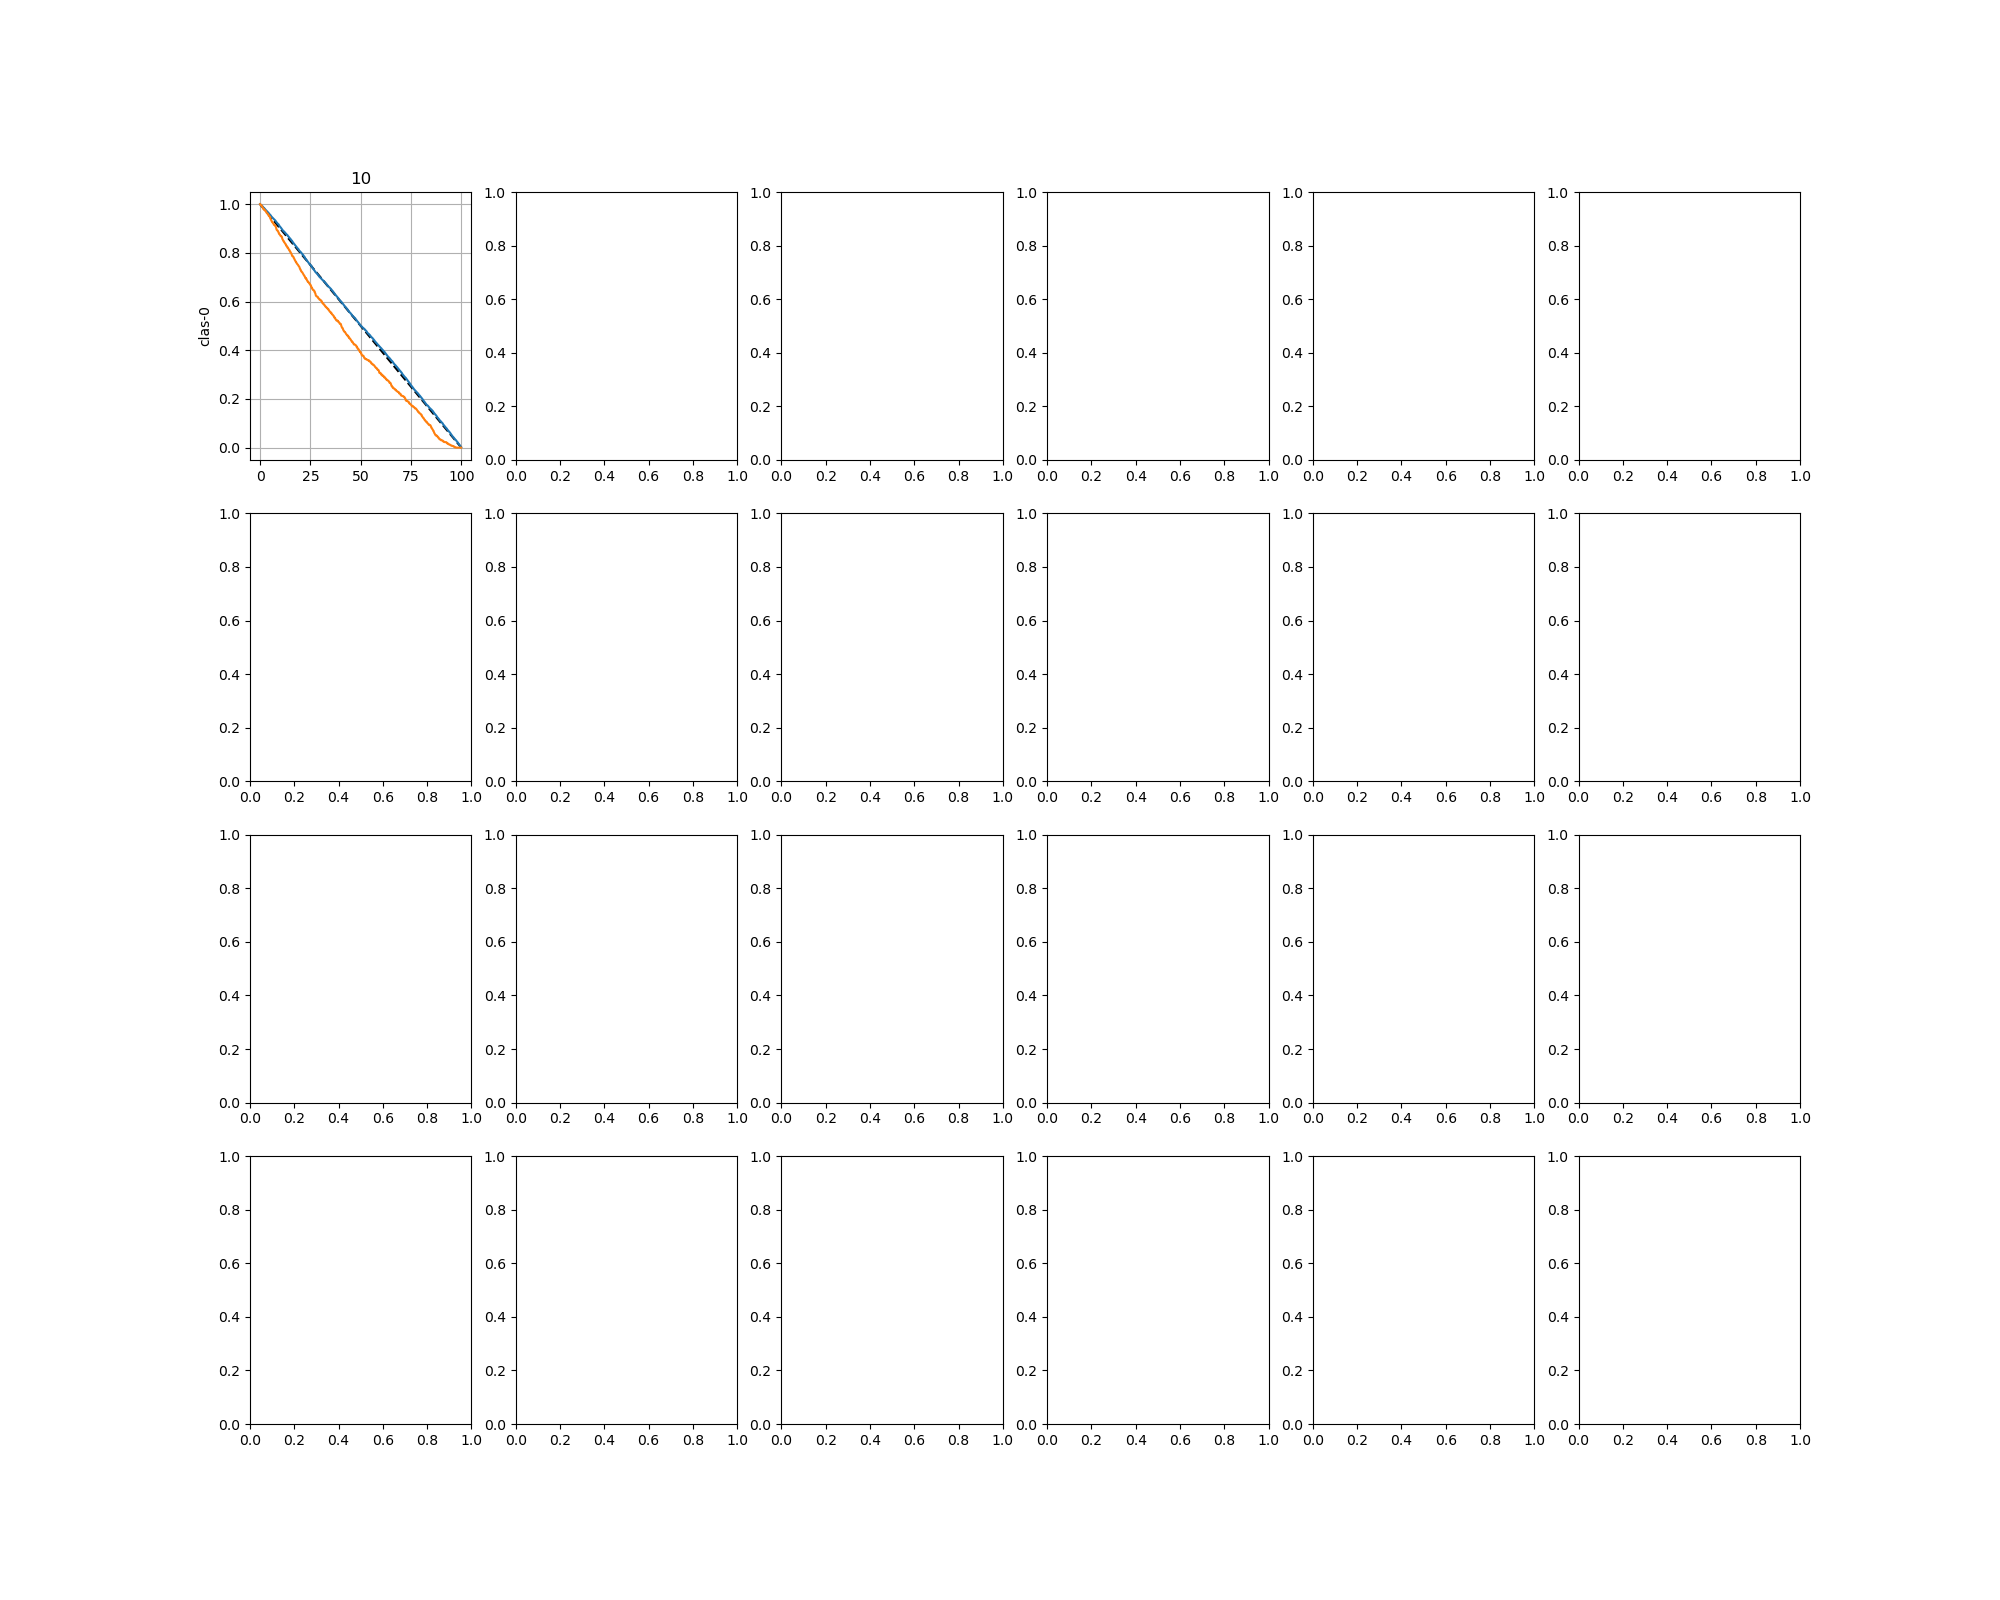

In [35]:
fig, axs = plt.subplots(len_dict,len_dim,figsize=(20,16))

for j, (key, weight) in enumerate(w_dict.items()):

    for k, dim in enumerate(dims_list):
        if j==0:
            axs[j,k].set_title(dim)
        
        axs[j,k].plot([0, 100],[1,0],label='ref', c='k', ls='--')
        
        for n in num_clusters:

            ep = empirical_posterior[(dim,n)]
            cv = clustering_labels_val[(dim,n)]
            ct = clustering_labels_train[(dim,n)]

            prob_train = predict_proba_t(weights=weight, 
                                         empirical_posterior=ep, 
                                         clustering_labels=ct, 
                                         n_classes=100)
            
            prob_val = predict_proba_v(weights=weight, 
                                       empirical_posterior=ep, 
                                       clustering_labels=cv, 
                                       n_classes=100)
            
            conf_t = np.max(prob_train,axis=1)
            conf_v = np.max(prob_val,axis=1)
            
            threshold = []
            list_true_max_ = []
            list_false_max_ = []
            
            for i in array:
            
                perc = np.percentile(conf_t, i)
                
                threshold.append(perc)
                idx = np.argwhere(conf_v>perc)[:,0]
                counter = collections.Counter(results[idx])
                list_true_max_.append(counter[True]/tot_true)
                list_false_max_.append(counter[False]/tot_false)  

            if k==0:
                axs[j,k].set_ylabel(key)

            axs[j,k].plot(array,list_true_max_)
            axs[j,k].plot(array,list_false_max_,label=f'{n}')
            axs[j,k].grid()
            
            # axs[j].set_title(f'weights={formatted_weight}')
            #axs[j,k].title(f'dim={dim} num_clusters={n}', fontsize=16)
            # axs[j].legend()
            
fig.tight_layout()
fig.subplots_adjust(top=0.9)


In [26]:
def save_res(name, file):
    path = os.path.join(abs_lm,'results', 'paper', name)
    with open(path, 'wb') as fp:
        pickle.dump(file, fp)

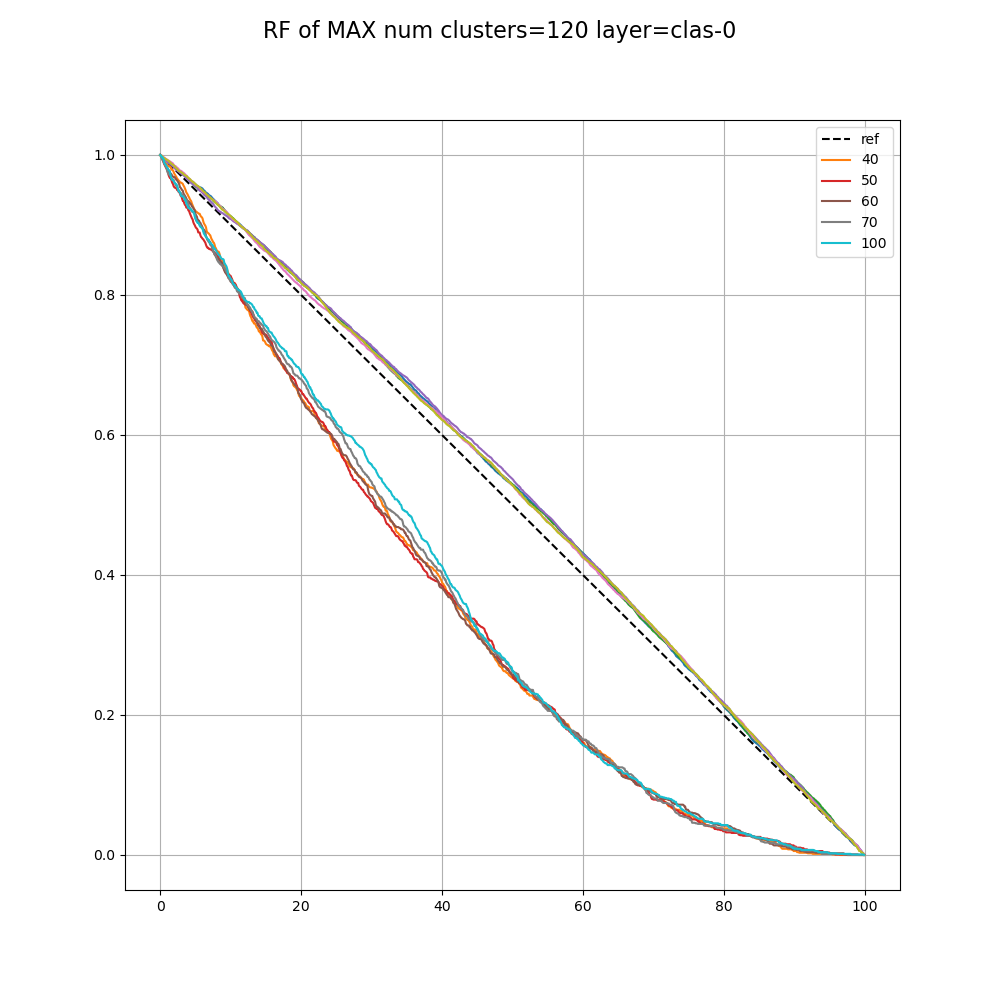

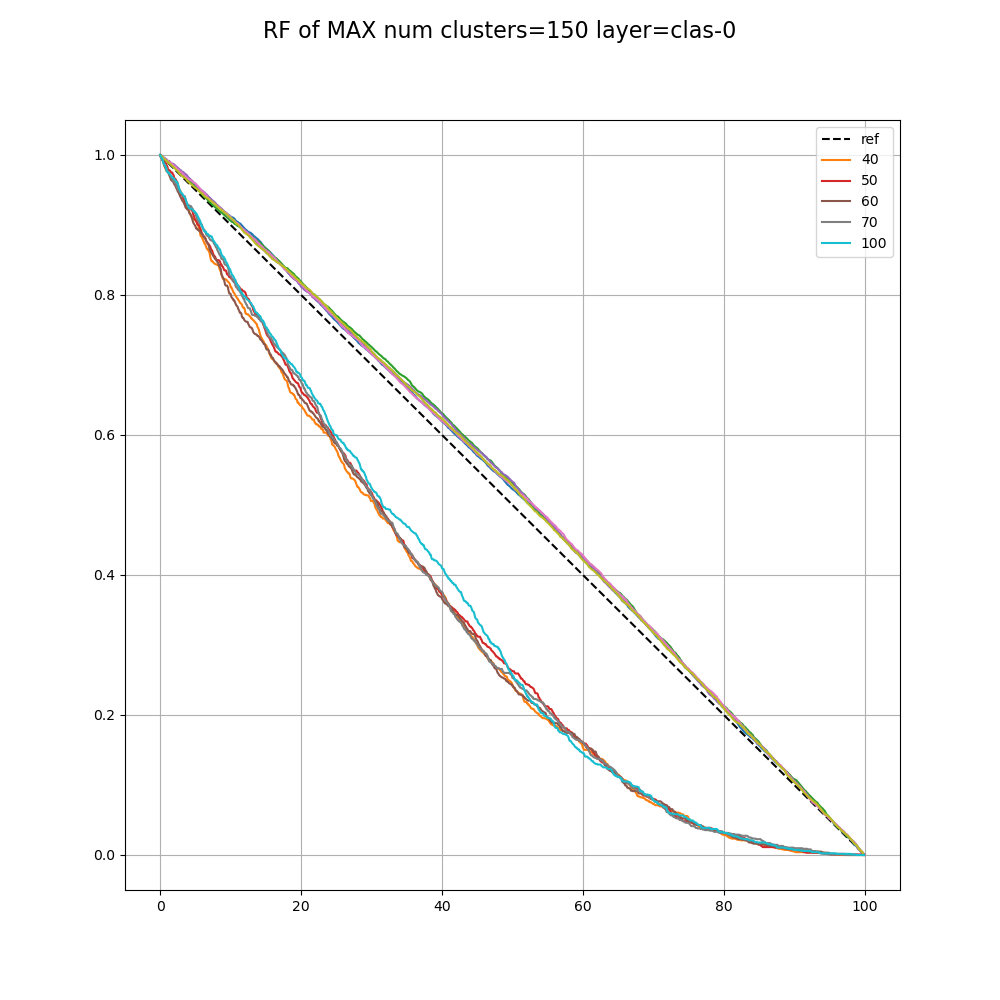

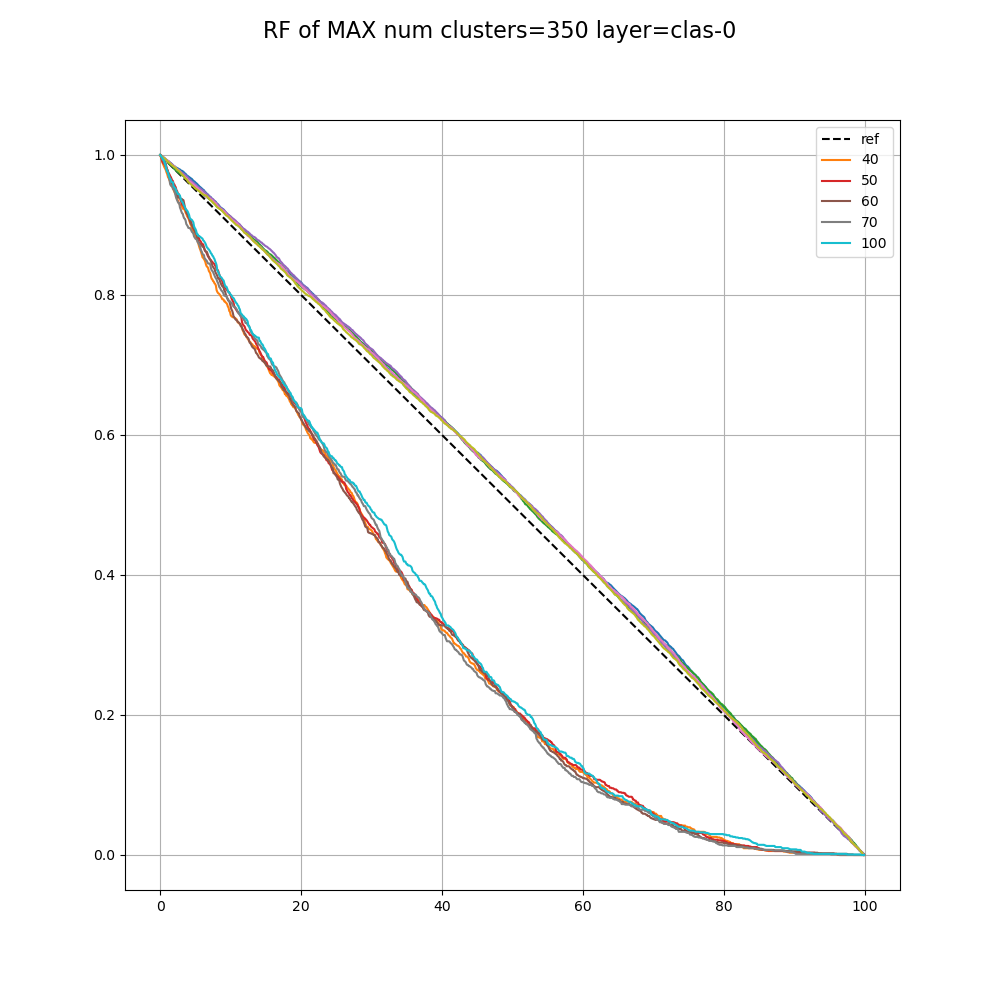

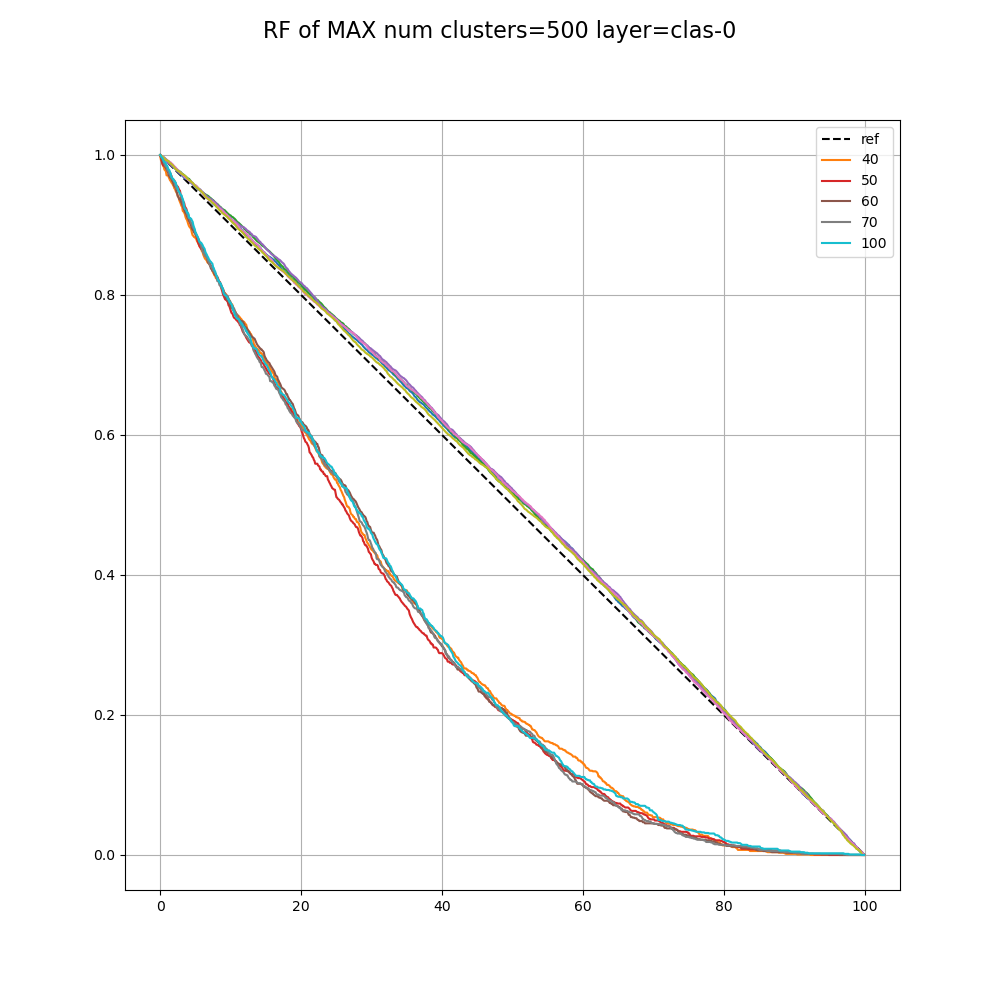

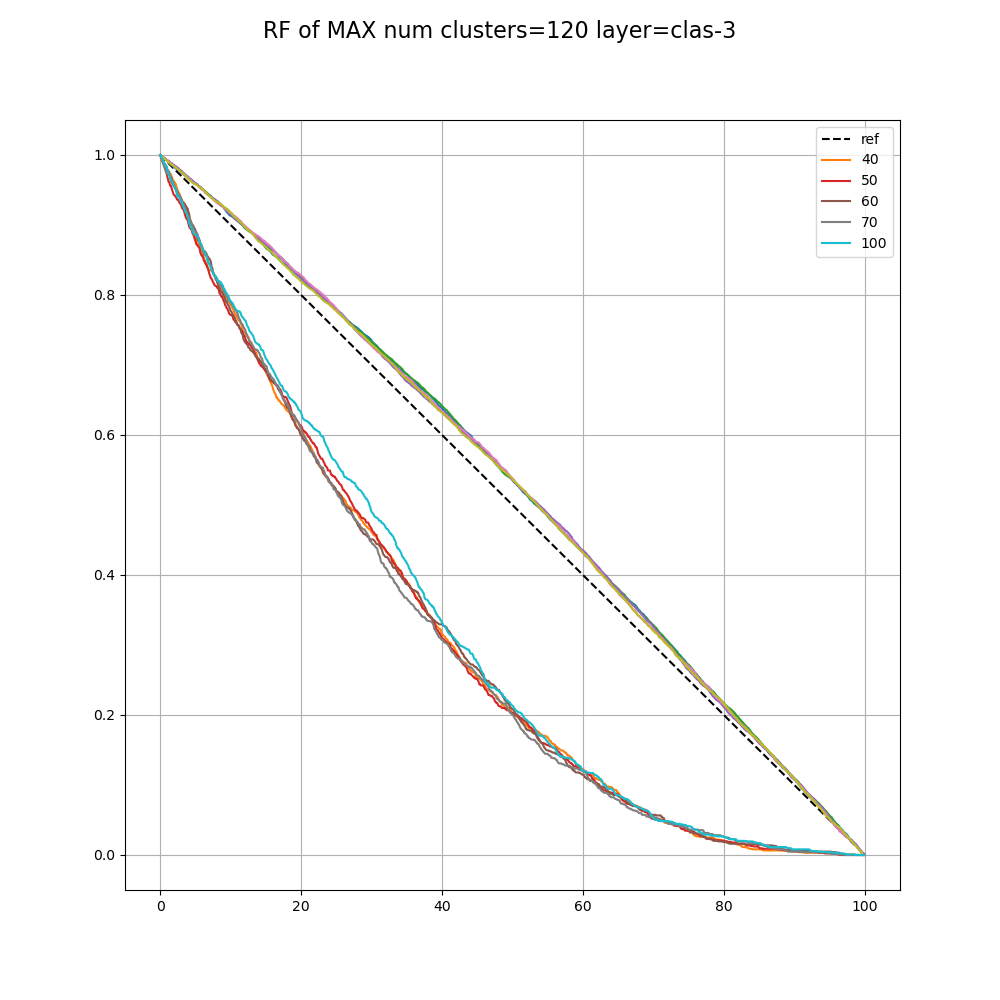

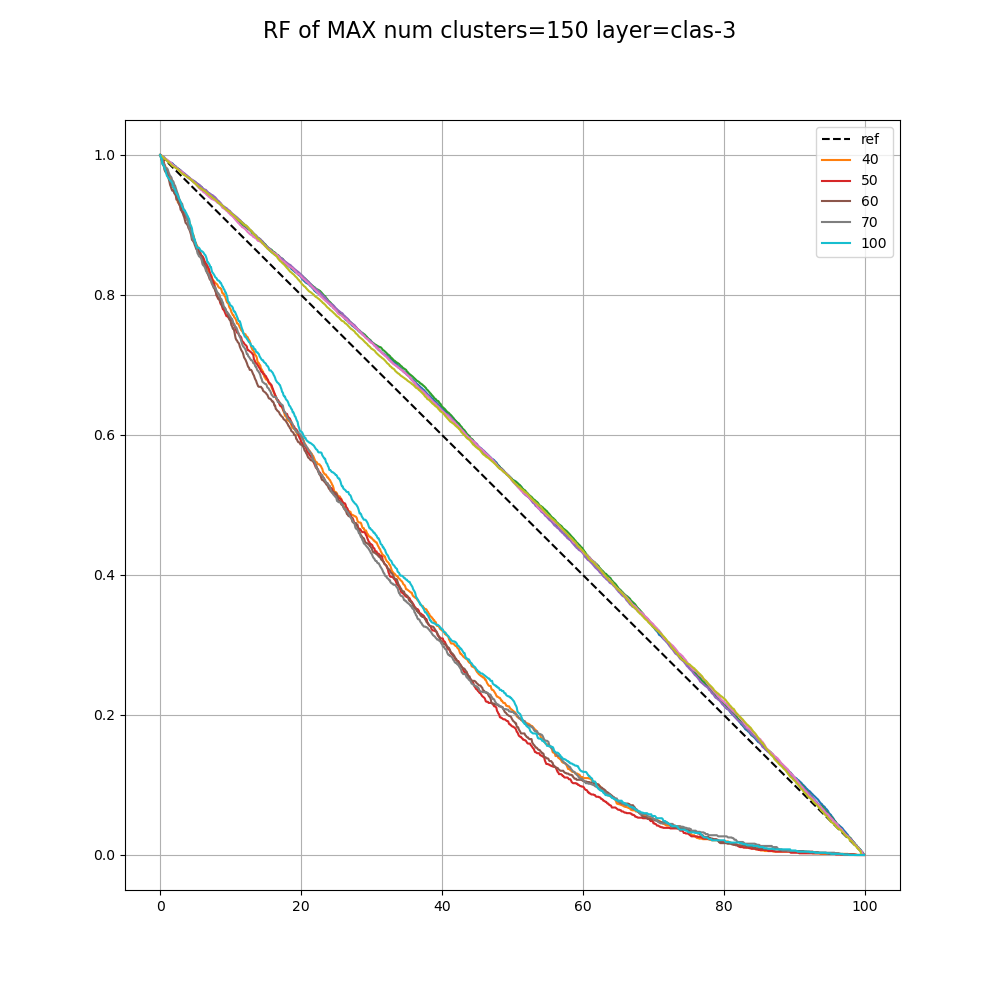

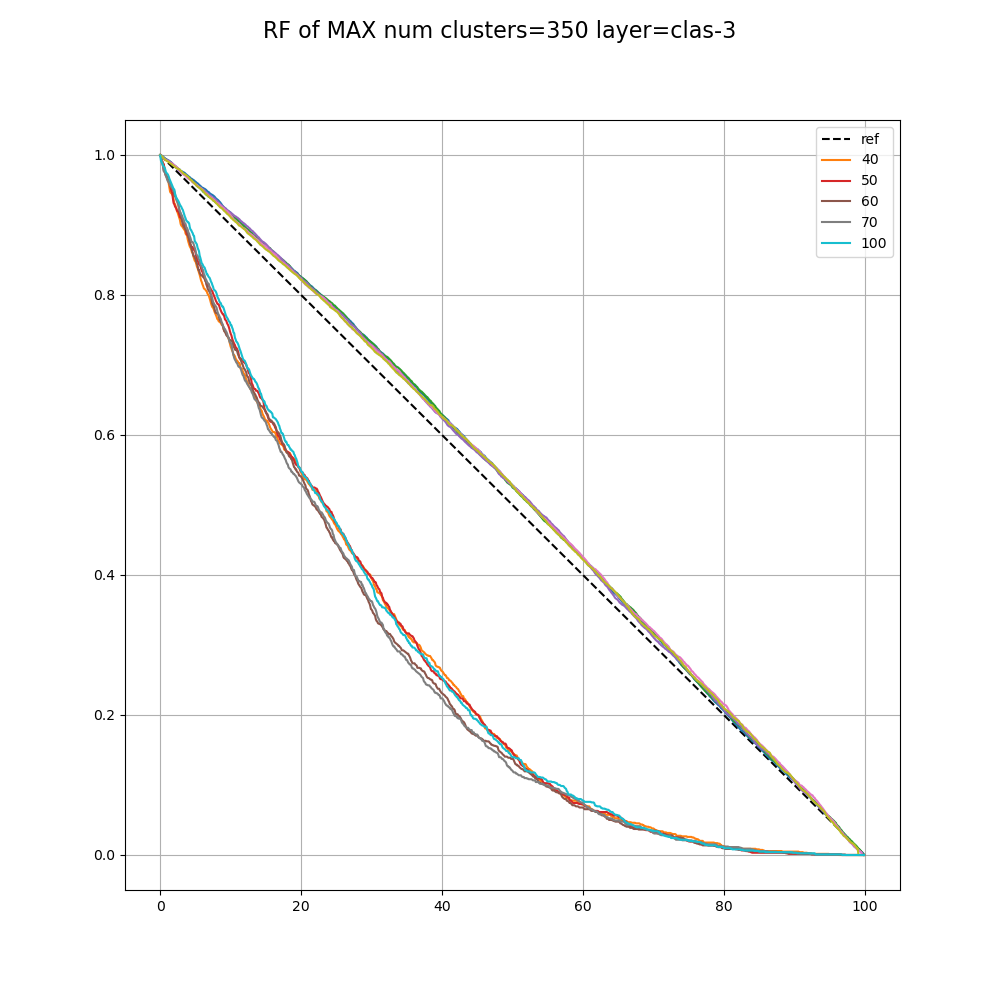

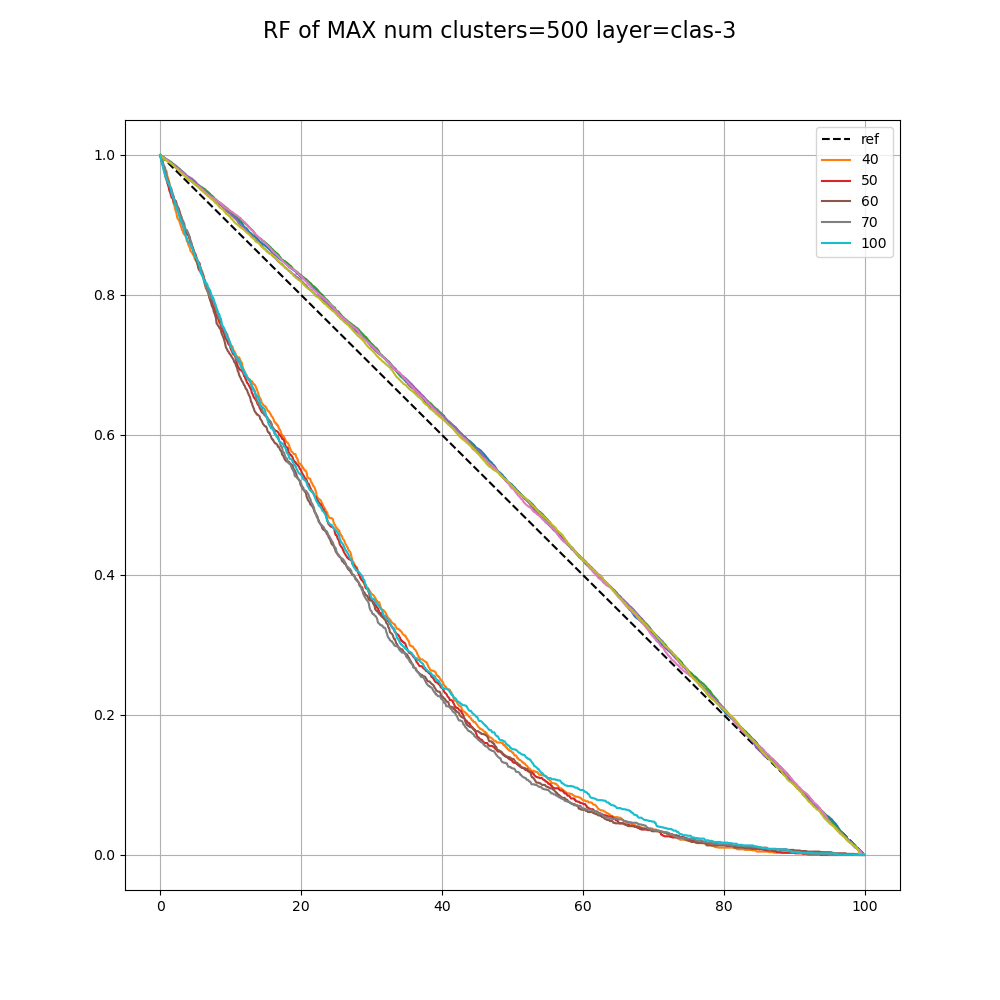

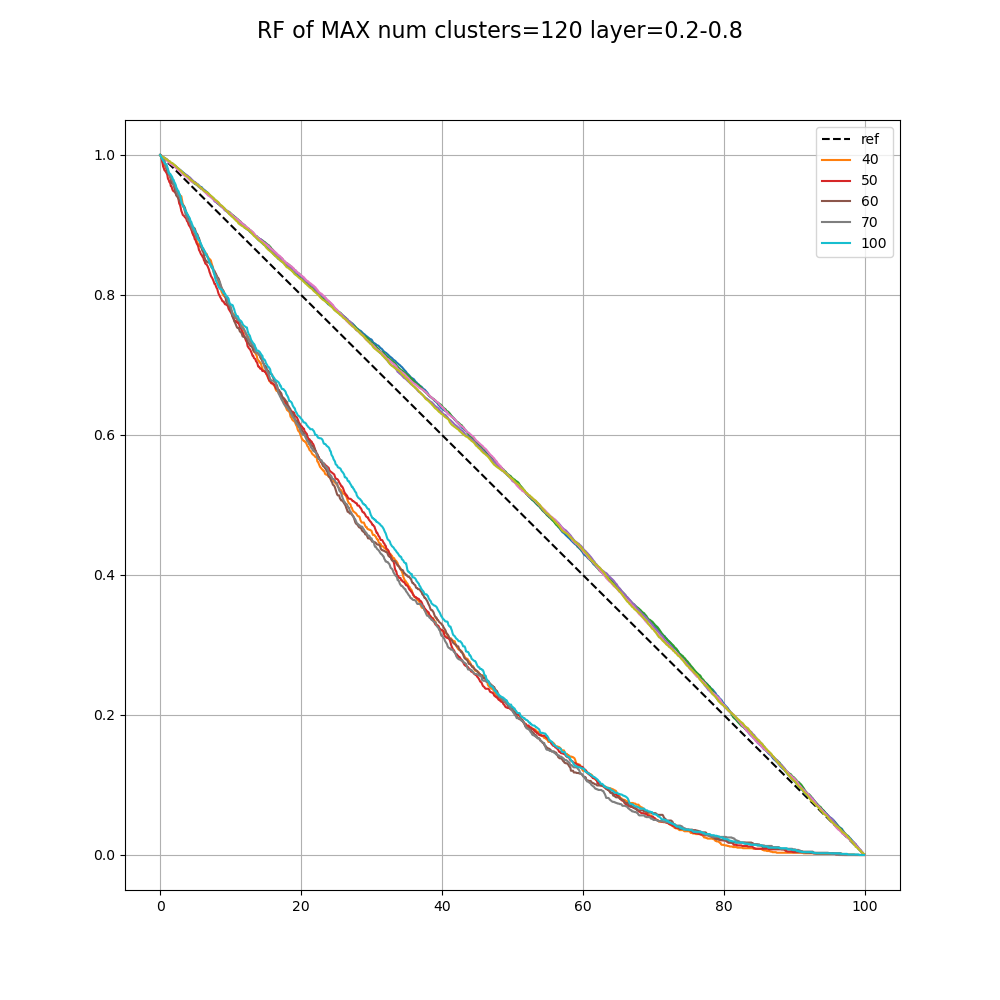

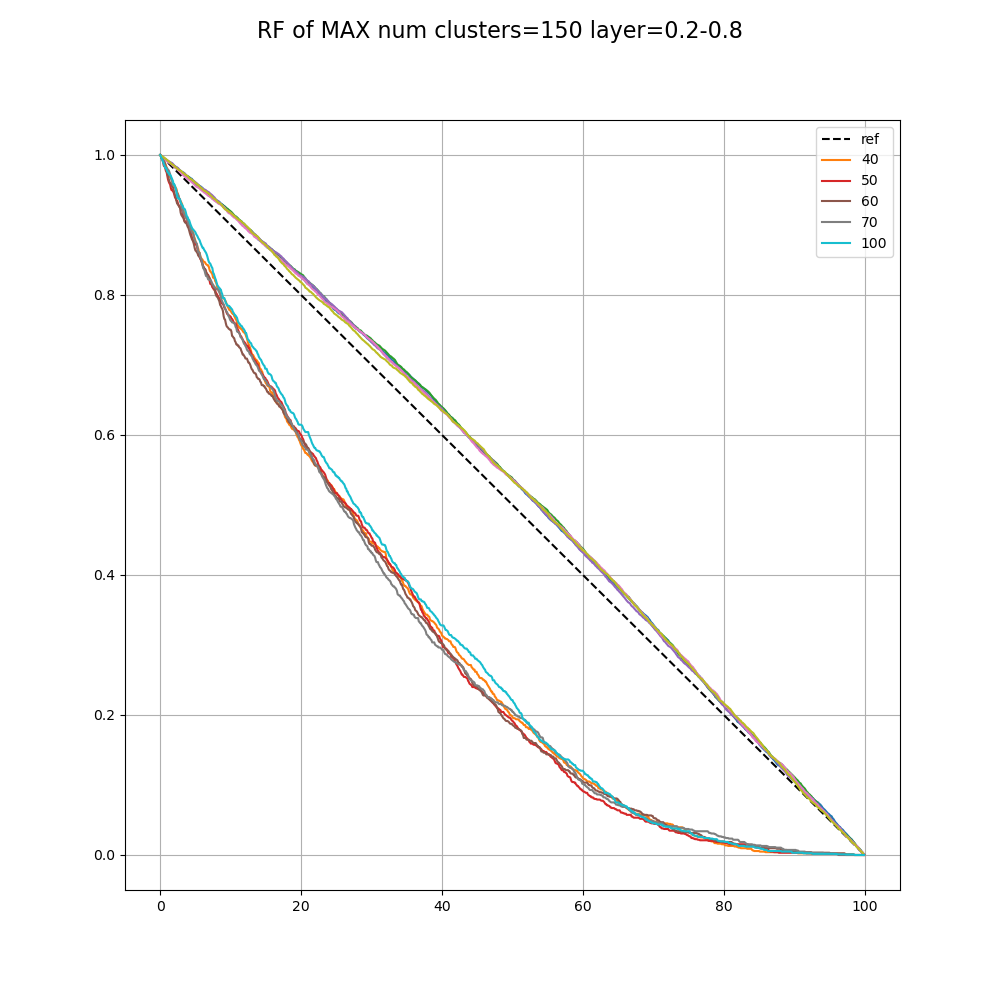

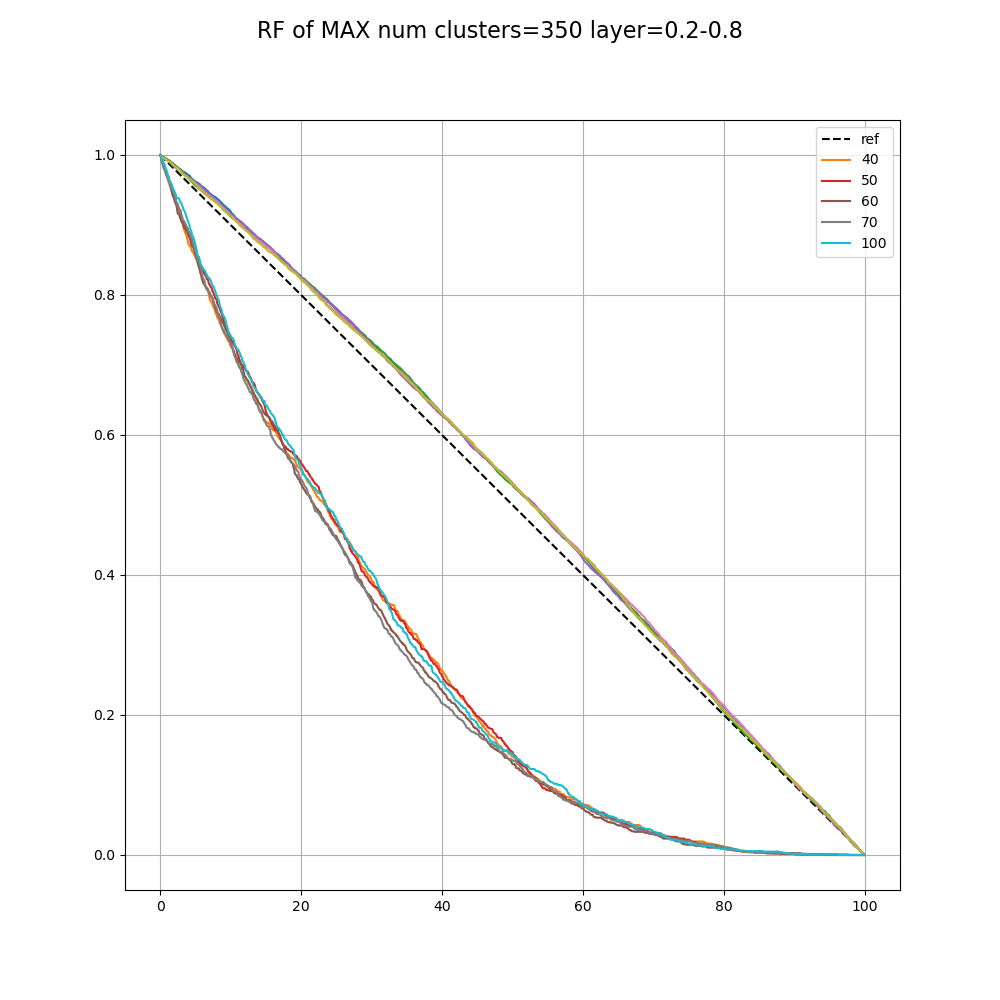

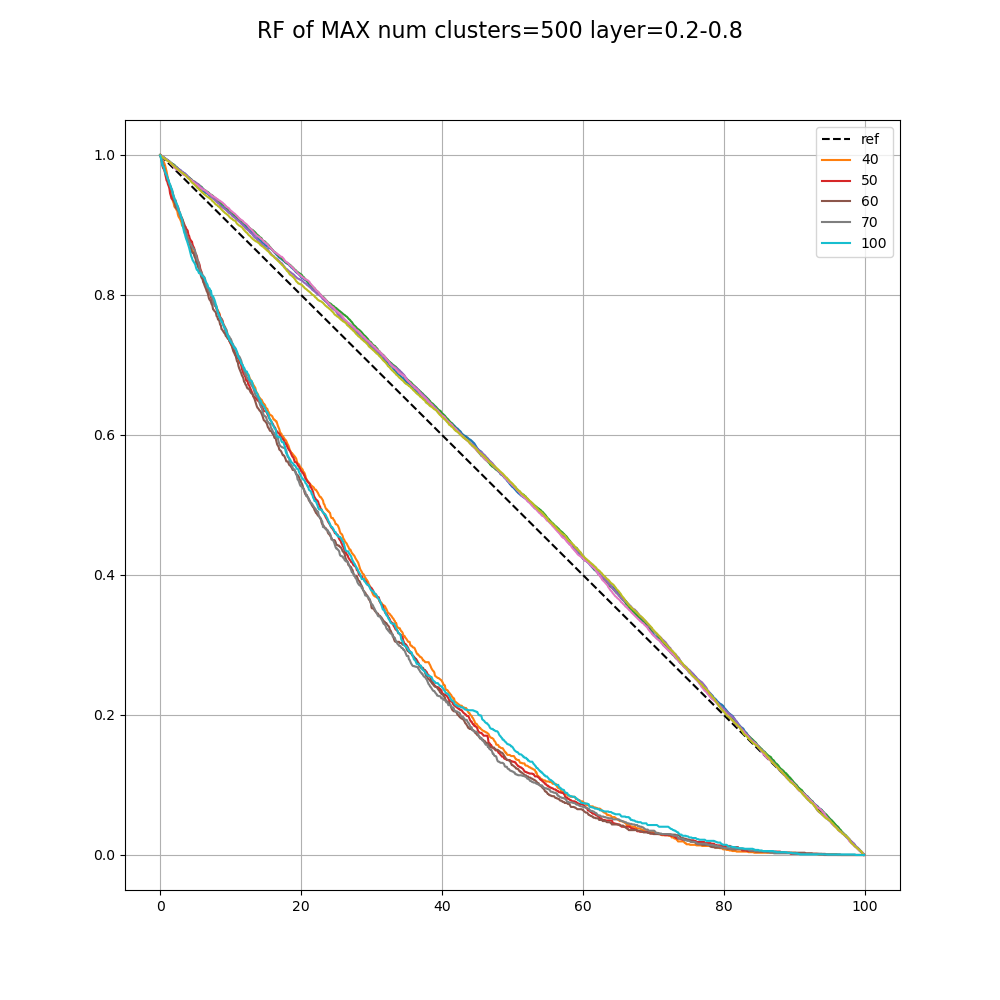

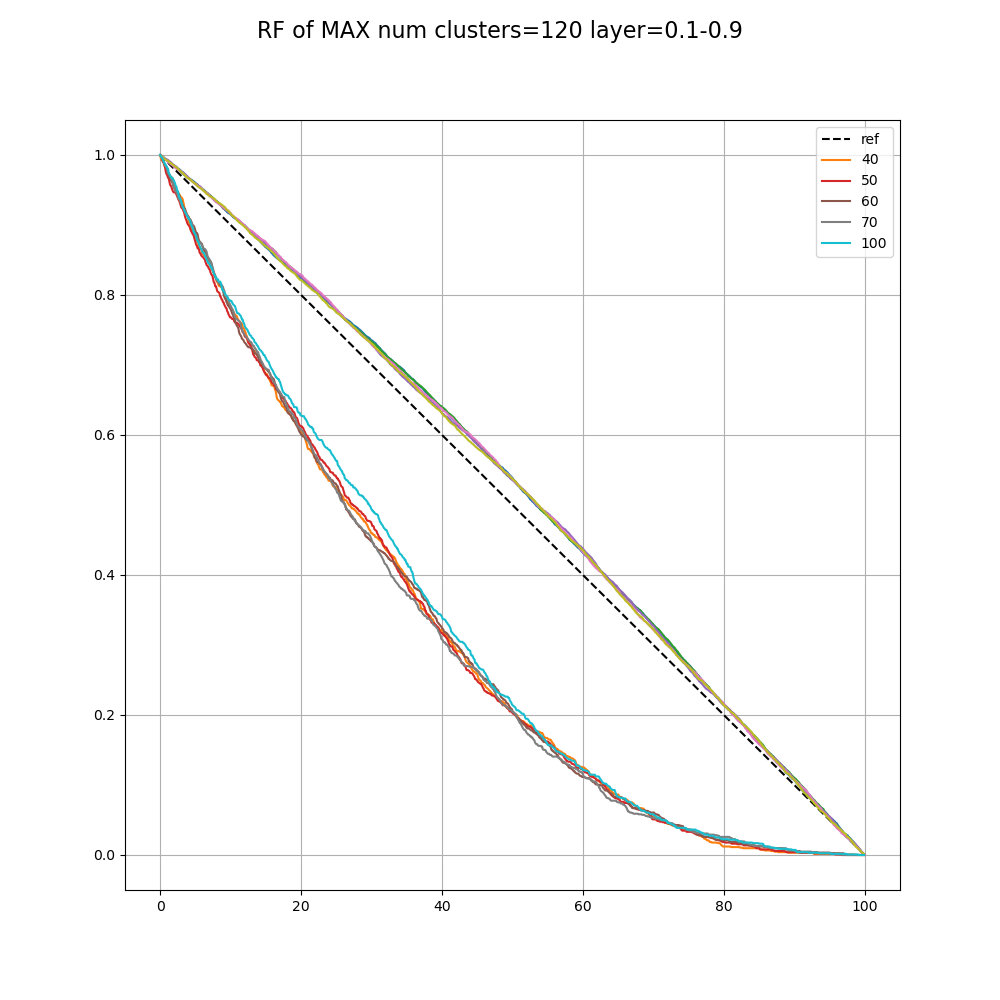

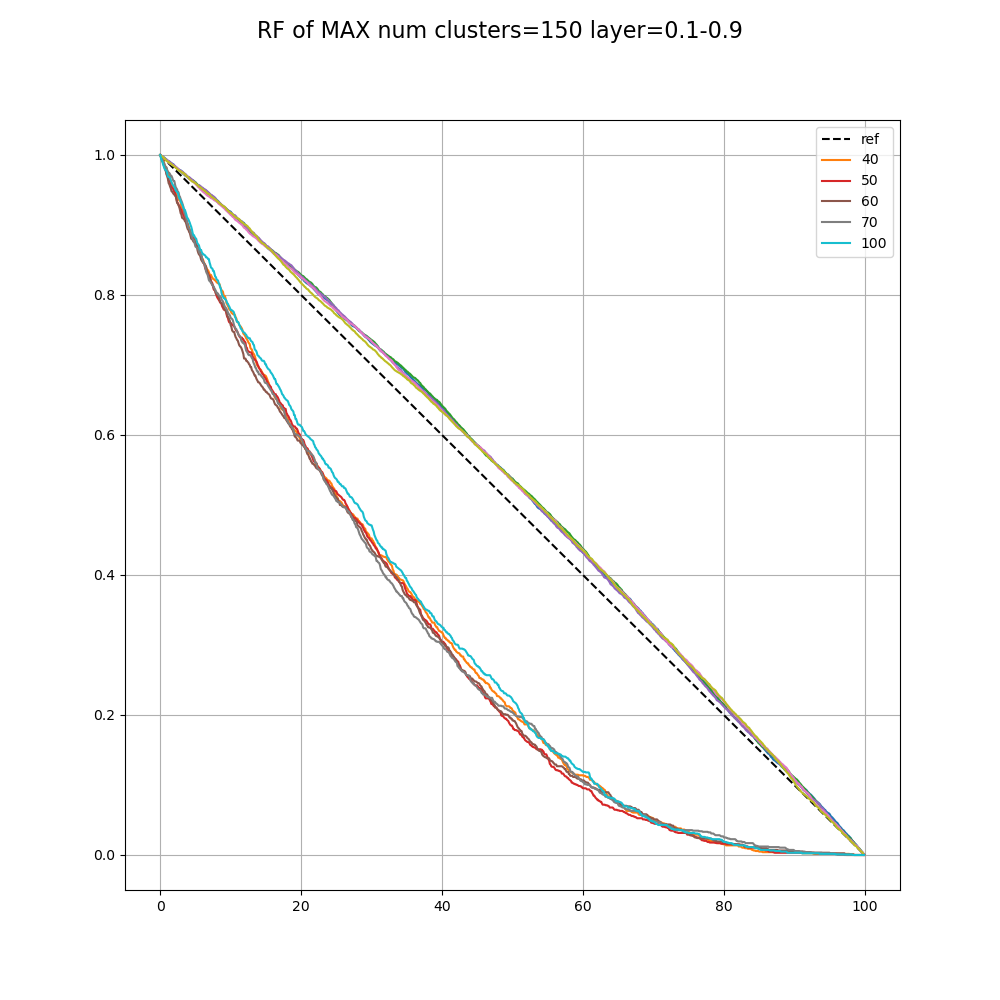

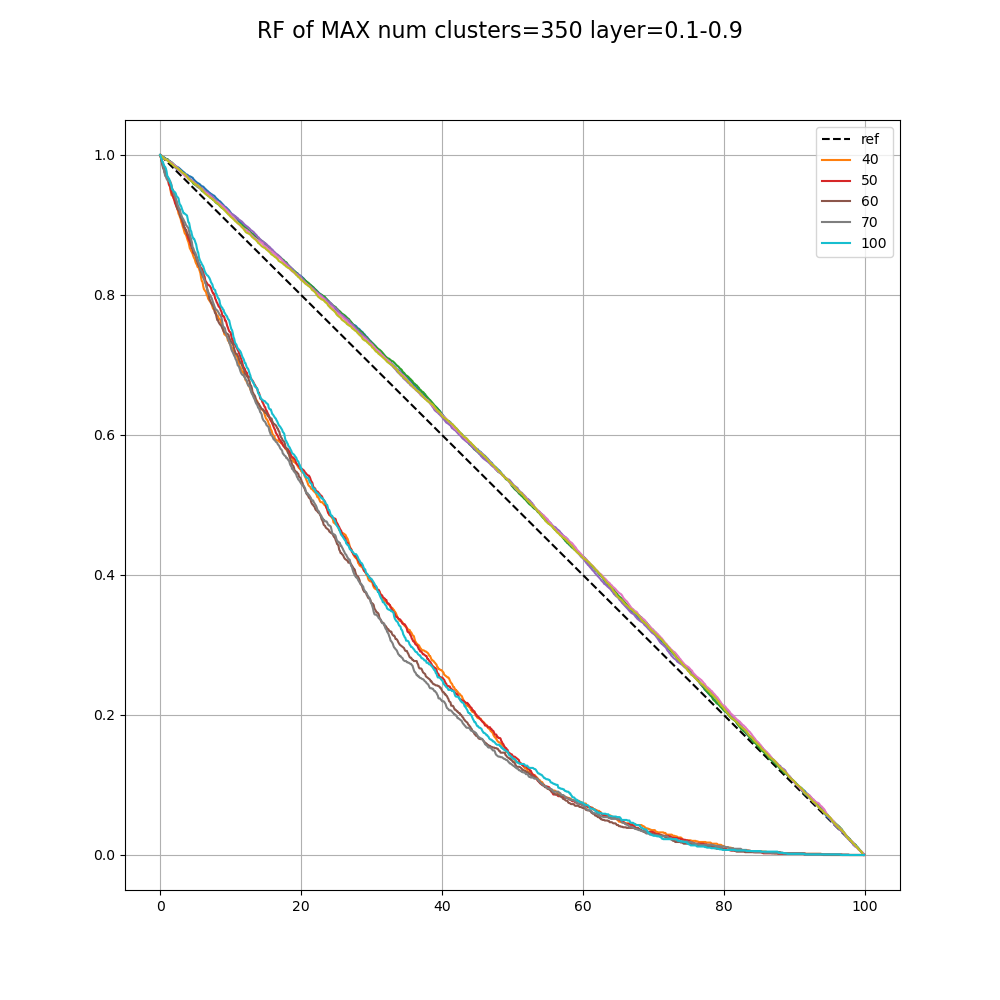

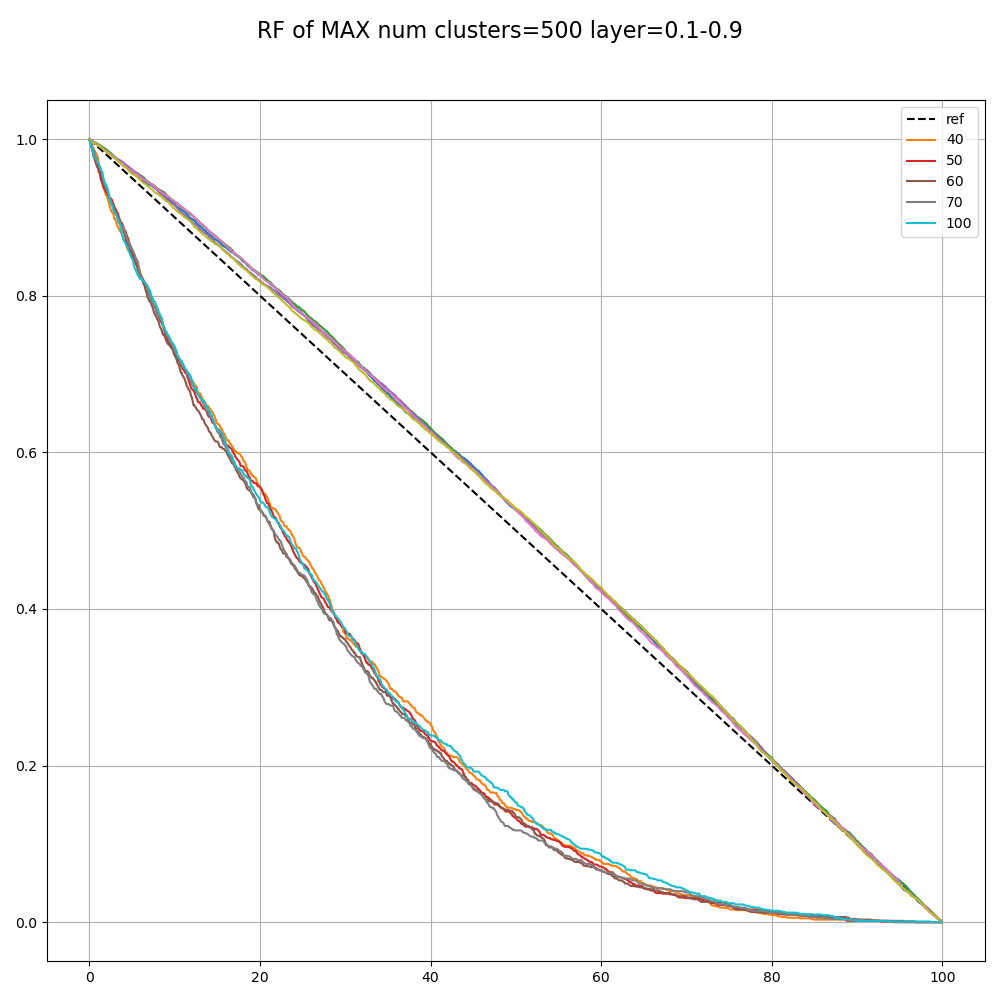

In [38]:
for key, weight in w_dict.items():

    for n in num_clusters: 
        
        fig, axs = plt.subplots(1,figsize=(10,10))
        axs.grid()
        axs.plot([0, 100],[1,0],label='ref', c='k', ls='--')
        cmap = plt.get_cmap('Blues')
        plt.set_cmap(cmap)
        
        for dim in dims_list: 
            
            ep = empirical_posterior[(dim,n)]
            cv = clustering_labels_val[(dim,n)]
            ct = clustering_labels_train[(dim,n)]

            prob_train = predict_proba_t(weights=weight, 
                                         empirical_posterior=ep, 
                                         clustering_labels=ct, 
                                         n_classes=100)
            
            if dim == 10 or dim== 15 or dim == 20 or dim == 25 or dim == 30:
                

                if n == 10 or n == 15 or n == 20 or n == 50 or n == 120 or n == 150:
                
                    prob_val = predict_proba_v(weights=weight, 
                                               empirical_posterior=ep, 
                                               clustering_labels=cv, 
                                               n_classes=100)
    
                else:
                    prob_val = predict_proba_t(weights=weight, 
                                               empirical_posterior=ep, 
                                               clustering_labels=cv, 
                                               n_classes=100)
            else:
                prob_val = predict_proba_t(weights=weight, 
                                               empirical_posterior=ep, 
                                               clustering_labels=cv, 
                                               n_classes=100)
            
            conf_t = np.max(prob_train,axis=1)
            conf_v = np.max(prob_val,axis=1)
            
            threshold = []
            list_true_max_ = []
            list_false_max_ = []
            
            for i in array:
            
                perc = np.percentile(conf_t, i)
                
                threshold.append(perc)
                idx = np.argwhere(conf_v>perc)[:,0]
                counter = collections.Counter(results[idx])
                list_true_max_.append(counter[True]/tot_true)
                list_false_max_.append(counter[False]/tot_false)  

            axs.plot(array,list_true_max_)
            axs.plot(array,list_false_max_,label=f'{dim}')
            
            axs.legend()
            fig.suptitle(f'RF of MAX num clusters={n} layer={key}', fontsize=16)
            
fig.tight_layout()
fig.subplots_adjust(top=0.9)


#### Attack visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[85]
tensor(1.0000, device='cuda:5', grad_fn=<MaxBackward1>)
tensor(85, device='cuda:5')
[58]
tensor(0.9842, device='cuda:5', grad_fn=<MaxBackward1>)
tensor(58, device='cuda:5')


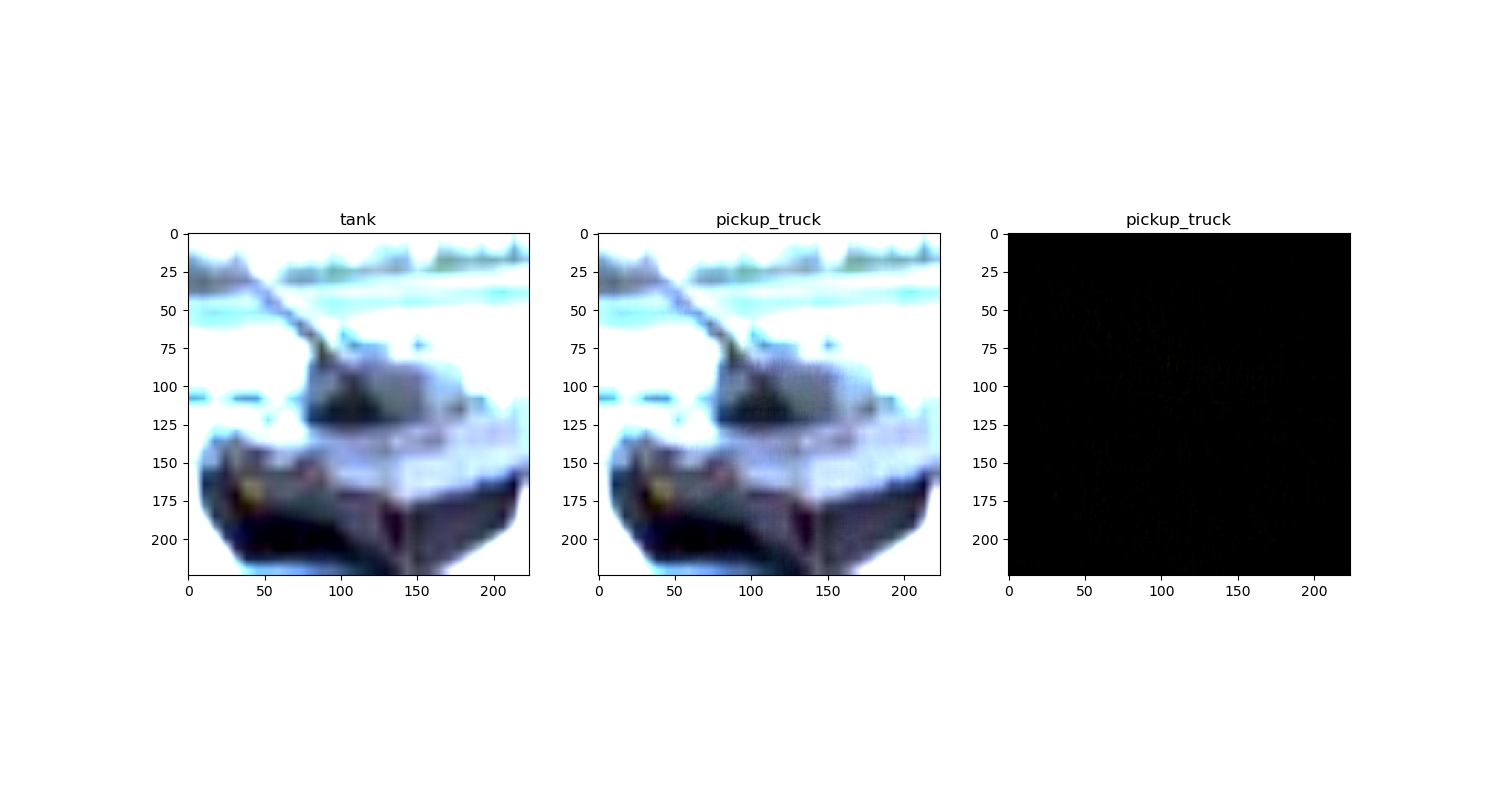

In [32]:
data_iterator = iter(val_loader)
attack_iterator = iter(attack_loader)

n = 18

for i in range(n):
    data, label = next(data_iterator)
    attack, target = next(attack_iterator)

data, label = data.to(device), label.to(device)
attack, target = attack.to(device), target.to(device)

model = model.to(device)
model.eval()

out = model(data)
out_attack = model(attack)

sm = nn.Softmax()

prob = sm(out)
prob_attack = sm(out_attack)

final_prob = prob.argmax(1, keepdim=True).detach().cpu().numpy()
final_prob_attack = prob_attack.argmax(1, keepdim=True).detach().cpu().numpy()

fig, axs = plt.subplots(1,3,figsize=(15,8))
k=8

# Plot data on each subplot
axs[0].imshow(np.transpose(data[k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

# Add titles to each subplot
axs[0].set_title(class_dict[int(final_prob[k])])

# Plot data on each subplot
axs[1].imshow(np.transpose(attack[k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

# Add titles to each subplot
axs[1].set_title(class_dict[int(final_prob_attack[k])])
# Plot data on each subplot
axs[2].imshow(np.transpose((data[k]-attack[k]).squeeze().detach().cpu().numpy(), (1, 2, 0)))

print(final_prob[k])
print(torch.max(prob[k]))
print(label[k])
print(final_prob_attack[k])
print(torch.max(prob_attack[k]))
print(target[k])

In [25]:
model.eval()
sm = nn.Softmax()


entropy_val = []
number_corrects = 0
number_samples = 0    
  

for data in tqdm(val_loader):
    image,label = data
    
    image = image.to(device)
    label = label.to(device)
    
    
    out = model(image)    
    prob = sm(out)

    final_prob = prob.argmax(axis=1)
    number_corrects += (label==final_prob).sum().item()
    number_samples += label.size(0)    
    
    entropy = H(prob.detach().cpu().numpy(),axis=1)
    entropy_val.append(entropy)

print(f'Overall accuracy {(number_corrects / number_samples)*100}%')
accuracy_nearest= (number_corrects / number_samples)*100

entropy_attack = []
number_corrects = 0
number_samples = 0

for data in tqdm(attack_loader):
    image,label = data
    
    image = image.to(device)
    label = label.to(device)
    
    out = model(image)    
    prob = sm(out)

    final_prob = prob.argmax(axis=1)
    number_corrects += (label==final_prob).sum().item()
    number_samples += label.size(0)  
    
    entropy = H(prob.detach().cpu().numpy(),axis=1)
    entropy_attack.append(entropy)

print(f'Attack success rate {(number_corrects / number_samples)*100}%')
attack_success = (number_corrects / number_samples)*100

100%|█████████████████████████████████████████| 157/157 [00:09<00:00, 16.16it/s]


Overall accuracy 90.48%


100%|█████████████████████████████████████████| 157/157 [00:08<00:00, 18.97it/s]

Attack success rate 99.87%


In [26]:
H_val = np.concatenate(entropy_val)

H_attack = np.concatenate(entropy_attack)

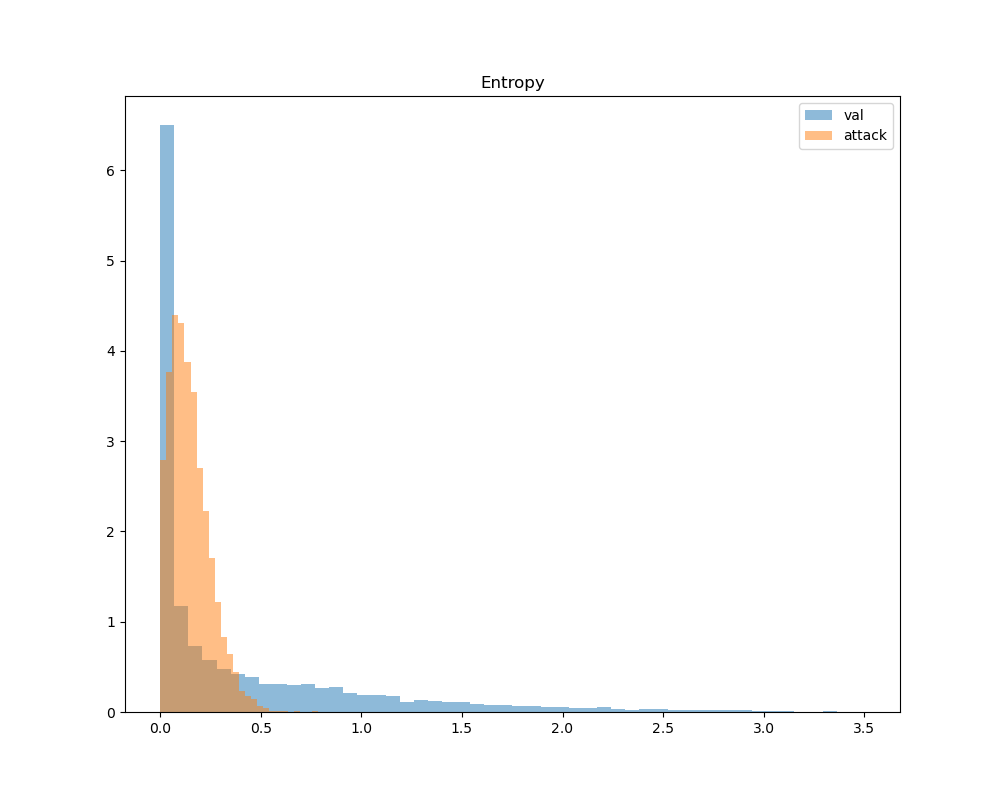

In [27]:
fig, axs = plt.subplots(1,figsize=(10,8))
axs.hist(H_val, bins=50, density=True, alpha=0.5, label='val')
axs.hist(H_attack, bins=30, density=True, alpha=0.5, label='attack')
axs.set_title('Entropy')
axs.legend()

plt.show()

In [28]:
original_labels = np.zeros(len(H_val))
attack_labels = np.ones(len(H_attack))

y_true = np.concatenate([original_labels, attack_labels])

y_score_NN = np.concatenate([H_val,H_attack])

auc_NN = AUC(y_true=y_true, y_score=y_score_NN)

auc_NN

0.5145534

### Analysis of the attacks on peephole

#### ENTROPY without SOFTMIN

##### Monitoring layers separately

###### no likelihood

In [98]:
for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            score_v = H(dv, axis=1)
            score_a = H(da, axis=1)

            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([score_v, score_a])

            auc_ = AUC(y_true=y_true, y_score=y_score)
            
            data.append((dim, n, auc_))

    if layer=='feat-24': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)
                        

In [99]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

###### with likelihood

In [100]:
for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            score_v = H(dv, axis=1)
            score_a = H(da, axis=1)
            
            kde_scott = KDE(score_v, bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(score_v))
            lh_attack = -np.log(kde_scott.pdf(score_a))
    
            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if layer=='feat-24': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)
                        

In [101]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

##### Monitoring the Joint PDF

In [102]:
dict_matrix_attack = {}
dict_matrix_val = {}

In [103]:
for n in num_clusters:

    for dim in dims_list:
        
        matrix_val = np.zeros((len_val,len(layer_list)))
        matrix_attack = np.zeros((len_val,len(layer_list)))

        for i,layer in enumerate(layer_list):
        
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            score_v = H(dv, axis=1)
            score_a = H(da, axis=1)  
            
            matrix_attack[:,i] = score_a
            matrix_val[:,i] = score_v
            
        dict_matrix_attack[(dim,n)] = matrix_attack
        dict_matrix_val[(dim,n)] = matrix_val
                        

In [104]:
list_layers = ['clas3', 'clas0-3', 'feat28+clas0-3', 'feat26-28+clas0-3', 'feat24-26-28+clas0-3']

for i in range(1,6):
    
    data = []
    
    for n in num_clusters:
    
        for dim in dims_list:
    
            kde_scott = KDE(dict_matrix_val[(dim,n)].T[-i:], bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(dict_matrix_val[(dim,n)].T[-i:]))
            lh_attack = -np.log(kde_scott.pdf(dict_matrix_attack[(dim,n)].T[-i:]))
    
            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if i==1: # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)              

In [105]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

#### ENTROPY with SOFTMIN

##### Monitoring layers separately

###### without likelihood

In [106]:
for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            _val = torch.Tensor(dv)
            _attack = torch.Tensor(da)

            pv = torch.nn.functional.softmin(_val, dim=1)
            pa = torch.nn.functional.softmin(_attack, dim=1)

            score_v = H(pv.detach().cpu().numpy(), axis=1)
            score_a = H(pa.detach().cpu().numpy(), axis=1)

            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([score_v, score_a])

            auc_ = AUC(y_true=y_true, y_score=y_score)
            
            data.append((dim, n, auc_))

    if layer=='feat-24': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)
                        

In [107]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

###### with likelihood

In [108]:
for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            _val = torch.Tensor(dv)
            _attack = torch.Tensor(da)

            pv = torch.nn.functional.softmin(_val, dim=1)
            pa = torch.nn.functional.softmin(_attack, dim=1)

            score_v = H(pv.detach().cpu().numpy(), axis=1)
            score_a = H(pa.detach().cpu().numpy(), axis=1)
            
            kde_scott = KDE(score_v, bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(score_v))
            lh_attack = -np.log(kde_scott.pdf(score_a))
    
            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if layer=='feat-24': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)
                        

In [109]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

##### Monitoring the Joint PDF

In [110]:
dict_matrix_attack = {}
dict_matrix_val = {}

In [111]:
for n in num_clusters:

    for dim in dims_list:
        
        matrix_val = np.zeros((len_val,len(layer_list)))
        matrix_attack = np.zeros((len_val,len(layer_list)))

        for i,layer in enumerate(layer_list):
        
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            _val = torch.Tensor(dv)
            _attack = torch.Tensor(da)

            pv = torch.nn.functional.softmin(_val, dim=1)
            pa = torch.nn.functional.softmin(_attack, dim=1)

            score_v = H(pv.detach().cpu().numpy(), axis=1)
            score_a = H(pa.detach().cpu().numpy(), axis=1)    
            
            matrix_attack[:,i] = score_a
            matrix_val[:,i] = score_v
            
        dict_matrix_attack[(dim,n)] = matrix_attack
        dict_matrix_val[(dim,n)] = matrix_val
                        

In [112]:
list_layers = ['clas3', 'clas0-3', 'feat28+clas0-3', 'feat26-28+clas0-3', 'feat24-26-28+clas0-3']

for i in range(1,6):
    
    data = []
    
    for n in num_clusters:
    
        for dim in dims_list:
    
            kde_scott = KDE(dict_matrix_val[(dim,n)].T[-i:], bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(dict_matrix_val[(dim,n)].T[-i:]))
            lh_attack = -np.log(kde_scott.pdf(dict_matrix_attack[(dim,n)].T[-i:]))
    
            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if i==1: # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)              

In [113]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

#### MIN

##### Monitoring layers separately

###### without likelihood

In [12]:
dict_min = {}
dict_attack = {}

for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            score_v = np.min(dv, axis=1)
            score_a = np.min(da, axis=1)

            dict_min[(n, dim)] = score_v
            dict_attack[(n, dim)] = score_a

    #         original_labels = np.zeros(len_val)
    #         attack_labels = np.ones(len_val)

    #         y_true = np.concatenate([original_labels, attack_labels])

    #         y_score = np.concatenate([score_v, score_a])

    #         auc_ = AUC(y_true=y_true, y_score=y_score)
            
    #         data.append((dim, n, auc_))

    # if layer=='feat-24': # starting building results dataframe
    #     df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
    #     df.set_index(['dim', 'n_clusters'], inplace=True)
    #     df.sort_index(inplace=True)
    # else: # concatenate with previous results
    #     df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
    #     df_.set_index(['dim', 'n_clusters'], inplace=True)
    #     df_.sort_index(inplace=True)
    #     df = df.join(df_)
                        

In [115]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

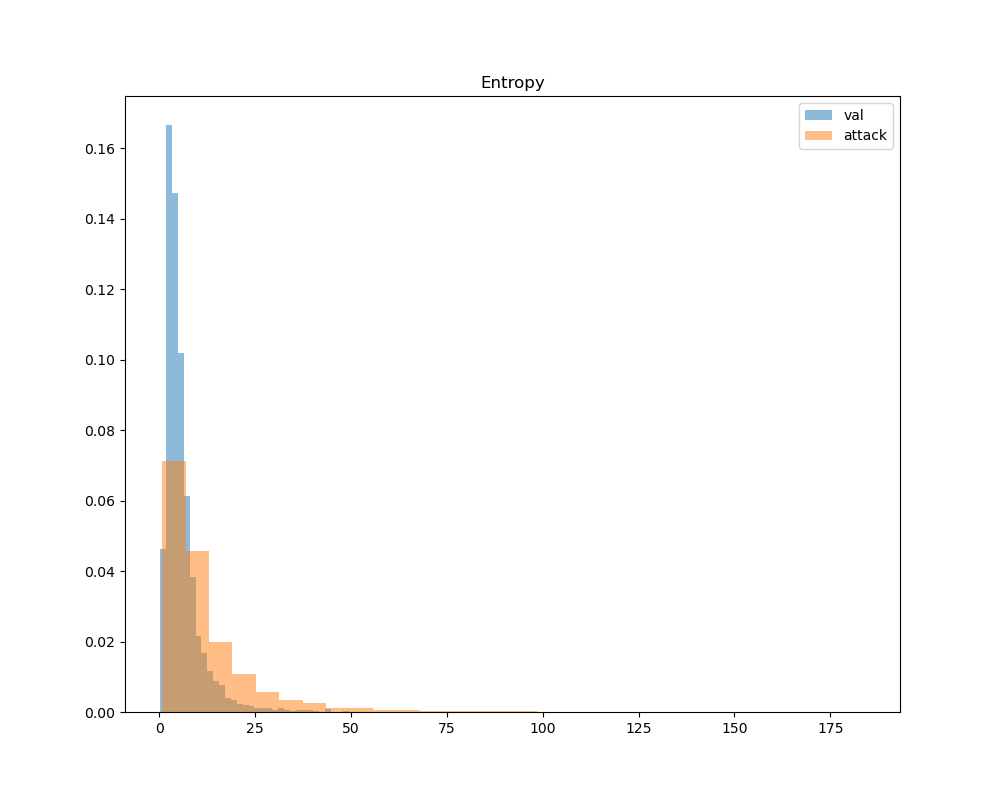

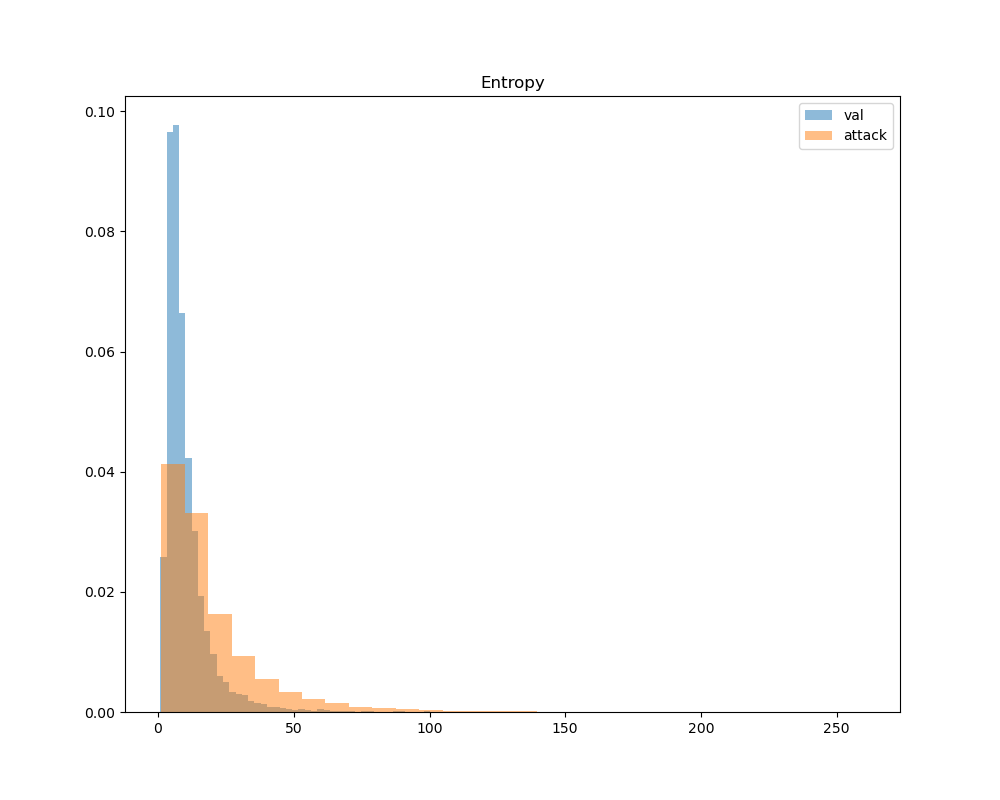

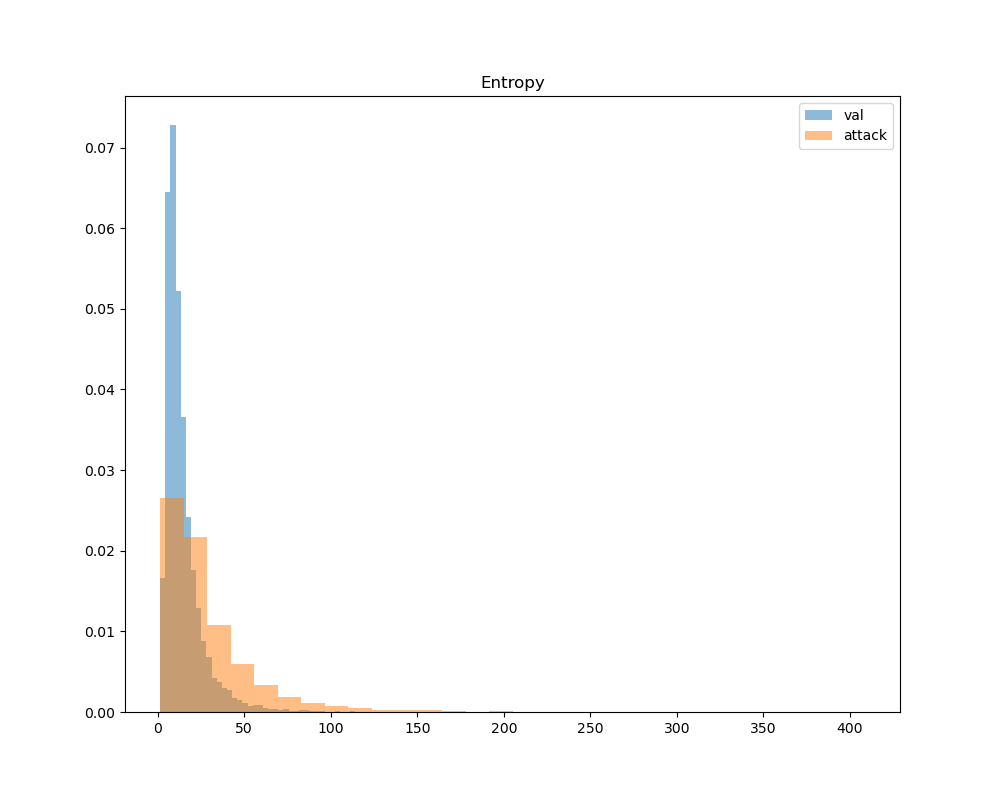

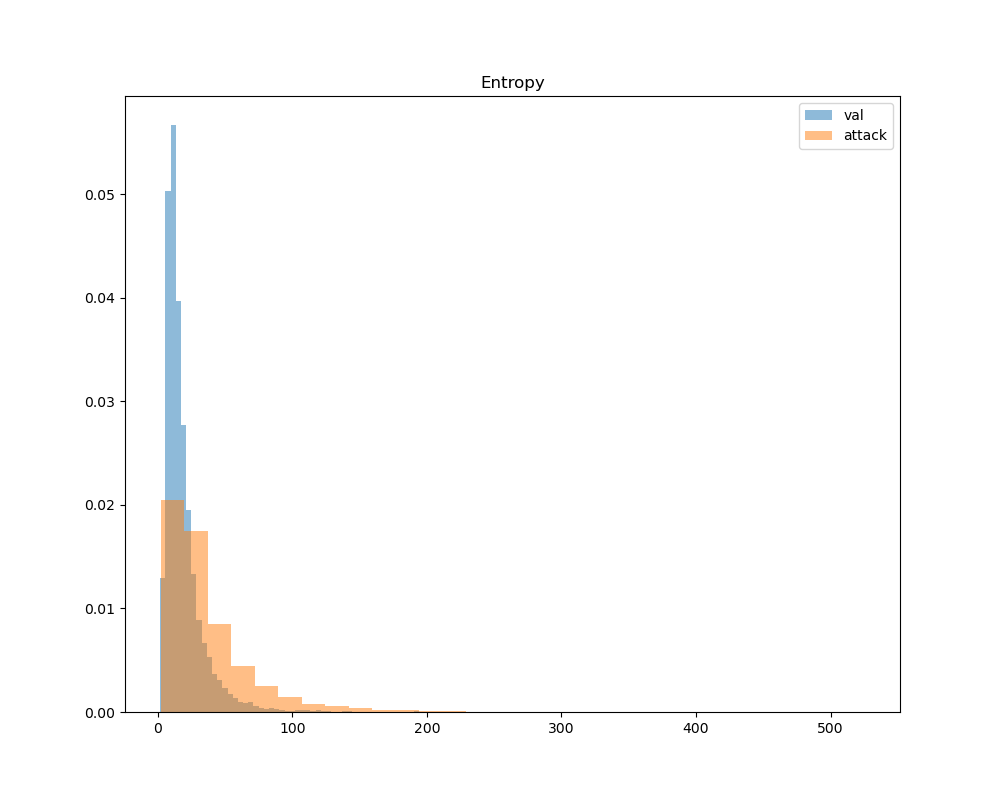

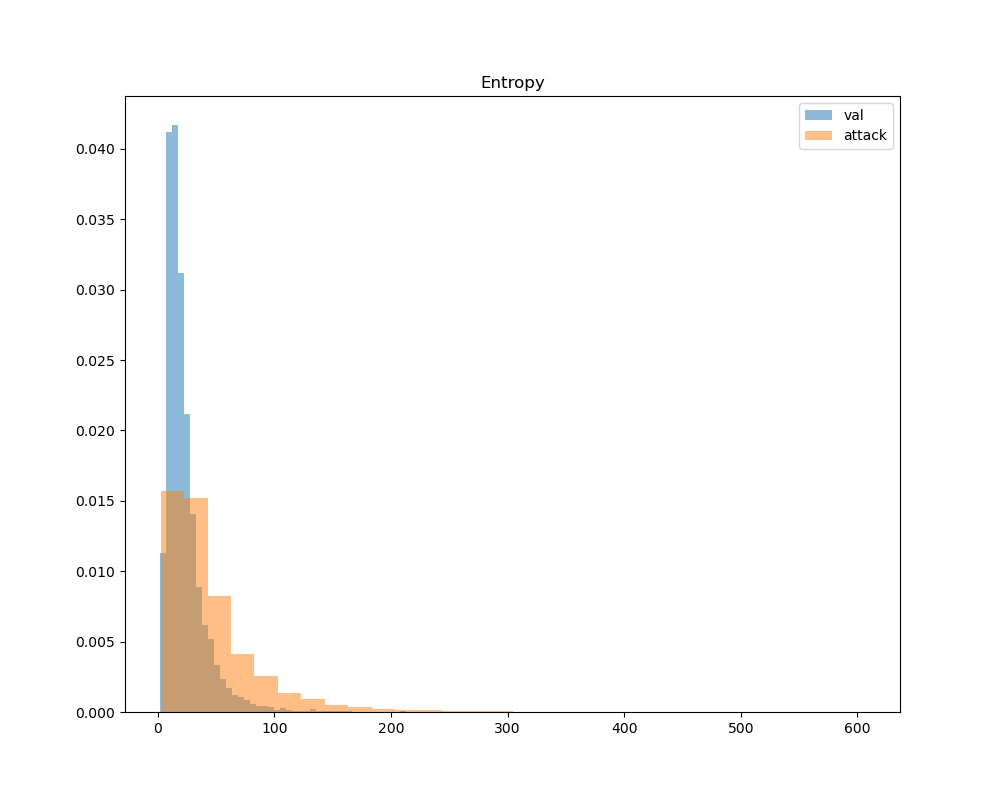

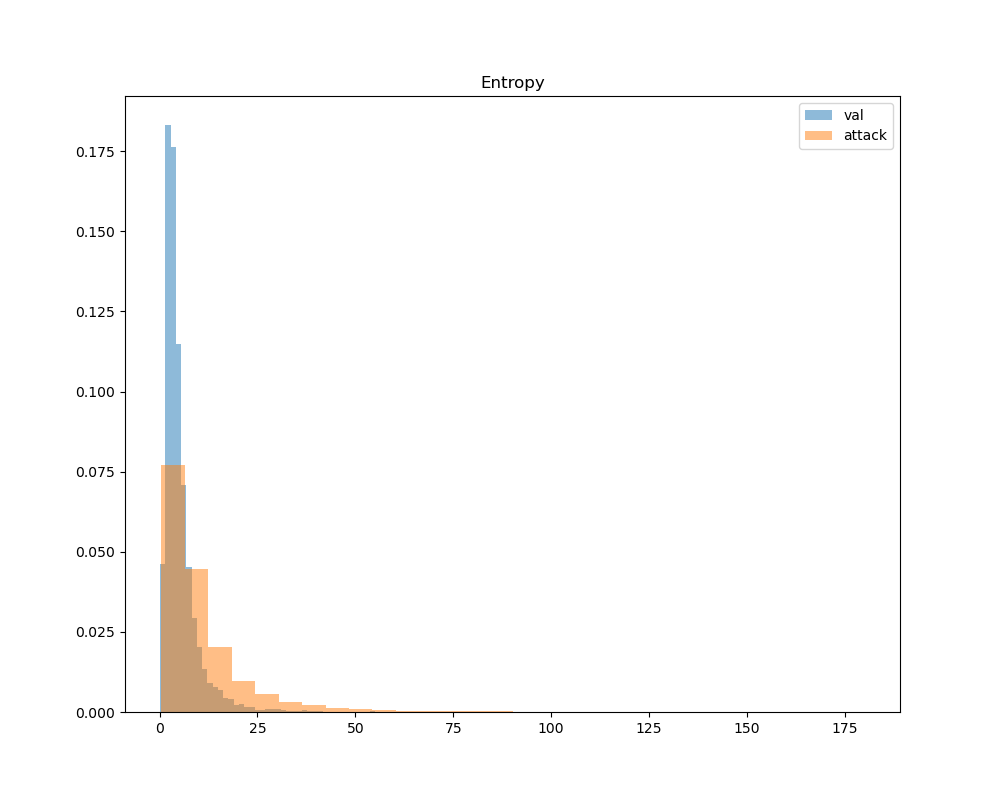

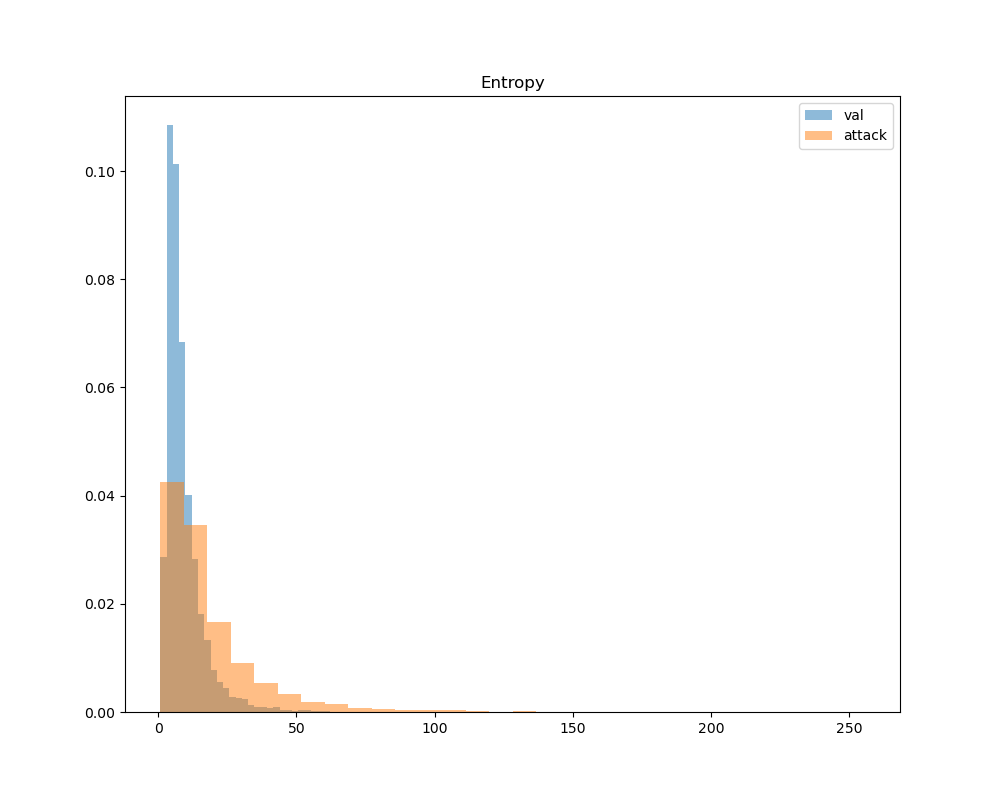

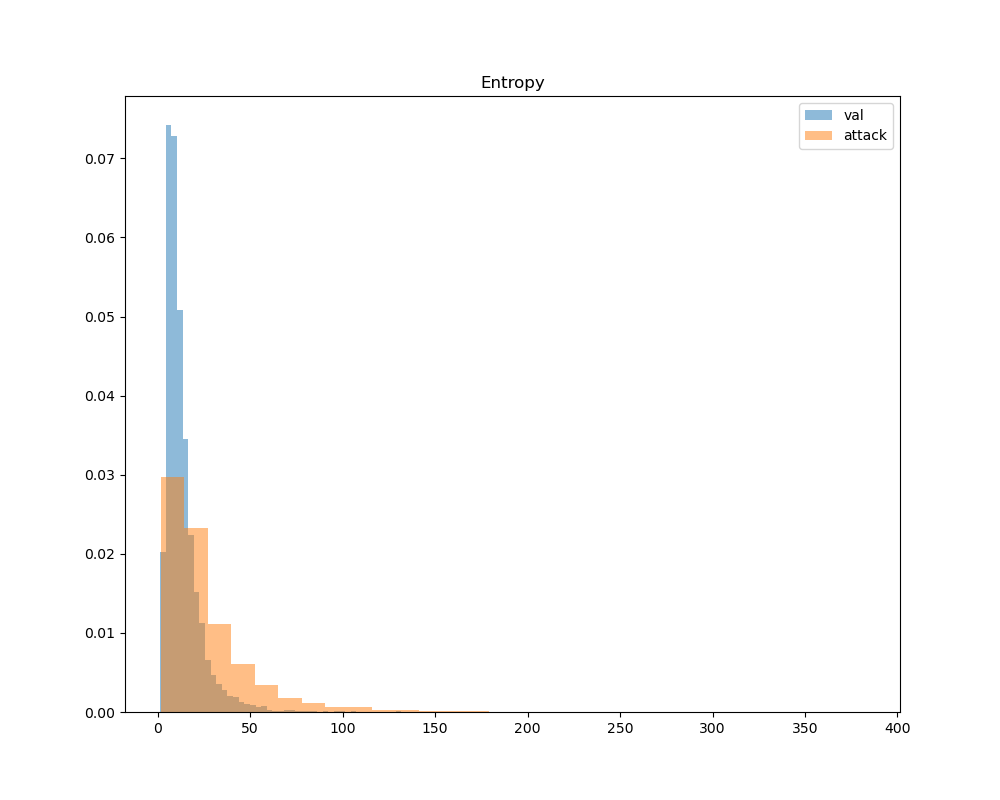

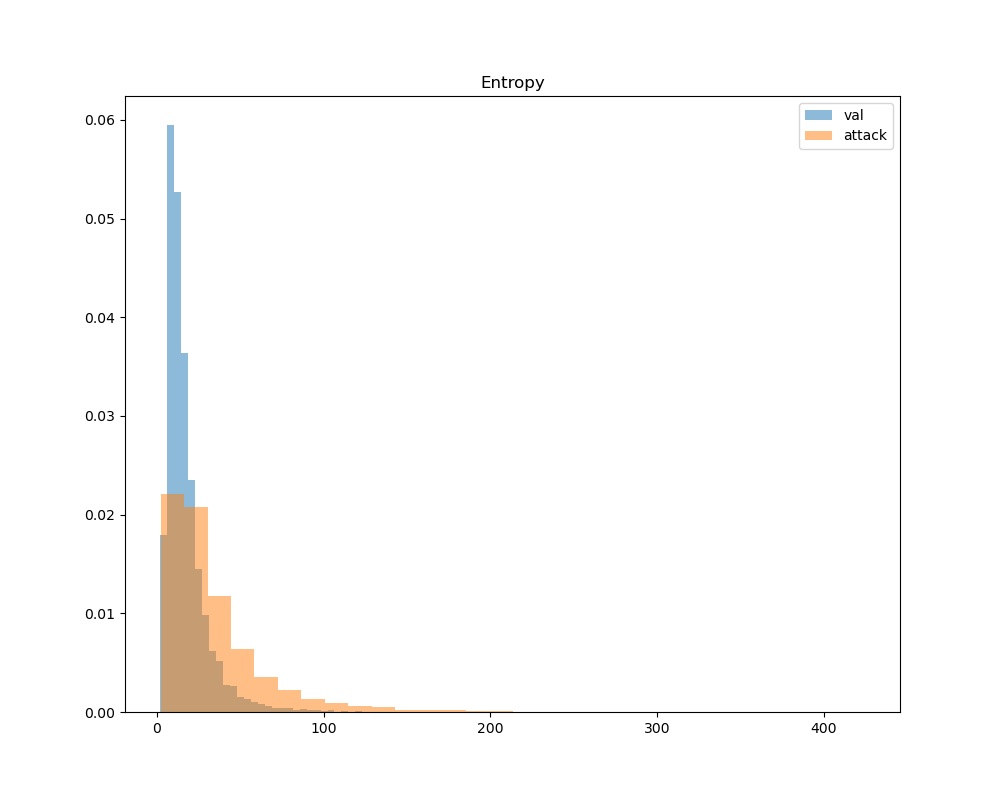

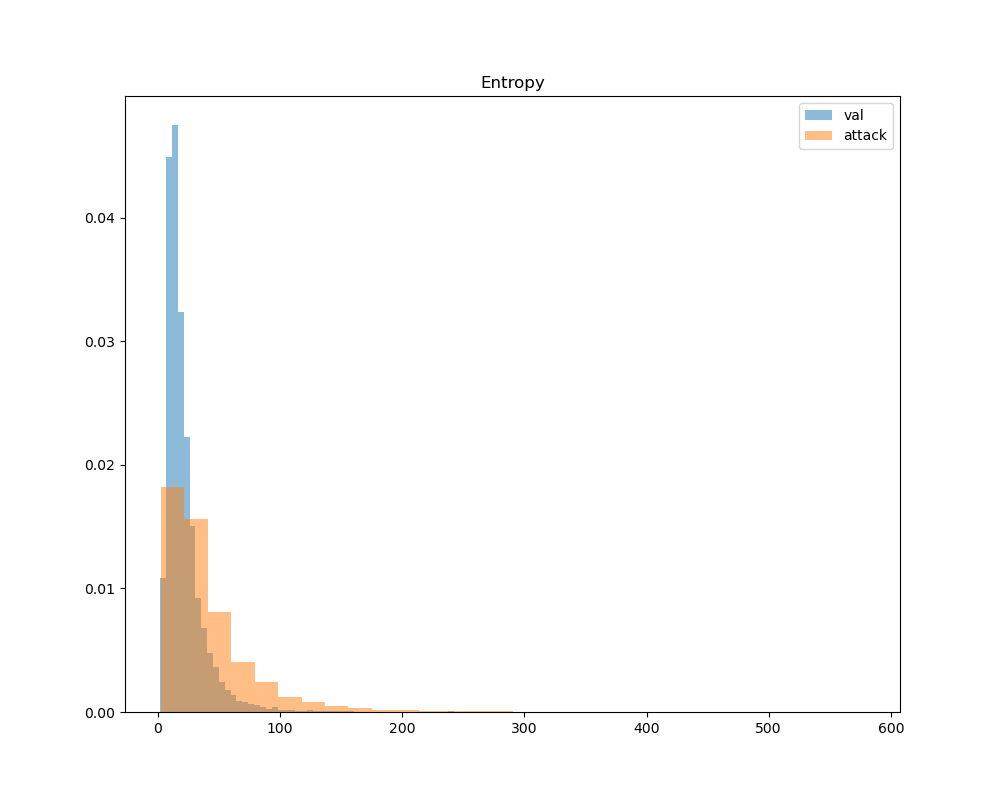

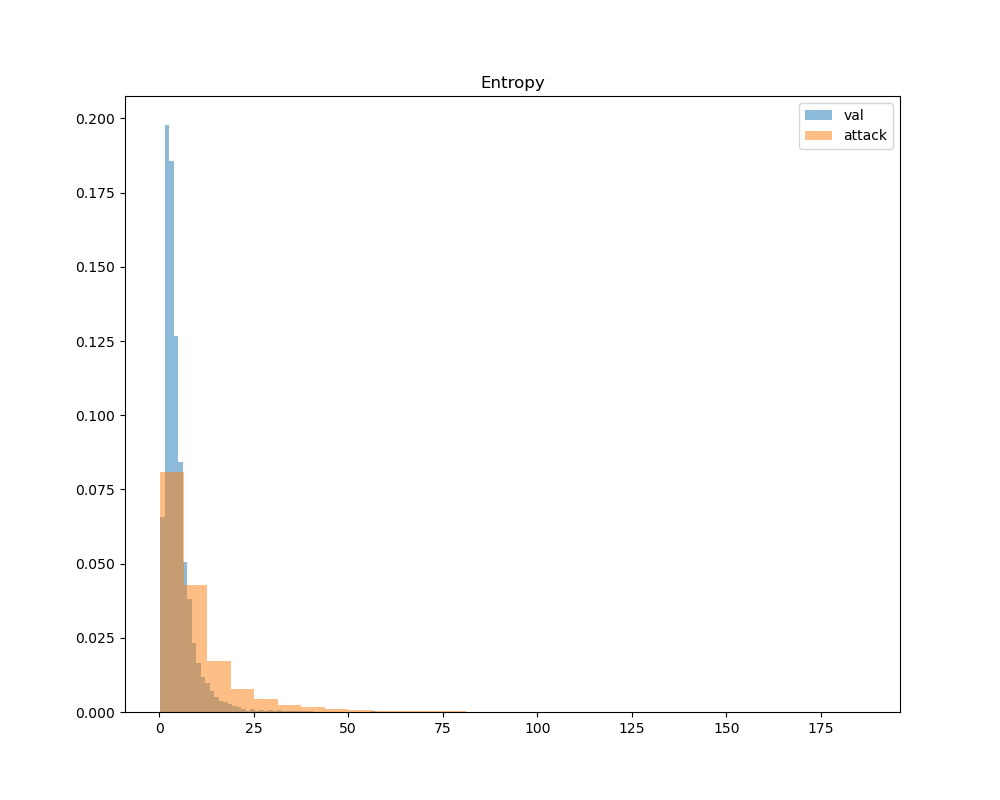

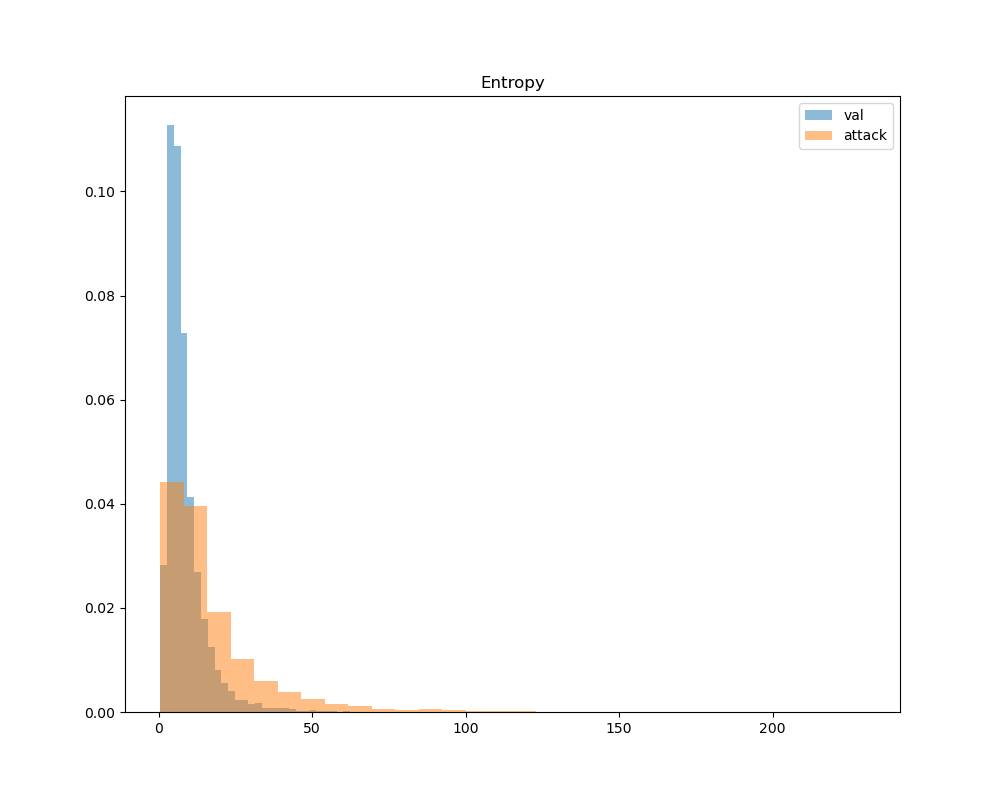

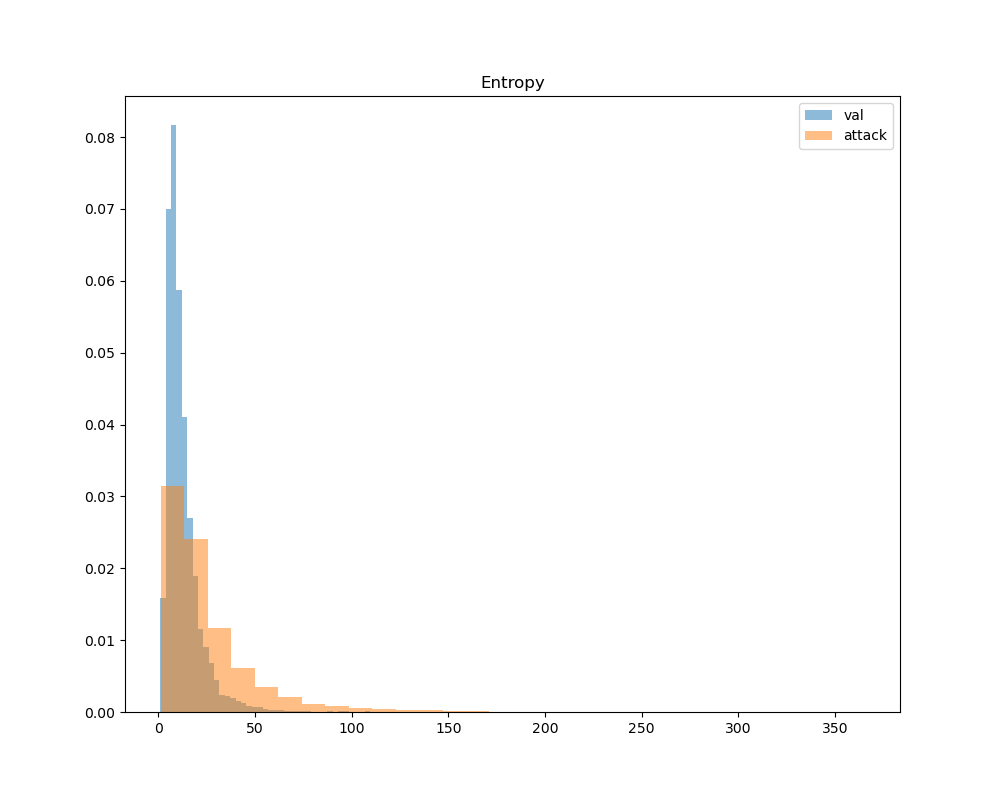

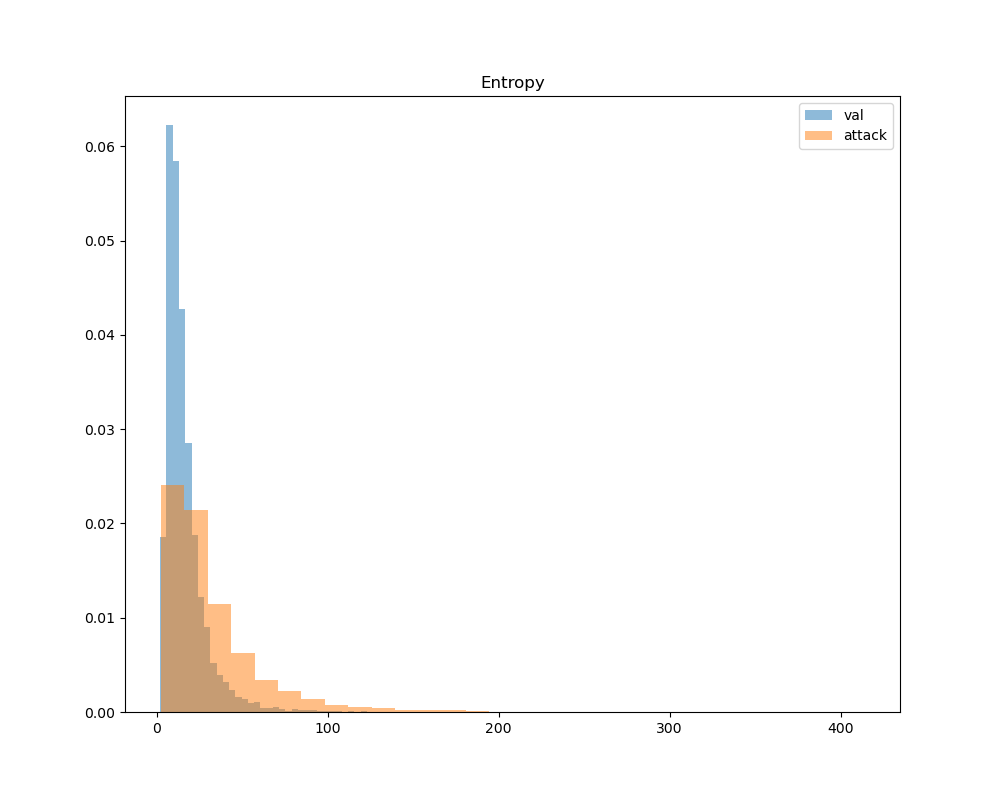

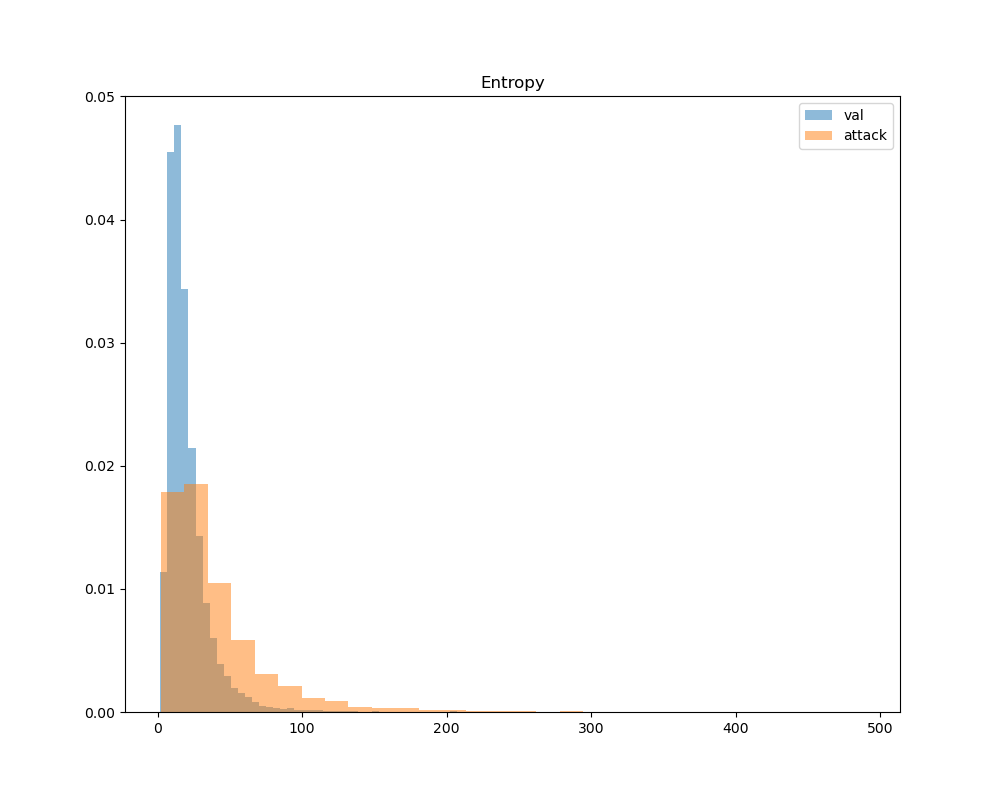

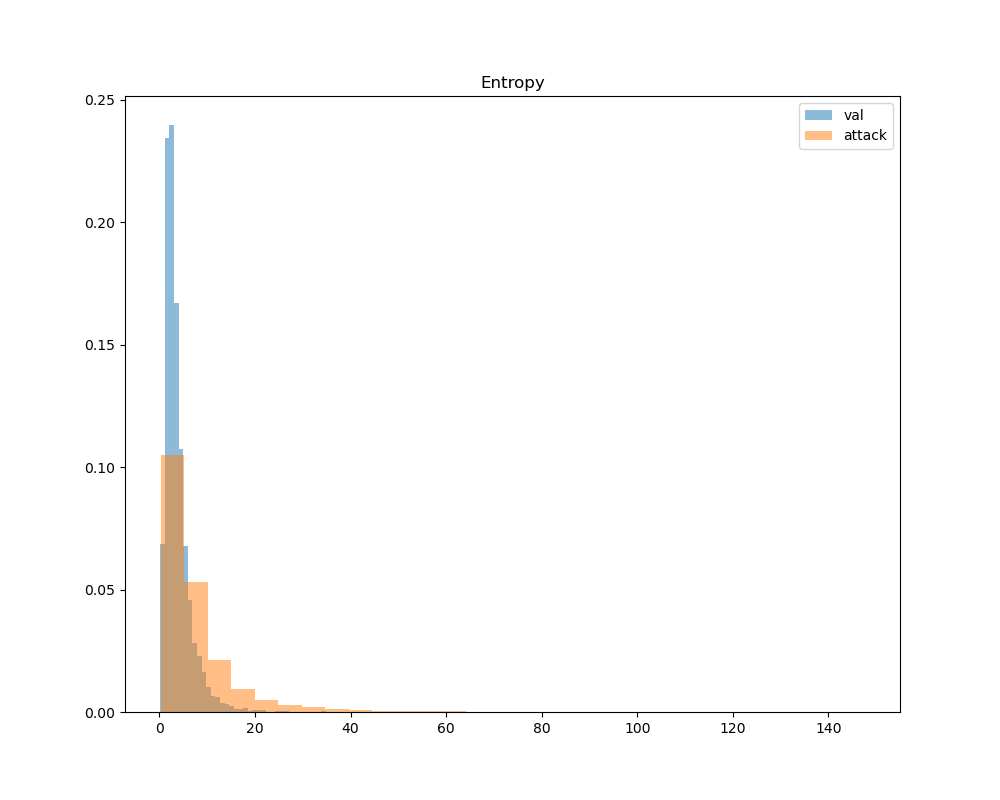

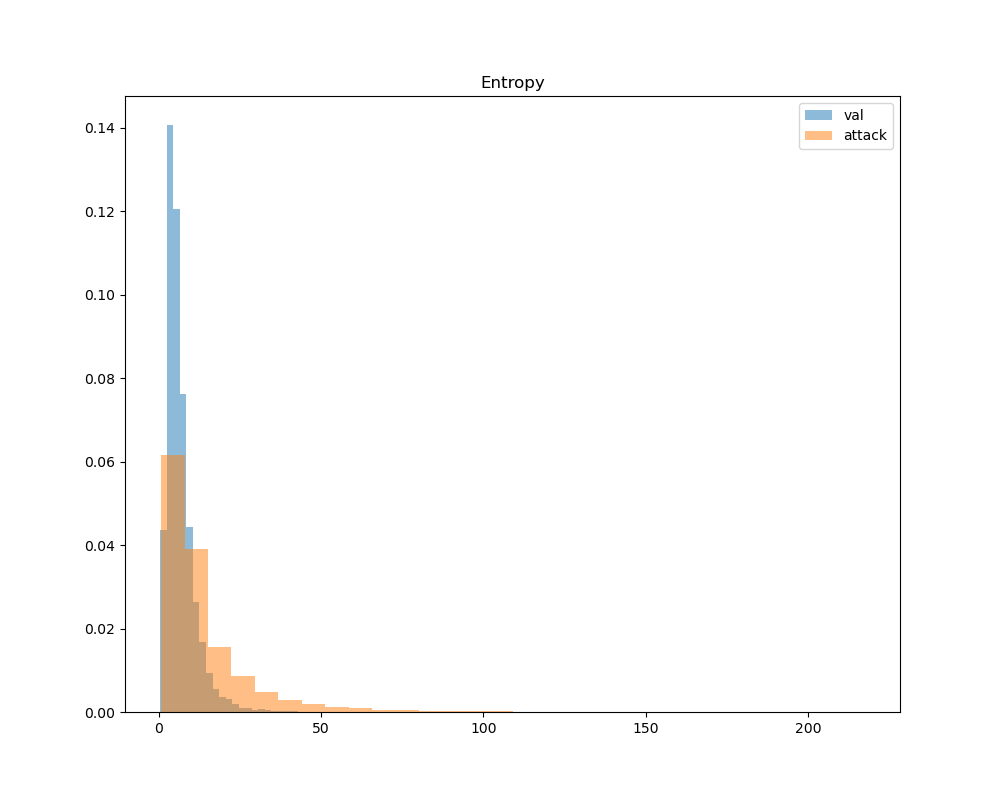

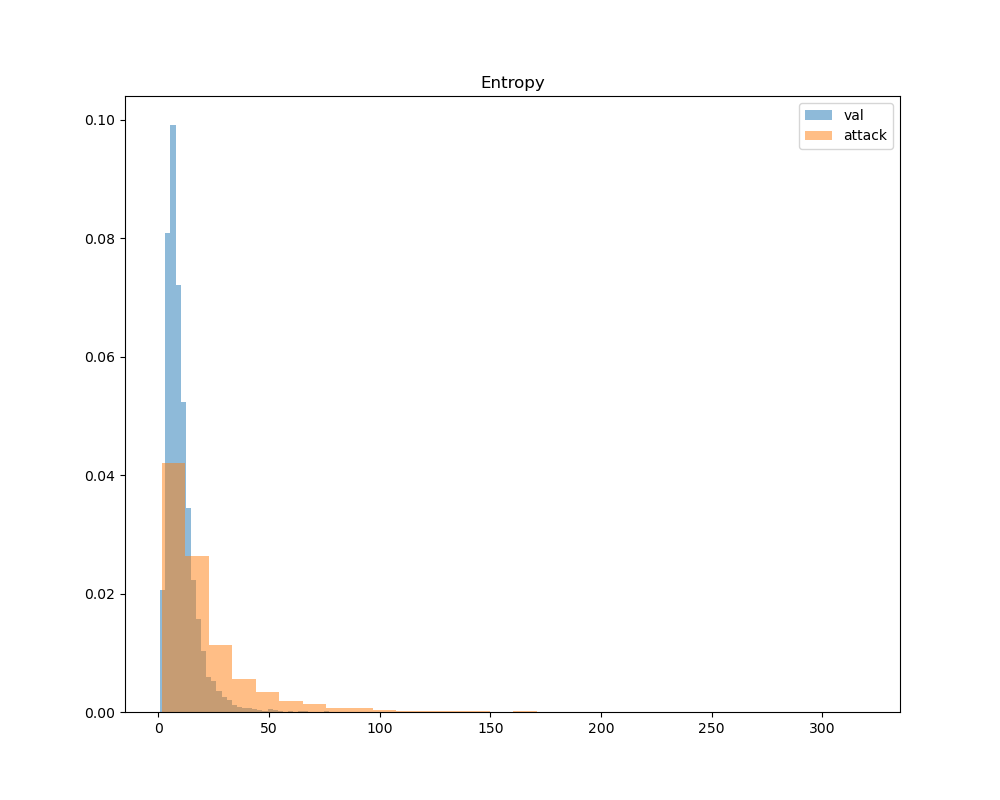

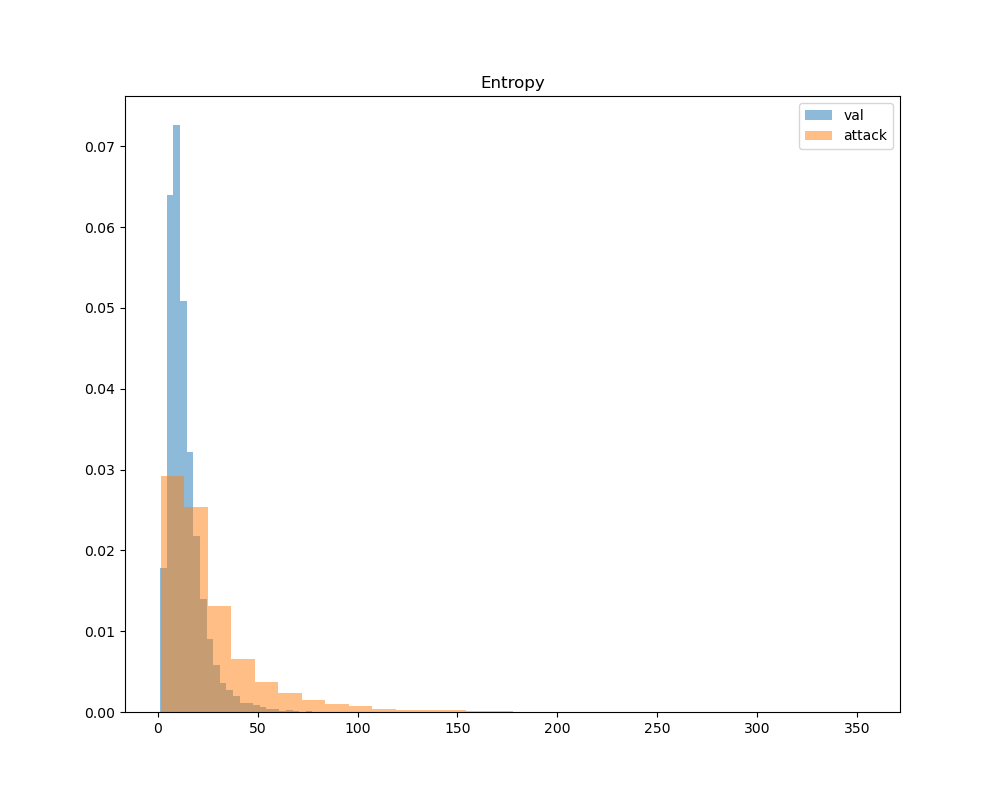

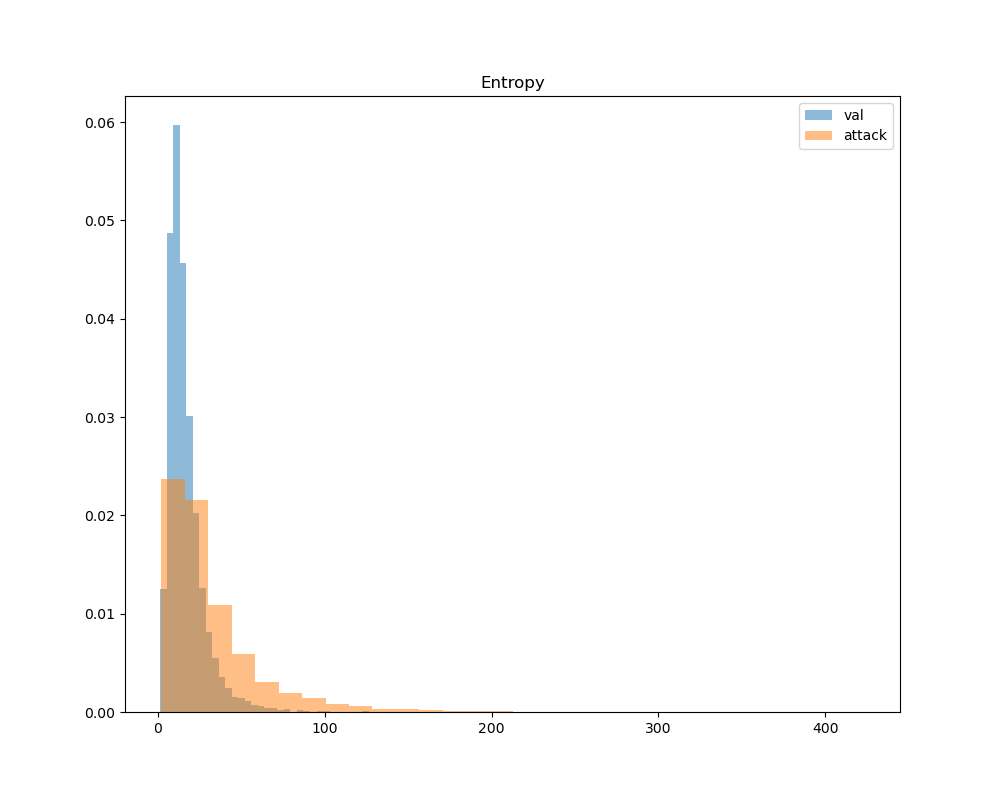

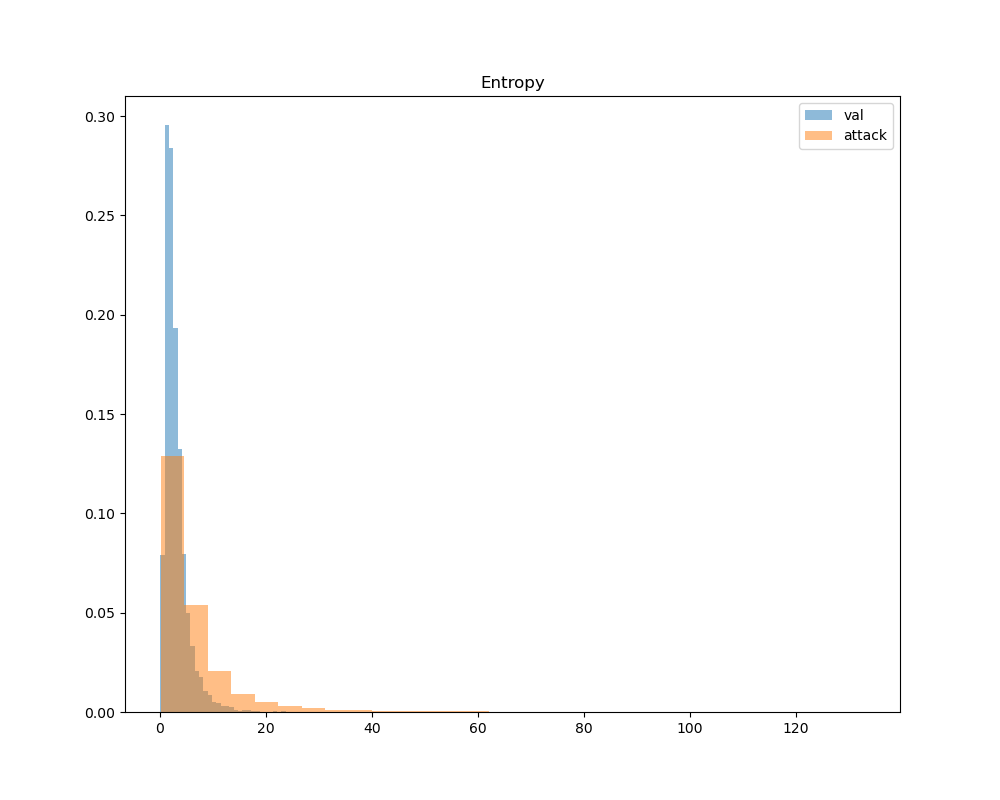

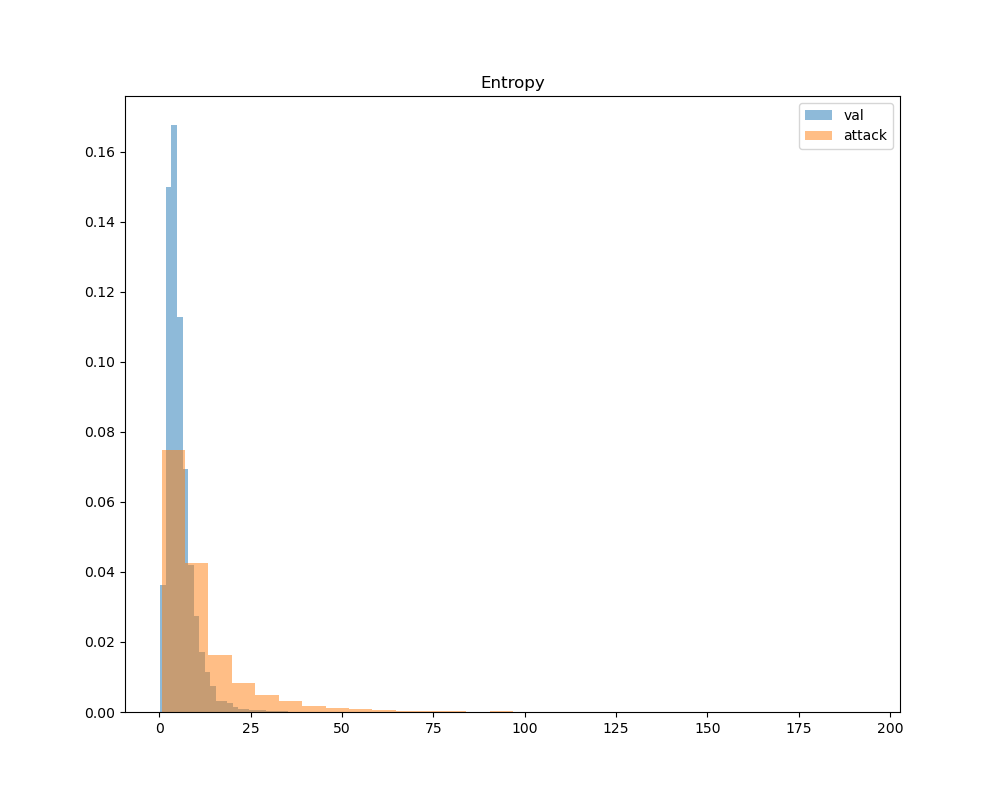

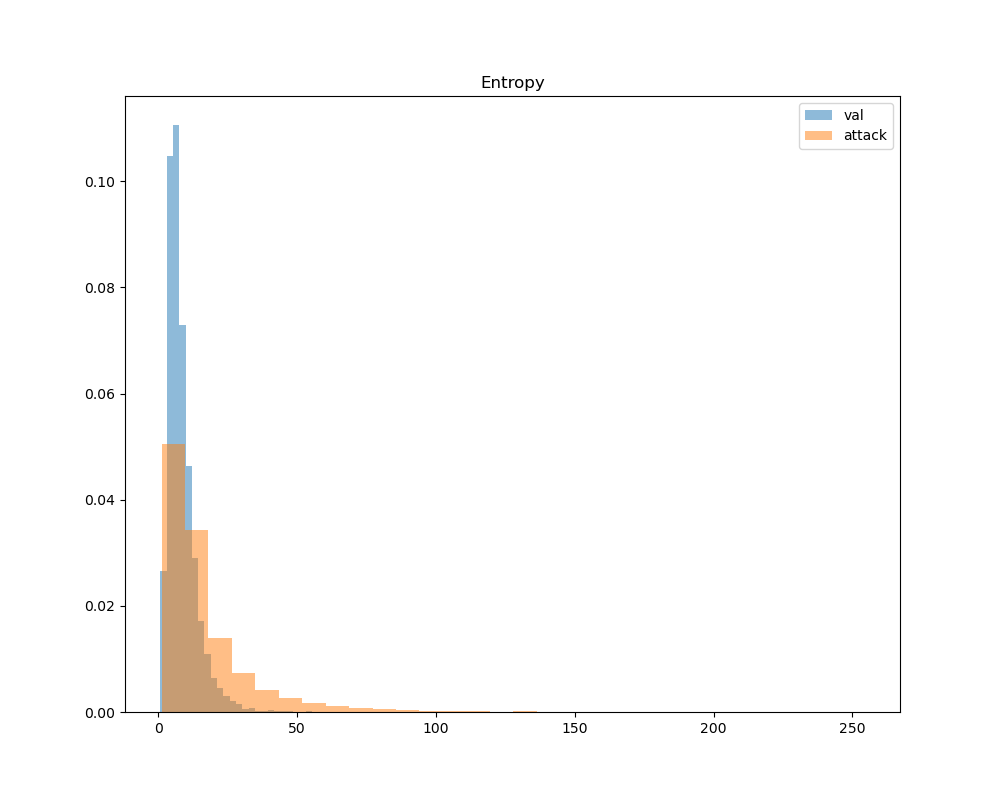

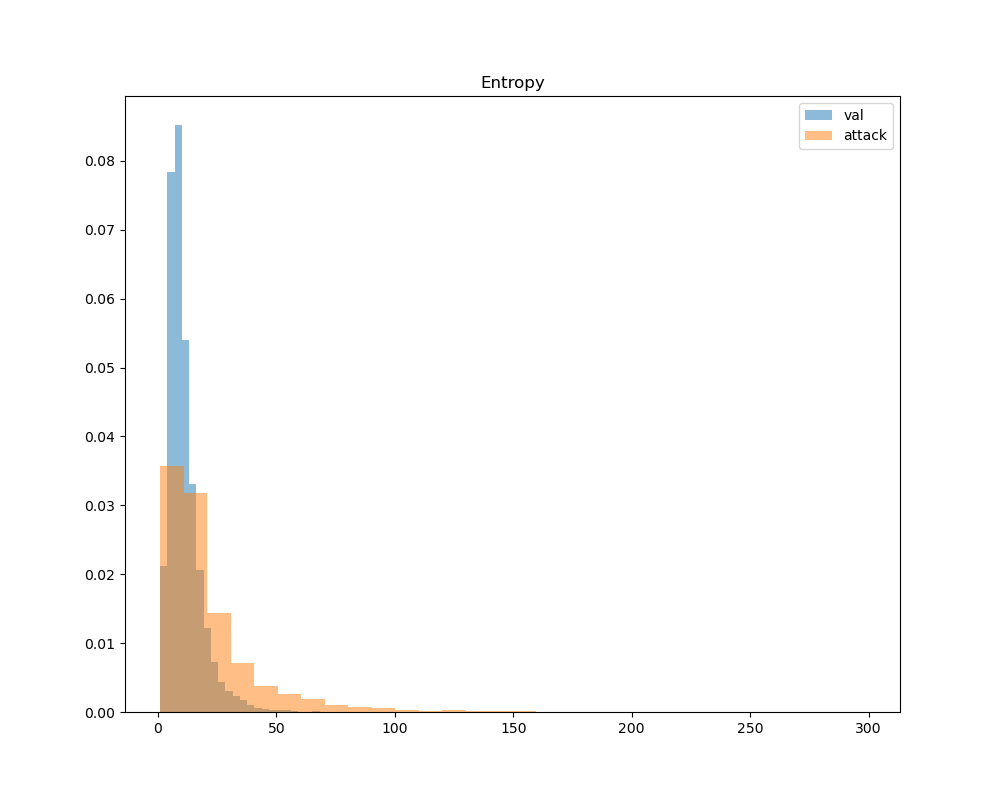

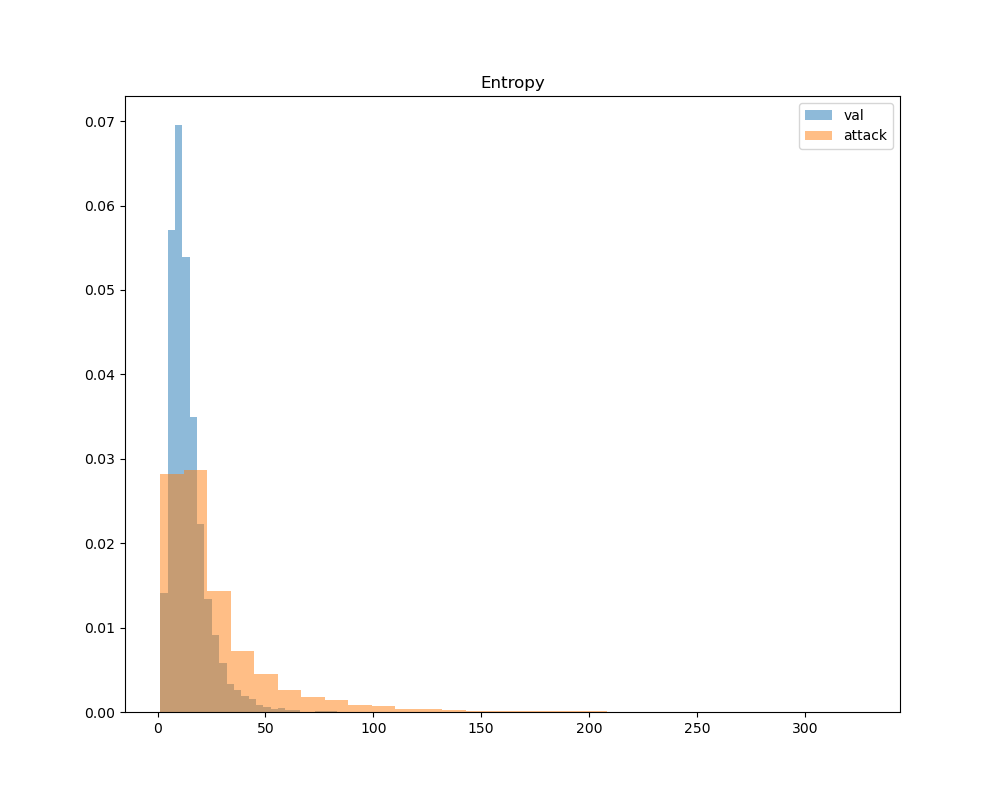

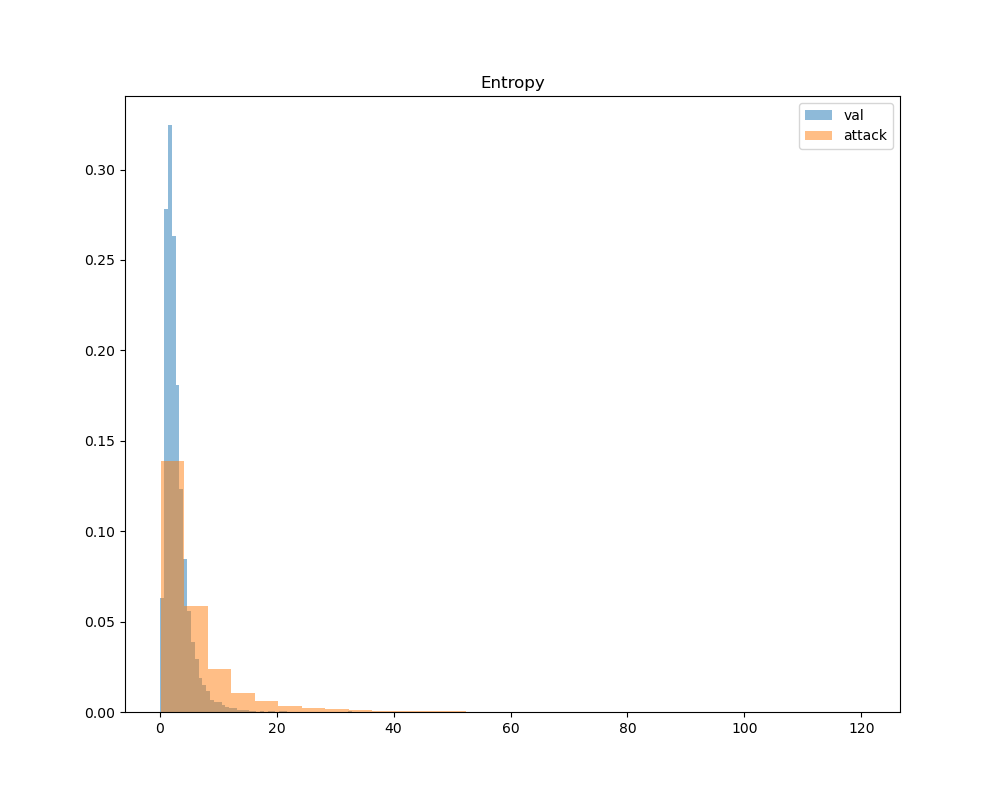

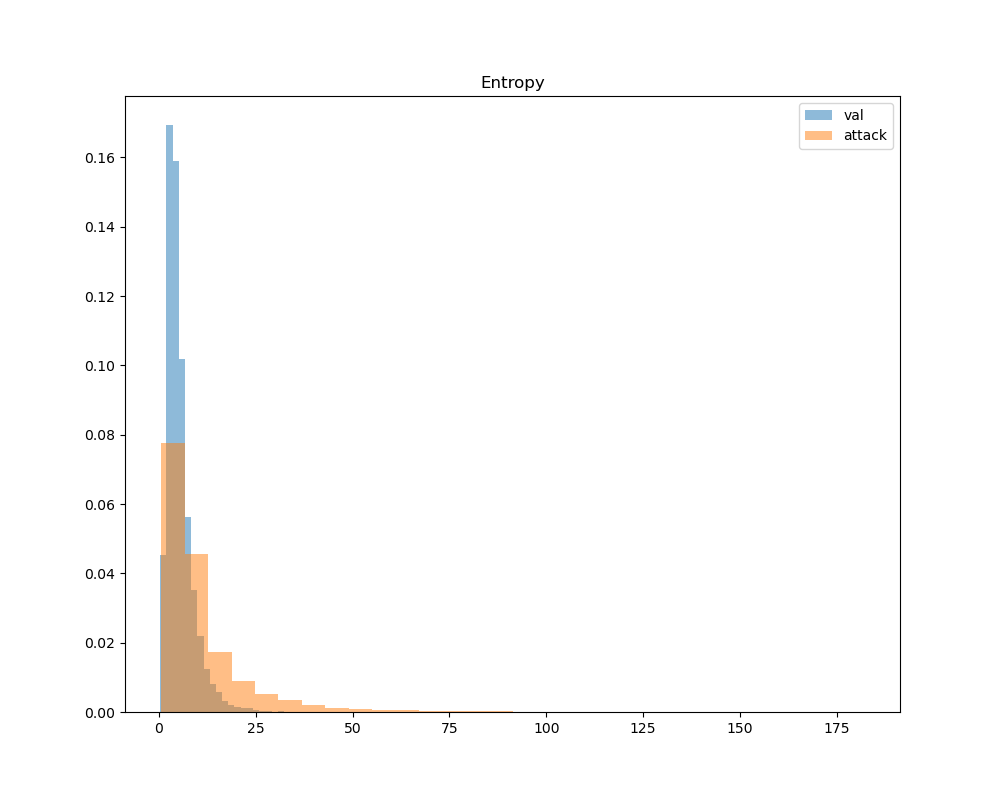

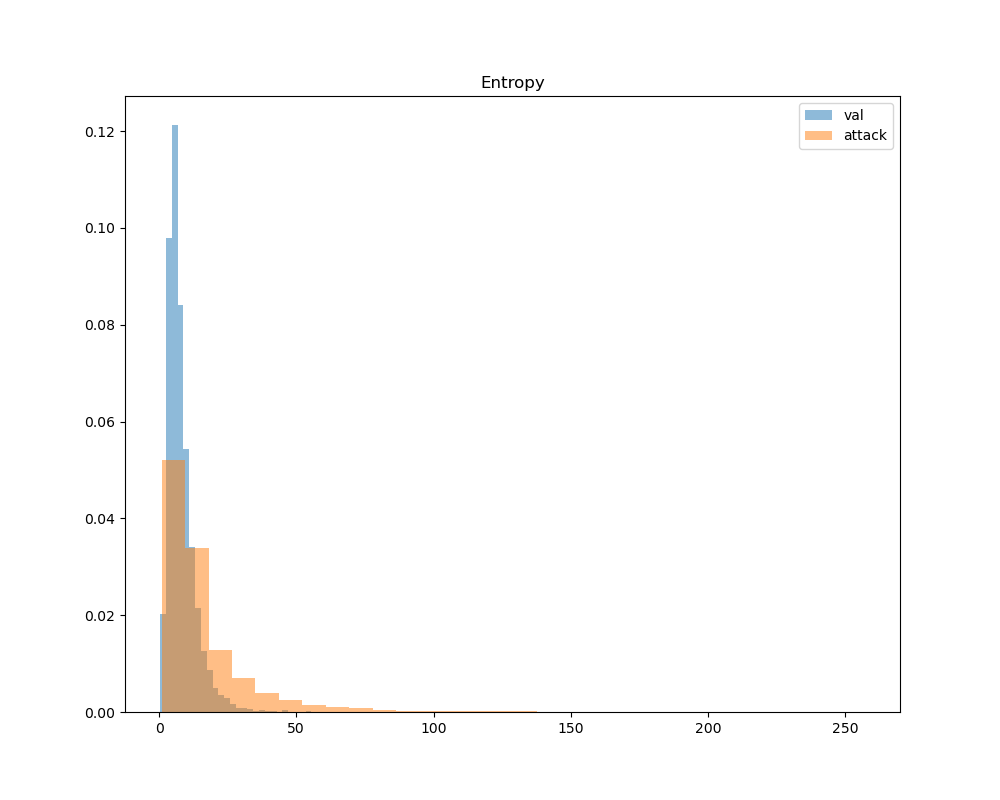

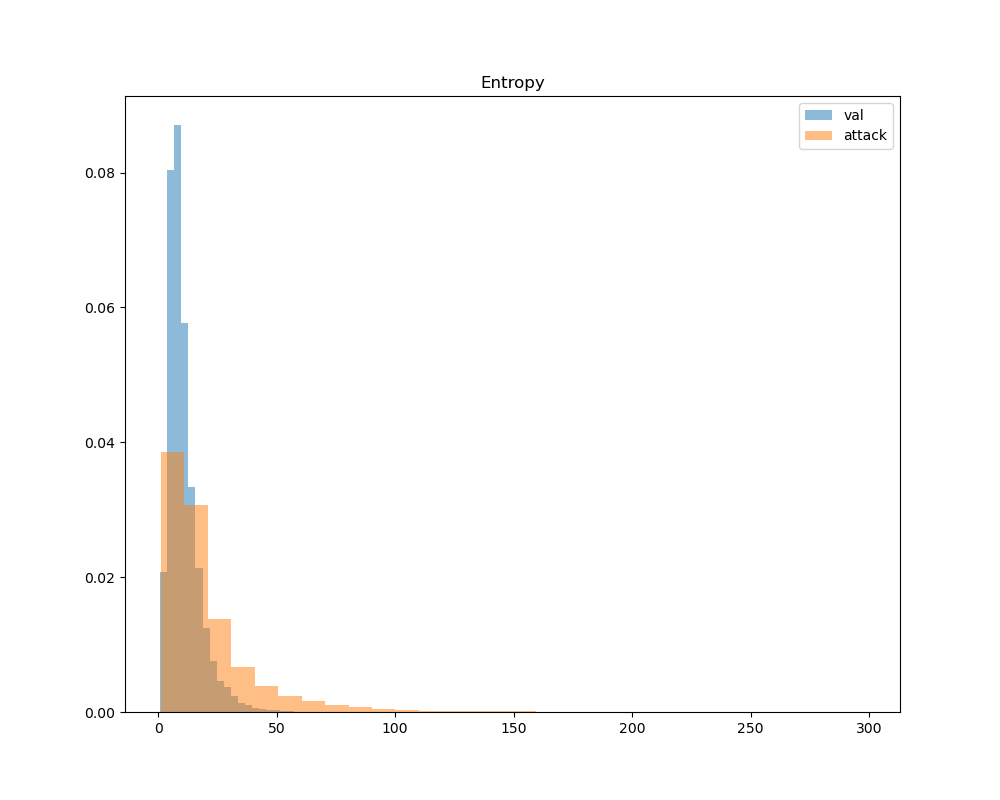

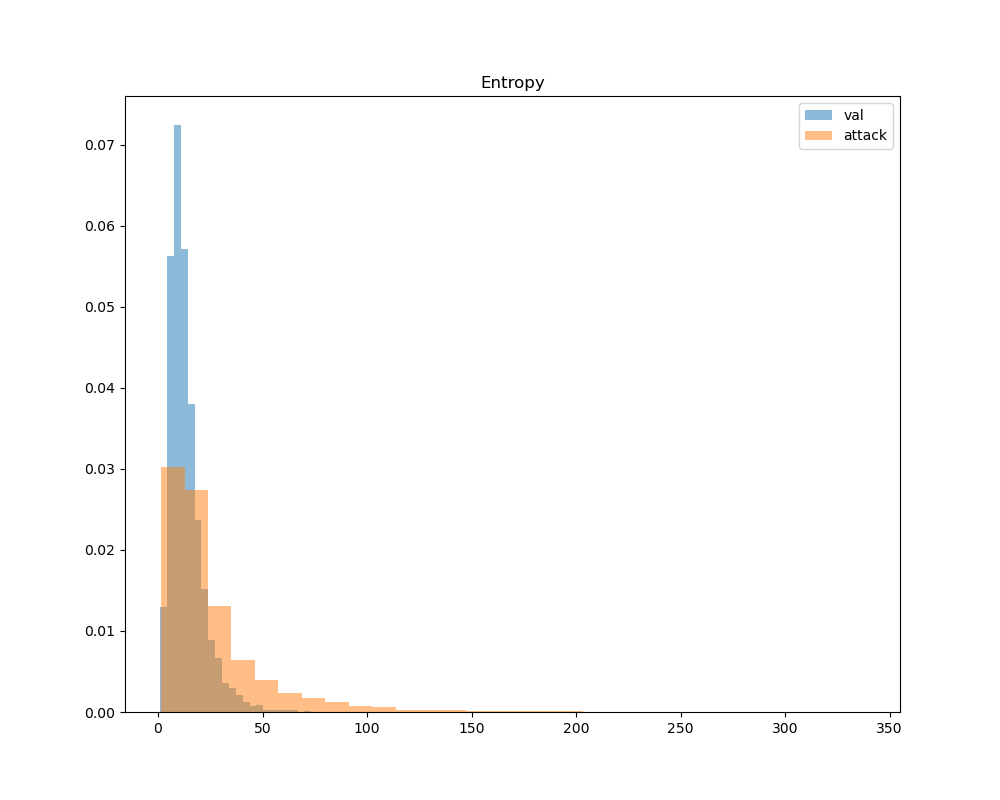

In [16]:

for n in num_clusters:
    for dim in dims_list:
        fig, axs = plt.subplots(1,figsize=(10,8))
        axs.hist(dict_min[(n,dim)], bins=50, density=True, alpha=0.5, label='val')
        axs.hist(dict_attack[(n,dim)], bins=30, density=True, alpha=0.5, label='attack')
        axs.set_title('Entropy')
        axs.legend()
        
        plt.show()

###### with likelihood

In [116]:
for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            score_v = np.min(dv, axis=1)
            score_a = np.min(da, axis=1)
            
            kde_scott = KDE(score_v, bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(score_v))
            lh_attack = -np.log(kde_scott.pdf(score_a))
            lh_attack = lh_attack[np.isfinite(lh_attack)]
    
            original_labels = np.zeros(len(lh_val))
            attack_labels = np.ones(len(lh_attack))
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if layer=='feat-24': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)
                        

In [117]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

##### Monitoring the Joint PDF

In [118]:
dict_matrix_attack = {}
dict_matrix_val = {}

In [119]:
for n in num_clusters:

    for dim in dims_list:
        
        matrix_val = np.zeros((len_val,len(layer_list)))
        matrix_attack = np.zeros((len_val,len(layer_list)))

        for i,layer in enumerate(layer_list):
        
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            score_v = np.min(dv, axis=1)
            score_a = np.min(da, axis=1)   
            
            matrix_attack[:,i] = score_a
            matrix_val[:,i] = score_v
            
        dict_matrix_attack[(dim,n)] = matrix_attack
        dict_matrix_val[(dim,n)] = matrix_val
                        

In [120]:
len(lh_attack[np.isfinite(lh_attack)])

9990

In [121]:
list_layers = ['clas3', 'clas0-3', 'feat28+clas0-3', 'feat26-28+clas0-3', 'feat24-26-28+clas0-3']

for i in range(1,6):
    
    data = []
    
    for n in num_clusters:
    
        for dim in dims_list:
    
            kde_scott = KDE(dict_matrix_val[(dim,n)].T[-i:], bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(dict_matrix_val[(dim,n)].T[-i:]))
            lh_attack = -np.log(kde_scott.pdf(dict_matrix_attack[(dim,n)].T[-i:]))
            lh_attack = lh_attack[np.isfinite(lh_attack)]
    
            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len(lh_attack))
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])            
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if i==1: # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)              

In [122]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

#### MAX with SOFTMIN

##### Monitoring layers separately

In [123]:
for layer in layer_list:
    
    data = []
    for n in num_clusters:

        for dim in dims_list:
            
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            _val = torch.Tensor(dv)
            _attack = torch.Tensor(da)

            pv = torch.nn.functional.softmin(_val, dim=1)
            pa = torch.nn.functional.softmin(_attack, dim=1)

            score_v = np.max(pv.detach().cpu().numpy(), axis=1)
            score_a = np.max(pa.detach().cpu().numpy(), axis=1)

            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([score_v, score_a])

            auc_ = AUC(y_true=y_true, y_score=y_score)
            
            data.append((dim, n, auc_))

    if layer=='feat-24': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', layer])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)
                        

In [124]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

##### Monitoring the Joint PDF

In [125]:
dict_matrix_attack = {}
dict_matrix_val = {}

In [126]:
for n in num_clusters:

    for dim in dims_list:
        
        matrix_val = np.zeros((len_val,len(layer_list)))
        matrix_attack = np.zeros((len_val,len(layer_list)))

        for i,layer in enumerate(layer_list):
        
            dv = dict_dist_val[(dim,n)][layer]
            da = dict_dist_attack[(dim,n)][layer]

            _val = torch.Tensor(dv)
            _attack = torch.Tensor(da)

            pv = torch.nn.functional.softmin(_val, dim=1)
            pa = torch.nn.functional.softmin(_attack, dim=1)

            score_v = np.max(pv.detach().cpu().numpy(), axis=1)
            score_a = np.max(pa.detach().cpu().numpy(), axis=1)    
            
            matrix_attack[:,i] = score_a
            matrix_val[:,i] = score_v
            
        dict_matrix_attack[(dim,n)] = matrix_attack
        dict_matrix_val[(dim,n)] = matrix_val
                        

In [127]:
list_layers = ['clas3', 'clas0-3', 'feat28+clas0-3', 'feat26-28+clas0-3', 'feat24-26-28+clas0-3']

for i in range(1,6):
    
    data = []
    
    for n in num_clusters:
    
        for dim in dims_list:
    
            kde_scott = KDE(dict_matrix_val[(dim,n)].T[-i:], bw_method='scott')
            lh_val = -np.log(kde_scott.pdf(dict_matrix_val[(dim,n)].T[-i:]))
            lh_attack = -np.log(kde_scott.pdf(dict_matrix_attack[(dim,n)].T[-i:]))
    
            original_labels = np.zeros(len_val)
            attack_labels = np.ones(len_val)
    
            y_true = np.concatenate([original_labels, attack_labels])
    
            y_score = np.concatenate([lh_val, lh_attack])
    
            auc_ = AUC(y_true=y_true, y_score=y_score)
    
            data.append((dim, n, auc_))

    if i==1: # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', list_layers[i-1]])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)              

In [128]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

#### Entropy

In [237]:
#KDE_silver = {}
KDE_scott = {}

for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
            
    data = []
    for dim in dims_list:
        for n in num_clusters:

            entropy_val = H(prob_val[(dim, n)],axis=1)
            entropy_attack = H(prob_attack[(dim, n)],axis=1)

            kde_scott = KDE(entropy_val, bw_method='scott')
            kde_silver = KDE(entropy_val, bw_method='silverman')
            KDE_scott[(dim,n)] = kde_scott
            #KDE_silver[(dim,n)] = kde_silver
            lh_val = -np.log(kde_scott.pdf(entropy_val))
            lh_attack = -np.log(kde_scott.pdf(entropy_attack))
            
            original_labels = np.zeros(len(entropy_val))
            attack_labels = np.ones(len(entropy_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([lh_val, lh_attack])

            auc_ = AUC(y_true=y_true, y_score=y_score)

            data.append((dim, n, auc_))
            

    if key=='feat-28': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

100%|█████████████████████████████████████████████| 5/5 [00:44<00:00,  8.99s/it]


10 10
10 15
10 20
10 50
10 120
10 150
15 10
15 15
15 20
15 50
15 120
15 150
20 10
20 15
20 20
20 50
20 120
20 150
25 10
25 15
25 20
25 50
25 120
25 150


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.61s/it]


10 10
10 15
10 20
10 50
10 120
10 150
15 10
15 15
15 20
15 50
15 120
15 150
20 10
20 15
20 20
20 50
20 120
20 150
25 10
25 15
25 20
25 50
25 120
25 150


100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.76s/it]


10 10
10 15
10 20
10 50
10 120
10 150
15 10
15 15
15 20
15 50
15 120
15 150
20 10
20 15
20 20
20 50
20 120
20 150
25 10
25 15
25 20
25 50
25 120
25 150


100%|█████████████████████████████████████████████| 5/5 [00:40<00:00,  8.14s/it]


10 10
10 15
10 20
10 50
10 120
10 150
15 10
15 15
15 20
15 50
15 120
15 150
20 10
20 15
20 20
20 50
20 120
20 150
25 10
25 15
25 20
25 50
25 120
25 150


In [238]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

In [71]:
dim = 15
n = 15

weights = [0, 1, 0]
ep = empirical_posterior[(dim, n)]
            
clv = clustering_labels_val_[(dim, n)]
cla = clustering_labels_attack[(dim, n)]

pv = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=clv, 
                   n_classes=num_classes)

pa = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=cla, 
                   n_classes=num_classes)

H_val = H(pv,axis=1)
H_attack = H(pa,axis=1)

kde_ = KDE(H_val, bw_method='scott')
#kde_silver = KDE(entropy_val, bw_method='silverman')
# kde_ = KDE_scott[(dim,n)]
#KDE_silver[(dim,n)] = kde_silver

#lh_val = -np.log(kde_.pdf(H_val))
#lh_attack = -np.log(kde_.pdf(H_attack))

eps_ = (np.max(H_val)-np.min(H_val))/1000
lh_val = 1- eps_ * kde_.pdf(H_val)
lh_attack = 1- eps_ * kde_.pdf(H_attack)

original_labels = np.zeros(len(H_val))
attack_labels = np.ones(len(H_attack))

y_true = np.concatenate([original_labels, attack_labels])

y_score = np.concatenate([lh_val, lh_attack])

auc_ = AUC(y_true=y_true, y_score=y_score)

In [72]:
auc_

0.8771670400000001

In [50]:
lh_val

array([0.9919186 , 0.9913739 , 0.99879185, ..., 0.99953338, 0.99317694,
       0.99612981])

In [51]:
lh_attack

array([0.99973839, 0.99973846, 0.99973855, ..., 0.99973853, 0.99973847,
       0.99973855])

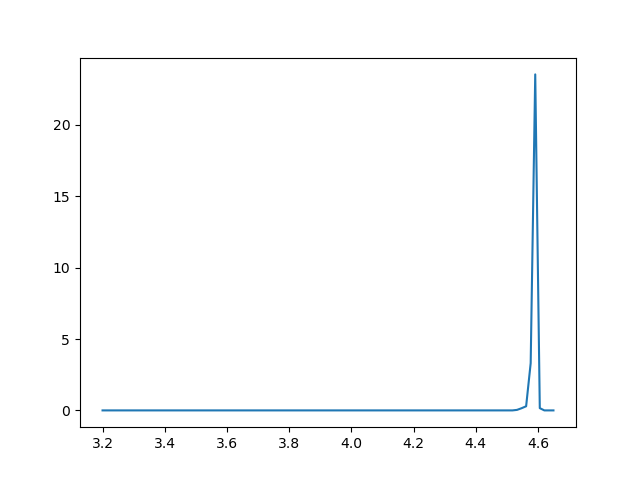

In [52]:
x_test = np.linspace(3.20,4.65,100)
y_test = kde_.pdf(x_test)
plt.figure()
plt.plot(x_test,y_test)

In [386]:
lh_val

array([0.01959335, 0.01842476, 0.01777447, ..., 0.00428635, 0.00019055,
       0.0001836 ])

In [387]:
lh_attack

array([0.01922021, 0.01963735, 0.01947592, ..., 0.01962754, 0.01820002,
       0.01962078])

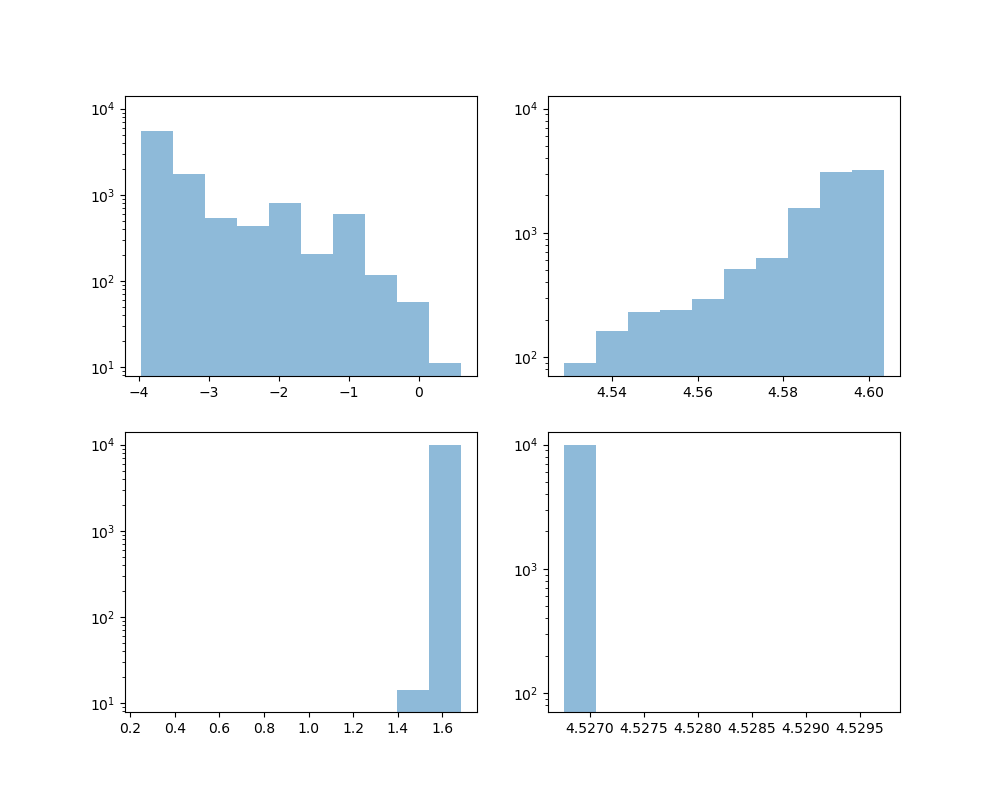

In [362]:
fig, axs = plt.subplots(2,2,figsize=(10,8),sharey='col')
axs[0,0].hist(lh_val, bins=10, alpha=0.5, label='val')
axs[1,0].hist(lh_attack, bins=10, alpha=0.5, label='attack')
axs[0,1].hist(H_val, bins=10, alpha=0.5, label='val')
axs[1,1].hist(H_attack, bins=10, alpha=0.5, label='attack')
for ax in axs.ravel(): 
    ax.set(yscale='log')

# axs.set_title('Entropy')
# axs.legend()

plt.show()

In [267]:
weights_eq = [1/3, 1/3, 1/3]
# weights_24 = [1, 0, 0, 0, 0]
# weights_26 = [0, 1, 0, 0, 0]
weights_28 = [1, 0, 0]
weights_0 = [0, 1, 0]
weights_3 = [0, 0, 1]
# weights_28 = [1, 0, 0]
weights_0_3 = [ 0, 0.5, 0.5]
weights_28_0 = [0.5, 0.5, 0]

# w_list = [weights_eq, weights_3, weights_0, weights_28]

w_dict = {#'equal' : weights_eq, 
          'feat-28' : weights_28,
          'clas-3' : weights_3, 
          'clas-0' : weights_0, 
          'clas-0-3' : weights_0_3, 
          'feat-28-clas-0' : weights_28_0
         }

In [268]:
#KDE_silver = {}
KDE_scott = {}

for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
            
    data = []
    data_1 = []
    for dim in dims_list:
        for n in num_clusters:

            entropy_val = H(prob_val[(dim, n)],axis=1)
            entropy_attack = H(prob_attack[(dim, n)],axis=1)

            kde_scott = KDE(entropy_val, bw_method='scott')
            kde_silver = KDE(entropy_val, bw_method='silverman')
            KDE_scott[(dim,n)] = kde_scott

            lh_val = -np.log(kde_scott.pdf(entropy_val))
            lh_attack = -np.log(kde_scott.pdf(entropy_attack))
            
            original_labels = np.zeros(len(entropy_val))
            attack_labels = np.ones(len(entropy_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([lh_val, lh_attack])
            auc_ = AUC(y_true=y_true, y_score=y_score)
            data.append((dim, n, auc_))
            

            y_score_1 = np.concatenate([entropy_val, entropy_attack])
            auc_1 = AUC(y_true=y_true, y_score=y_score_1)
            data_1.append((dim, n, auc_1))
            

    if key=='feat-28': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

    if key=='feat-28': # starting building results dataframe
        df1 = pd.DataFrame(data_1, columns=['dim', 'n_clusters', key])
        df1.set_index(['dim', 'n_clusters'], inplace=True)
        df1.sort_index(inplace=True)
    else: # concatenate with previous results
        df_1 = pd.DataFrame(data_1, columns=['dim', 'n_clusters', key])
        df_1.set_index(['dim', 'n_clusters'], inplace=True)
        df_1.sort_index(inplace=True)
        df1 = df1.join(df_1)

100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.61s/it]


In [255]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

In [256]:
df1.style.background_gradient(subset=df1.columns, cmap=cmap, vmin=0.5, vmax=1)

In [259]:
from IPython.display import display, HTML

In [284]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [270]:
# Assuming that dataframes df1 and df2 are already defined
display_side_by_side(df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1), df1.style.background_gradient(subset=df1.columns, cmap=cmap, vmin=0.5, vmax=1))

feat-28 
 clas-3 
 clas-0 
 clas-0-3 
 feat-28-clas-0 
 
 
 dim 
 n_clusters 
   
   
   
   
   
 
 
 
 
 10 
 10 
 0.997200 
 0.416554 
 0.595190 
 0.404667 
 0.958397 
 
 
 15 
 1.000000 
 0.408350 
 0.381007 
 0.260942 
 0.964342 
 
 
 20 
 0.969196 
 0.349976 
 0.611781 
 0.366266 
 0.886978 
 
 
 50 
 0.983389 
 0.380727 
 0.944891 
 0.841886 
 0.977734 
 
 
 120 
 1.000000 
 0.405590 
 0.879286 
 0.766785 
 0.998536 
 
 
 150 
 0.971575 
 0.403940 
 0.646038 
 0.429146 
 0.929717 
 
 
 15 
 10 
 0.827671 
 0.384534 
 0.460977 
 0.378942 
 0.664813 
 
 
 15 
 0.990300 
 0.369356 
 0.877167 
 0.805370 
 0.941161 
 
 
 20 
 0.980989 
 0.377243 
 0.168614 
 0.252891 
 0.796498 
 
 
 50 
 0.993796 
 0.362850 
 0.269645 
 0.233981 
 0.946179 
 
 
 120 
 0.962683 
 0.346987 
 0.418500 
 0.207358 
 0.861098 
 
 
 150 
 0.960385 
 0.346115 
 0.513332 
 0.290239 
 0.848397 
 
 
 20 
 10 
 0.885284 
 0.394569 
 0.177929 
 0.359905 
 0.453929 
 
 
 15 
 0.973943 
 0.340657 
 0.255465 
 0.257619 
 0.769087 
 
 
 20 
 0.943395 
 0.381785 
 0.472877 
 0.451445 
 0.736370 
 
 
 50 
 0.990505 
 0.351598 
 0.439413 
 0.256901 
 0.934429 
 
 
 120 
 0.991978 
 0.335649 
 0.256916 
 0.201591 
 0.892228 
 
 
 150 
 0.998887 
 0.332330 
 0.394020 
 0.216556 
 0.959083 
 
 
 25 
 10 
 0.989048 
 0.420659 
 0.798498 
 0.684216 
 0.971151 
 
 
 15 
 0.850800 
 0.416767 
 0.499891 
 0.403699 
 0.691149 
 
 
 20 
 0.900599 
 0.437974 
 0.488881 
 0.441824 
 0.691977 
 
 
 50 
 0.988626 
 0.388311 
 0.305205 
 0.293079 
 0.897486 
 
 
 120 
 0.743778 
 0.331261 
 0.545193 
 0.321466 
 0.586334 
 
 
 150 
 0.974162 
 0.336976 
 0.369997 
 0.287152 
 0.865687 
 
 
 30 
 10 
 0.787492 
 0.474961 
 0.327762 
 0.390337 
 0.403557 
 
 
 15 
 0.843641 
 0.353930 
 0.780102 
 0.700211 
 0.783168 
 
 
 20 
 1.000000 
 0.425239 
 0.544690 
 0.502449 
 0.967911 
 
 
 50 
 0.927486 
 0.431236 
 0.575064 
 0.449001 
 0.799172 
 
 
 120 
 0.937142 
 0.375208 
 0.746575 
 0.582194 
 0.871948 
 
 
 150 
 0.787107 
 0.370660 
 0.262649 
 0.288323 
 0.448660 
 
 
 

 
 
 
   
   
 feat-28 
 clas-3 
 clas-0 
 clas-0-3 
 feat-28-clas-0 
 
 
 dim 
 n_clusters 
   
   
   
   
   
 
 
 
 
 10 
 10 
 0.012400 
 0.573977 
 0.338583 
 0.497470 
 0.042189 
 
 
 15 
 0.000000 
 0.603762 
 0.515166 
 0.659148 
 0.035669 
 
 
 20 
 0.030804 
 0.701798 
 0.331049 
 0.529345 
 0.112822 
 
 
 50 
 0.026909 
 0.686464 
 0.054766 
 0.148288 
 0.022330 
 
 
 120 
 0.000300 
 0.723898 
 0.119969 
 0.223742 
 0.002751 
 
 
 150 
 0.028425 
 0.743536 
 0.322395 
 0.449479 
 0.070295 
 
 
 15 
 10 
 0.172329 
 0.639588 
 0.364567 
 0.492711 
 0.288719 
 
 
 15 
 0.009700 
 0.670796 
 0.113748 
 0.174804 
 0.058672 
 
 
 20 
 0.029511 
 0.646299 
 0.497935 
 0.640145 
 0.203470 
 
 
 50 
 0.005546 
 0.709217 
 0.553341 
 0.738173 
 0.053821 
 
 
 120 
 0.037317 
 0.767855 
 0.489301 
 0.657085 
 0.138902 
 
 
 150 
 0.039615 
 0.762028 
 0.412355 
 0.569478 
 0.151603 
 
 
 20 
 10 
 0.114116 
 0.690451 
 0.796220 
 0.827506 
 0.434896 
 
 
 15 
 0.041546 
 0.705383 
 0.650326 
 0.738182 
 0.219065 
 
 
 20 
 0.056605 
 0.644169 
 0.464723 
 0.578237 
 0.250595 
 
 
 50 
 0.012895 
 0.733866 
 0.487819 
 0.669189 
 0.065571 
 
 
 120 
 0.014114 
 0.766797 
 0.588537 
 0.721427 
 0.107772 
 
 
 150 
 0.004606 
 0.755541 
 0.496532 
 0.653233 
 0.040977 
 
 
 25 
 10 
 0.021845 
 0.681362 
 0.191437 
 0.269165 
 0.027871 
 
 
 15 
 0.149100 
 0.608824 
 0.441832 
 0.511400 
 0.262034 
 
 
 20 
 0.099401 
 0.580466 
 0.516939 
 0.547806 
 0.274114 
 
 
 50 
 0.014617 
 0.726205 
 0.581951 
 0.643844 
 0.102518 
 
 
 120 
 0.256222 
 0.763404 
 0.401894 
 0.585718 
 0.387833 
 
 
 150 
 0.025799 
 0.755450 
 0.569704 
 0.706197 
 0.134313 
 
 
 30 
 10 
 0.195106 
 0.510999 
 0.641165 
 0.579806 
 0.445828 
 
 
 15 
 0.156359 
 0.701773 
 0.196489 
 0.269938 
 0.189340 
 
 
 20 
 0.000000 
 0.599465 
 0.395302 
 0.426305 
 0.031871 
 
 
 50 
 0.072514 
 0.713852 
 0.384327 
 0.533688 
 0.19

In [402]:
#KDE_silver = {}
KDE_scott = {}

for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
            
    data = []
    data_1 = []
    for dim in dims_list:
        for n in num_clusters:

            entropy_val = H(prob_val[(dim, n)],axis=1)
            entropy_attack = H(prob_attack[(dim, n)],axis=1)

            kde_scott = KDE(entropy_val, bw_method='scott')
            kde_silver = KDE(entropy_val, bw_method='silverman')
            KDE_scott[(dim,n)] = kde_scott
            eps_ = (np.max(H_val)-np.min(H_val))/1000
            lh_val = eps_ * kde_scott.pdf(H_val)
            lh_attack = eps_ * kde_scott.pdf(H_attack)
            
            original_labels = np.zeros(len(entropy_val))
            attack_labels = np.ones(len(entropy_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([lh_val, lh_attack])
            auc_ = AUC(y_true=y_true, y_score=y_score)
            
            data.append((dim, n, auc_))
            
            lh_val = 1 - eps_ * kde_scott.pdf(H_val)
            lh_attack = 1 - eps_ * kde_scott.pdf(H_attack)

            y_score_1 = np.concatenate([lh_val, lh_attack])
            auc_1 = AUC(y_true=y_true, y_score=y_score_1)
            
            data_1.append((dim, n, auc_1))
            

    if key=='feat-28': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

    if key=='feat-28': # starting building results dataframe
        df1 = pd.DataFrame(data_1, columns=['dim', 'n_clusters', key])
        df1.set_index(['dim', 'n_clusters'], inplace=True)
        df1.sort_index(inplace=True)
    else: # concatenate with previous results
        df_1 = pd.DataFrame(data_1, columns=['dim', 'n_clusters', key])
        df_1.set_index(['dim', 'n_clusters'], inplace=True)
        df_1.sort_index(inplace=True)
        df1 = df1.join(df_1)



  0%|                                                     | 0/5 [00:00<?, ?it/s]

 20%|█████████                                    | 1/5 [00:07<00:29,  7.28s/it]

 40%|██████████████████                           | 2/5 [00:14<00:21,  7.21s/it]

 60%|███████████████████████████                  | 3/5 [00:21<00:14,  7.23s/it]

 80%|████████████████████████████████████         | 4/5 [00:28<00:07,  7.28s/it]

100%|█████████████████████████████████████████████| 5/5 [00:35<00:00,  7.19s/it]

  0%|                                                     | 0/5 [00:00<?, ?it/s]

 20%|█████████                                    | 1/5 [00:07<00:29,  7.27s/it]

 40%|██████████████████                           | 2/5 [00:14<00:21,  7.20s/it]

 60%|███████████████████████████                  | 3/5 [00:21<00:14,  7.15s/it]

 80%|████████████████████████████████████         | 4/5 [00:28<00:07,  7.26s/it]

100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.30s/it]

  0%|         

In [403]:
# Assuming that dataframes df1 and df2 are already defined
display_side_by_side(df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1), df1.style.background_gradient(subset=df1.columns, cmap=cmap, vmin=0.5, vmax=1))

feat-28 
 clas-3 
 clas-0 
 clas-0-3 
 feat-28-clas-0 
 
 
 dim 
 n_clusters 
   
   
   
   
   
 
 
 
 
 10 
 10 
 0.701937 
 0.701952 
 0.688498 
 0.701288 
 0.700836 
 
 
 15 
 0.701543 
 0.663518 
 0.697936 
 0.702395 
 0.701907 
 
 
 20 
 0.687562 
 0.650024 
 0.580334 
 0.701627 
 0.700424 
 
 
 50 
 0.658430 
 0.504395 
 0.361682 
 0.596311 
 0.664281 
 
 
 120 
 0.523391 
 0.438857 
 0.379572 
 0.609853 
 0.618924 
 
 
 150 
 0.471083 
 0.423657 
 0.376128 
 0.567788 
 0.580365 
 
 
 15 
 10 
 0.701274 
 0.701217 
 0.552423 
 0.702515 
 0.701826 
 
 
 15 
 0.676489 
 0.687052 
 0.400872 
 0.663518 
 0.672487 
 
 
 20 
 0.685921 
 0.626226 
 0.505691 
 0.698128 
 0.699815 
 
 
 50 
 0.542151 
 0.392277 
 0.417926 
 0.608476 
 0.646414 
 
 
 120 
 0.421899 
 0.343317 
 0.331751 
 0.497416 
 0.523288 
 
 
 150 
 0.400025 
 0.326052 
 0.317864 
 0.443647 
 0.474985 
 
 
 20 
 10 
 0.701171 
 0.698316 
 0.684201 
 0.701437 
 0.701353 
 
 
 15 
 0.702239 
 0.698095 
 0.690071 
 0.701246 
 0.701896 
 
 
 20 
 0.668544 
 0.510873 
 0.521104 
 0.688450 
 0.695553 
 
 
 50 
 0.446977 
 0.347244 
 0.324279 
 0.487704 
 0.472418 
 
 
 120 
 0.339406 
 0.305306 
 0.308684 
 0.370187 
 0.378748 
 
 
 150 
 0.326914 
 0.303232 
 0.298857 
 0.329870 
 0.339564 
 
 
 25 
 10 
 0.700354 
 0.674711 
 0.661932 
 0.690554 
 0.701102 
 
 
 15 
 0.679276 
 0.492296 
 0.503749 
 0.668697 
 0.696030 
 
 
 20 
 0.647990 
 0.425527 
 0.402112 
 0.615207 
 0.667278 
 
 
 50 
 0.430690 
 0.323042 
 0.310135 
 0.409650 
 0.446634 
 
 
 120 
 0.340442 
 0.301622 
 0.298392 
 0.316762 
 0.330112 
 
 
 150 
 0.318337 
 0.298343 
 0.298291 
 0.306238 
 0.319366 
 
 
 30 
 10 
 0.667824 
 0.562239 
 0.700193 
 0.700154 
 0.701872 
 
 
 15 
 0.699502 
 0.691840 
 0.534988 
 0.695869 
 0.699054 
 
 
 20 
 0.570911 
 0.402131 
 0.442595 
 0.627932 
 0.651419 
 
 
 50 
 0.384169 
 0.305356 
 0.299772 
 0.319553 
 0.364503 
 
 
 120 
 0.308302 
 0.298286 
 0.298210 
 0.299896 
 0.304727 
 
 
 150 
 0.313700 
 0.298236 
 0.298212 
 0.303003 
 0.307243 
 
 
 

 
 
 
   
   
 feat-28 
 clas-3 
 clas-0 
 clas-0-3 
 feat-28-clas-0 
 
 
 dim 
 n_clusters 
   
   
   
   
   
 
 
 
 
 10 
 10 
 0.298059 
 0.298052 
 0.311499 
 0.298728 
 0.299266 
 
 
 15 
 0.298459 
 0.336481 
 0.302064 
 0.297607 
 0.298096 
 
 
 20 
 0.312438 
 0.349976 
 0.419666 
 0.298373 
 0.299576 
 
 
 50 
 0.341570 
 0.495605 
 0.638318 
 0.403689 
 0.335719 
 
 
 120 
 0.476609 
 0.561143 
 0.620428 
 0.390147 
 0.381076 
 
 
 150 
 0.528917 
 0.576343 
 0.623872 
 0.432212 
 0.419635 
 
 
 15 
 10 
 0.298736 
 0.298784 
 0.447575 
 0.297496 
 0.298334 
 
 
 15 
 0.323509 
 0.312948 
 0.599128 
 0.336484 
 0.327515 
 
 
 20 
 0.314081 
 0.373774 
 0.494309 
 0.301872 
 0.300185 
 
 
 50 
 0.457849 
 0.607723 
 0.582074 
 0.391524 
 0.353586 
 
 
 120 
 0.578101 
 0.656683 
 0.668249 
 0.502584 
 0.476712 
 
 
 150 
 0.599975 
 0.673948 
 0.682136 
 0.556353 
 0.525015 
 
 
 20 
 10 
 0.298842 
 0.301682 
 0.315798 
 0.298577 
 0.298796 
 
 
 15 
 0.297758 
 0.301905 
 0.309930 
 0.298753 
 0.298116 
 
 
 20 
 0.331456 
 0.489127 
 0.478896 
 0.311550 
 0.304447 
 
 
 50 
 0.553023 
 0.652756 
 0.675721 
 0.512296 
 0.527582 
 
 
 120 
 0.660594 
 0.694694 
 0.691316 
 0.629813 
 0.621252 
 
 
 150 
 0.673086 
 0.696768 
 0.701143 
 0.670130 
 0.660436 
 
 
 25 
 10 
 0.299645 
 0.325287 
 0.338067 
 0.310401 
 0.298918 
 
 
 15 
 0.320724 
 0.507706 
 0.496251 
 0.331304 
 0.303971 
 
 
 20 
 0.352010 
 0.574473 
 0.597888 
 0.384793 
 0.332722 
 
 
 50 
 0.569310 
 0.676958 
 0.689865 
 0.590350 
 0.553366 
 
 
 120 
 0.659558 
 0.698378 
 0.701608 
 0.683238 
 0.669888 
 
 
 150 
 0.681663 
 0.701657 
 0.701709 
 0.693762 
 0.680634 
 
 
 30 
 10 
 0.332175 
 0.437765 
 0.299805 
 0.300102 
 0.298142 
 
 
 15 
 0.300499 
 0.308160 
 0.465012 
 0.304135 
 0.300945 
 
 
 20 
 0.429089 
 0.597869 
 0.557405 
 0.372066 
 0.348584 
 
 
 50 
 0.615831 
 0.694644 
 0.700228 
 0.680447 
 0.63

#### MAX

In [240]:
#KDE_silver = {}
KDE_scott = {}

for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
            
    data = []
    for dim in dims_list[:-1]:
        for n in num_clusters:

            max_val = np.max(prob_val[(dim, n)],axis=1)
            max_attack = np.max(prob_attack[(dim, n)],axis=1)

            kde_scott = KDE(max_val, bw_method='scott')
            kde_silver = KDE(max_val, bw_method='silverman')
            KDE_scott[(dim,n)] = kde_scott
            #KDE_silver[(dim,n)] = kde_silver
            lh_val = -np.log(kde_scott.pdf(max_val))
            lh_attack = -np.log(kde_scott.pdf(max_attack))
            
            original_labels = np.zeros(len(max_val))
            attack_labels = np.ones(len(max_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([lh_val, lh_attack])
            
            auc_ = AUC(y_true=y_true, y_score=y_score)

            data.append((dim, n, auc_))

    if key=='feat-28': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

100%|█████████████████████████████████████████████| 5/5 [00:41<00:00,  8.37s/it]


In [ ]:
y_score, max_val, max_attack

In [241]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

In [289]:
#KDE_silver = {}
KDE_scott = {}

for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
            
    data = []
    data_1 = []
    for dim in dims_list:
        for n in num_clusters:

            max_val = np.max(prob_val[(dim, n)],axis=1)
            max_attack = np.max(prob_attack[(dim, n)],axis=1)

            kde_scott = KDE(max_val, bw_method='scott')
            kde_silver = KDE(max_val, bw_method='silverman')
            KDE_scott[(dim,n)] = kde_scott
            #KDE_silver[(dim,n)] = kde_silver
            lh_val = -np.log(kde_scott.pdf(max_val))
            lh_attack = -np.log(kde_scott.pdf(max_attack))
            
            original_labels = np.zeros(len(max_val))
            attack_labels = np.ones(len(max_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([lh_val, lh_attack])
            
            auc_ = AUC(y_true=y_true, y_score=y_score)

            data.append((dim, n, auc_))

            y_score = np.concatenate([max_val, max_attack])

            auc_1 = AUC(y_true=y_true, y_score=y_score)

            data_1.append((dim, n, auc_1))

    if key=='feat-28': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

    if key=='feat-28': # starting building results dataframe
        df1 = pd.DataFrame(data_1, columns=['dim', 'n_clusters', key])
        df1.set_index(['dim', 'n_clusters'], inplace=True)
        df1.sort_index(inplace=True)
    else: # concatenate with previous results
        df_1 = pd.DataFrame(data_1, columns=['dim', 'n_clusters', key])
        df_1.set_index(['dim', 'n_clusters'], inplace=True)
        df_1.sort_index(inplace=True)
        df1 = df1.join(df_1)



  0%|                                                     | 0/5 [00:00<?, ?it/s]

 20%|█████████                                    | 1/5 [00:09<00:36,  9.13s/it]

 40%|██████████████████                           | 2/5 [00:17<00:26,  8.80s/it]

 60%|███████████████████████████                  | 3/5 [00:25<00:17,  8.52s/it]

 80%|████████████████████████████████████         | 4/5 [00:31<00:08,  8.05s/it]

100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.66s/it]

  0%|                                                     | 0/5 [00:00<?, ?it/s]

 20%|█████████                                    | 1/5 [00:07<00:30,  7.70s/it]

 40%|██████████████████                           | 2/5 [00:16<00:23,  7.93s/it]

 60%|███████████████████████████                  | 3/5 [00:24<00:16,  8.19s/it]

 80%|████████████████████████████████████         | 4/5 [00:32<00:08,  8.03s/it]

100%|█████████████████████████████████████████████| 5/5 [00:40<00:00,  8.07s/it]

  0%|         

In [291]:
# Assuming that dataframes df1 and df2 are already defined
display_side_by_side(df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1), df1.style.background_gradient(subset=df1.columns, cmap=cmap, vmin=0.5, vmax=1))

feat-28 
 clas-3 
 clas-0 
 clas-0-3 
 feat-28-clas-0 
 
 
 dim 
 n_clusters 
   
   
   
   
   
 
 
 
 
 10 
 10 
 0.995100 
 0.456573 
 0.494994 
 0.318164 
 0.884298 
 
 
 15 
 0.994702 
 0.393533 
 0.308445 
 0.353545 
 0.929198 
 
 
 20 
 0.908300 
 0.360271 
 0.698384 
 0.502600 
 0.859902 
 
 
 50 
 0.961286 
 0.406405 
 0.868466 
 0.675275 
 0.952690 
 
 
 120 
 1.000000 
 0.387728 
 0.884607 
 0.738816 
 0.999493 
 
 
 150 
 0.942047 
 0.360681 
 0.572946 
 0.450940 
 0.847689 
 
 
 15 
 10 
 0.860798 
 0.442089 
 0.450253 
 0.492448 
 0.454656 
 
 
 15 
 0.991000 
 0.383282 
 0.790651 
 0.690447 
 0.922115 
 
 
 20 
 0.978082 
 0.413554 
 0.219416 
 0.265741 
 0.644889 
 
 
 50 
 0.971936 
 0.381475 
 0.267420 
 0.258116 
 0.911869 
 
 
 120 
 0.974899 
 0.324772 
 0.544654 
 0.340970 
 0.917860 
 
 
 150 
 0.924821 
 0.326953 
 0.388696 
 0.281701 
 0.738227 
 
 
 20 
 10 
 0.917193 
 0.412112 
 0.149405 
 0.346644 
 0.272647 
 
 
 15 
 0.879974 
 0.374294 
 0.268390 
 0.287532 
 0.528215 
 
 
 20 
 0.825082 
 0.423807 
 0.467620 
 0.505244 
 0.690446 
 
 
 50 
 0.940061 
 0.384136 
 0.410730 
 0.269103 
 0.814546 
 
 
 120 
 0.976230 
 0.401914 
 0.384852 
 0.276455 
 0.873206 
 
 
 150 
 0.991582 
 0.390542 
 0.418744 
 0.262794 
 0.883474 
 
 
 25 
 10 
 0.927600 
 0.477008 
 0.685100 
 0.365465 
 0.918460 
 
 
 15 
 0.656794 
 0.431075 
 0.523110 
 0.333870 
 0.522991 
 
 
 20 
 0.952200 
 0.414024 
 0.469183 
 0.371475 
 0.682408 
 
 
 50 
 0.990399 
 0.472358 
 0.497601 
 0.308527 
 0.933177 
 
 
 120 
 0.595588 
 0.371725 
 0.556726 
 0.334992 
 0.426908 
 
 
 150 
 0.952111 
 0.386052 
 0.502641 
 0.407437 
 0.794283 
 
 
 30 
 10 
 0.686149 
 0.520113 
 0.433317 
 0.471049 
 0.350721 
 
 
 15 
 0.843789 
 0.392440 
 0.768633 
 0.649652 
 0.640150 
 
 
 20 
 0.990196 
 0.445416 
 0.575168 
 0.492289 
 0.867747 
 
 
 50 
 0.883449 
 0.465301 
 0.608680 
 0.483890 
 0.682835 
 
 
 120 
 0.941763 
 0.459454 
 0.661650 
 0.476378 
 0.751501 
 
 
 150 
 0.690310 
 0.471042 
 0.296062 
 0.418435 
 0.188911 
 
 
 

 
 
 
   
   
 feat-28 
 clas-3 
 clas-0 
 clas-0-3 
 feat-28-clas-0 
 
 
 dim 
 n_clusters 
   
   
   
   
   
 
 
 
 
 10 
 10 
 0.982500 
 0.470492 
 0.601016 
 0.413769 
 0.902309 
 
 
 15 
 0.993699 
 0.393806 
 0.434257 
 0.352820 
 0.932879 
 
 
 20 
 0.918000 
 0.277496 
 0.744471 
 0.595697 
 0.873548 
 
 
 50 
 0.961386 
 0.342488 
 0.889409 
 0.733278 
 0.954239 
 
 
 120 
 0.999900 
 0.287357 
 0.885837 
 0.760484 
 0.998205 
 
 
 150 
 0.942047 
 0.277595 
 0.619774 
 0.534871 
 0.851274 
 
 
 15 
 10 
 0.880998 
 0.365275 
 0.503670 
 0.465355 
 0.628135 
 
 
 15 
 0.992400 
 0.345887 
 0.834537 
 0.749815 
 0.932133 
 
 
 20 
 0.978682 
 0.347865 
 0.415743 
 0.340662 
 0.712025 
 
 
 50 
 0.972036 
 0.310608 
 0.373146 
 0.278976 
 0.913904 
 
 
 120 
 0.974899 
 0.265599 
 0.597037 
 0.434670 
 0.918116 
 
 
 150 
 0.924821 
 0.264142 
 0.486002 
 0.383517 
 0.749278 
 
 
 20 
 10 
 0.932094 
 0.320656 
 0.233744 
 0.207131 
 0.430898 
 
 
 15 
 0.894575 
 0.314728 
 0.411491 
 0.312654 
 0.647936 
 
 
 20 
 0.850682 
 0.386383 
 0.544929 
 0.455961 
 0.740508 
 
 
 50 
 0.941661 
 0.273003 
 0.521413 
 0.332235 
 0.837400 
 
 
 120 
 0.976230 
 0.271811 
 0.465558 
 0.334593 
 0.876362 
 
 
 150 
 0.988285 
 0.304324 
 0.508611 
 0.388681 
 0.885742 
 
 
 25 
 10 
 0.934100 
 0.369612 
 0.783037 
 0.558113 
 0.929654 
 
 
 15 
 0.730697 
 0.451068 
 0.572664 
 0.421639 
 0.627038 
 
 
 20 
 0.956100 
 0.401267 
 0.438529 
 0.390092 
 0.748732 
 
 
 50 
 0.984199 
 0.281739 
 0.570445 
 0.381720 
 0.934667 
 
 
 120 
 0.627300 
 0.251299 
 0.623763 
 0.451596 
 0.529234 
 
 
 150 
 0.952112 
 0.268327 
 0.547279 
 0.368389 
 0.807135 
 
 
 30 
 10 
 0.767498 
 0.407996 
 0.333562 
 0.400505 
 0.538094 
 
 
 15 
 0.860191 
 0.299776 
 0.846644 
 0.728320 
 0.735035 
 
 
 20 
 0.990997 
 0.418205 
 0.687972 
 0.597187 
 0.892429 
 
 
 50 
 0.887372 
 0.306938 
 0.635404 
 0.522649 
 0.73

In [373]:
dim = 10
n = 120

weights = [0, 0, 1]
ep = empirical_posterior[(dim, n)]
            
clv = clustering_labels_val_[(dim, n)]
cla = clustering_labels_attack[(dim, n)]

pv = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=clv, 
                   n_classes=num_classes)

pa = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=cla, 
                   n_classes=num_classes)

H_val = H(pv,axis=1)
H_attack = H(pa,axis=1)

kde_ = KDE(H_val, bw_method='scott')
#kde_silver = KDE(entropy_val, bw_method='silverman')
# kde_ = KDE_scott[(dim,n)]
#KDE_silver[(dim,n)] = kde_silver

lh_val = -np.log(kde_.pdf(H_val))
lh_attack = -np.log(kde_.pdf(H_attack))
#lh_val = kde_.pdf(H_val)
#lh_attack = kde_.pdf(H_attack)

original_labels = np.zeros(len(H_val))
attack_labels = np.ones(len(H_attack))

y_true = np.concatenate([original_labels, attack_labels])

y_score = np.concatenate([lh_val, lh_attack])

auc_ = AUC(y_true=y_true, y_score=y_score)

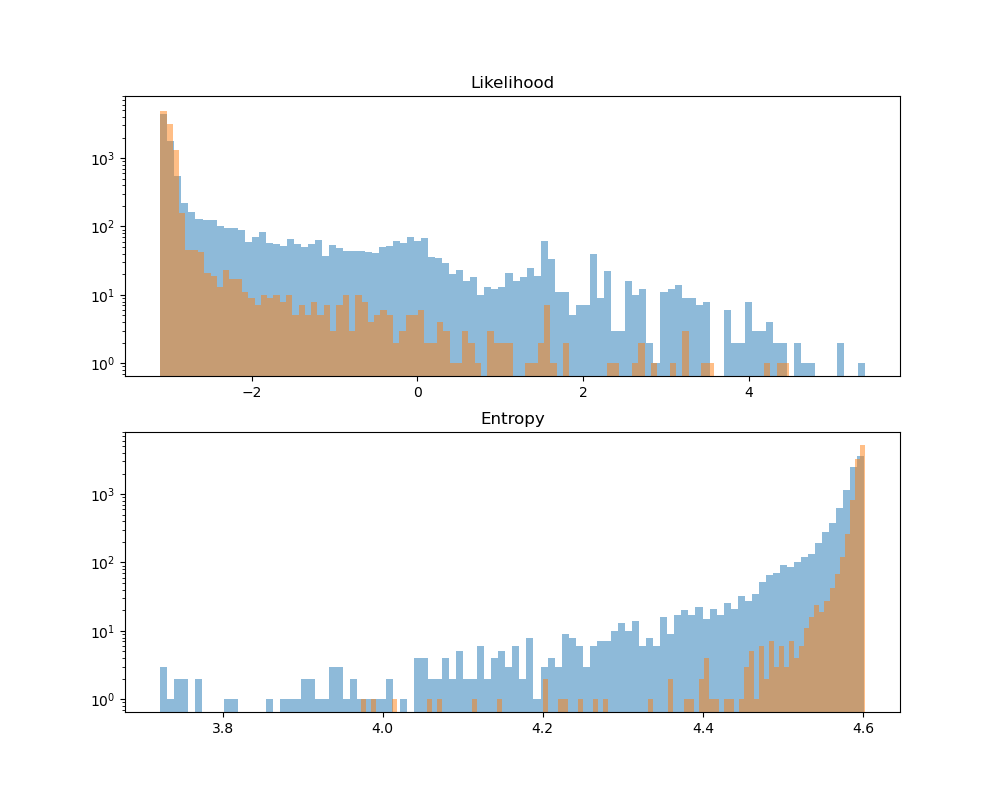

In [380]:
fig, axs = plt.subplots(2,figsize=(10,8),sharey='col')
axs[0].hist(lh_val, bins=100, alpha=0.5, label='val')
axs[0].hist(lh_attack, bins=100, alpha=0.5, label='attack')
axs[0].set_title('Likelihood')
axs[1].hist(H_val, bins=100, alpha=0.5, label='val')
axs[1].hist(H_attack, bins=100, alpha=0.5, label='attack')
axs[1].set_title('Entropy')
for ax in axs.ravel(): 
    ax.set(yscale='log')

# axs.set_title('Entropy')
# axs.legend()

plt.show()

In [290]:
df1.style.background_gradient(subset=df1.columns, cmap=cmap, vmin=0.5, vmax=1)

In [285]:
# Assuming that dataframes df1 and df2 are already defined
display_side_by_side(df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1), df1.style.background_gradient(subset=df1.columns, cmap=cmap, vmin=0.5, vmax=1))

KeyError: '`Styler.apply` and `.applymap` are not compatible with non-unique index or columns.'

In [164]:
 np.min(entropy_val), np.max(entropy_val)

(1.4497387048539818, 4.597751027359278)

In [158]:
KDE_scott[(dim,n)].factor

0.15848931924611134

In [161]:
KDE_scott[(dim,n)].evaluate(entropy_val), KDE_scott[(dim,n)].evaluate(entropy_attack)

(array([3.6191688 , 0.55280571, 4.43747003, ..., 0.54991394, 1.84341916,
        3.65622878]),
 array([3.69106136, 5.20773191, 0.66947165, ..., 4.62981763, 4.19540288,
        2.17825507]))

In [165]:
KDE_scott[(dim,n)].pdf( np.min(entropy_val)), KDE_scott[(dim,n)].pdf(np.max(entropy_val))

(array([0.00211589]), array([3.30760126]))

In [166]:
np.min(KDE_scott[(dim,n)].pdf(entropy_val)), np.max(KDE_scott[(dim,n)].pdf(entropy_val))

(0.0012280994702100218, 5.257265400022477)

In [167]:
kde_ = KDE_scott[(dim,n)]

In [157]:
entropy_val[0], entropy_attack[0]

(4.593767272486071, 4.59282636609542)

In [173]:
likelihood = -np.log(kde_.pdf(entropy_val[0]))
likelihood

array([-1.28624439])

In [174]:
likelihood = -np.log(kde_.pdf(entropy_attack[0]))
likelihood

array([-1.30591405])

Now we need clustering labels to compute predict_proba based on weights

In [114]:
#weights_eq = [1/3, 1/3, 1/3]
# weights_24 = [1, 0, 0, 0, 0]
# weights_26 = [0, 1, 0, 0, 0]
#weights_28 = [1, 0, 0]
weights_0 = [0, 1, 0]
weights_3 = [0, 0, 1]
# weights_28 = [1, 0, 0]
weights_0_3 = [ 0, 0.5, 0.5]

# w_list = [weights_eq, weights_3, weights_0, weights_28]

w_dict = {#'equal' : weights_eq, 
          #'feat-28' : weights_28,
          'clas-3' : weights_3, 
          'clas-0' : weights_0, 
          'clas-0-3' : weights_0_3, 
         }

In [169]:

weights_28 = [1, 0, 0,]
weights_0 = [0, 1, 0,]
weights_3 = [0, 0, 1,]
weights_eq = [1/3, 1/3, 1/3]
weights_0_3 = [0, 0.5, 0.5]

# w_list = [weights_eq, weights_3, weights_0, weights_28]

w_dict = {'equal' : weights_eq, 
          # 'feat-24' : weights_24,
          # 'feat-26' : weights_26,
          'feat-28' : weights_28,
          # 'feat-all' : weights_feat, 
          'clas-0-3' : weights_0_3, 
         }

NameError: name 'weights_24' is not defined

In [93]:
num_clusters = [50, 100, 120, 150]
dims_list = [50, 60, 70]

(10000,)

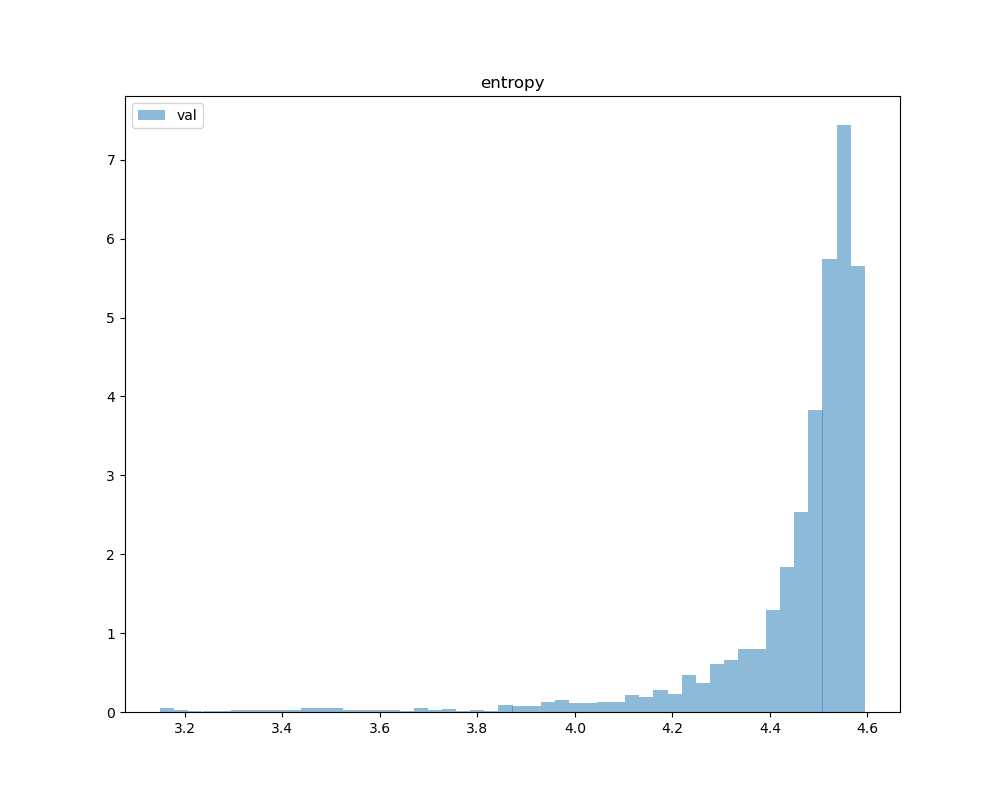

In [73]:
dim = 30
n =150

weights = weights_0

ep = empirical_posterior[(dim, n)]

clv = clustering_labels_val_[(dim, n)]
cla = clustering_labels_attack[(dim, n)]

pv = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=clv, 
                   n_classes=num_classes)

pa = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=cla, 
                   n_classes=num_classes)

entropy_val = H(pv,axis=1)
entropy_attack = H(pa,axis=1)


fig, axs = plt.subplots(1, figsize=(10,8))
axs.hist(entropy_val, bins=50, density=True, alpha=0.5, label='val')
#axs.hist(entropy_attack, bins=30, density=False, alpha=0.5, label='attack')
axs.set_title('entropy')
axs.legend()

entropy_val.shape

In [45]:
for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            # clt = clustering_labels_train[(dim, n)]
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            # pt = predict_proba(weights=weights, 
            #                    empirical_posterior=ep, 
            #                    clustering_labels=clt, 
            #                    n_classes=num_classes)

            # prob_train[(dim, n)] = pt

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
    data = []
    for dim in dims_list:
        for n in num_clusters:

            entropy_val = H(prob_val[(dim, n)],axis=1)
            entropy_attack = H(prob_attack[(dim, n)],axis=1)
            
            original_labels = np.zeros(len(entropy_val))
            attack_labels = np.ones(len(entropy_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([entropy_val, entropy_attack])
            
            auc_ = AUC(y_true=y_true, y_score=y_score)

            data.append((dim, n, auc_))

    if key=='equal': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.73s/it]


In [46]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

In [121]:
dim = 10
n = 15
weights = [1, 0, 0]
ep = empirical_posterior[(dim, n)]
            
clv = clustering_labels_val_[(dim, n)]
cla = clustering_labels_attack[(dim, n)]

pv = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=clv, 
                   n_classes=num_classes)

pa = predict_proba(weights=weights, 
                   empirical_posterior=ep, 
                   clustering_labels=cla, 
                   n_classes=num_classes)

H_val = H(pv,axis=1)
H_attack = H(pa,axis=1)

KeyError: (10, 15)

In [87]:
H_val.mean(), H_attack.mean()

(4.595460822247047, 4.54703116015364)

In [88]:
H_val.std(), H_attack.std()

(0.0078003630903464415, 1.4124406141256994e-05)

In [70]:
H_attack.shape

(10000,)

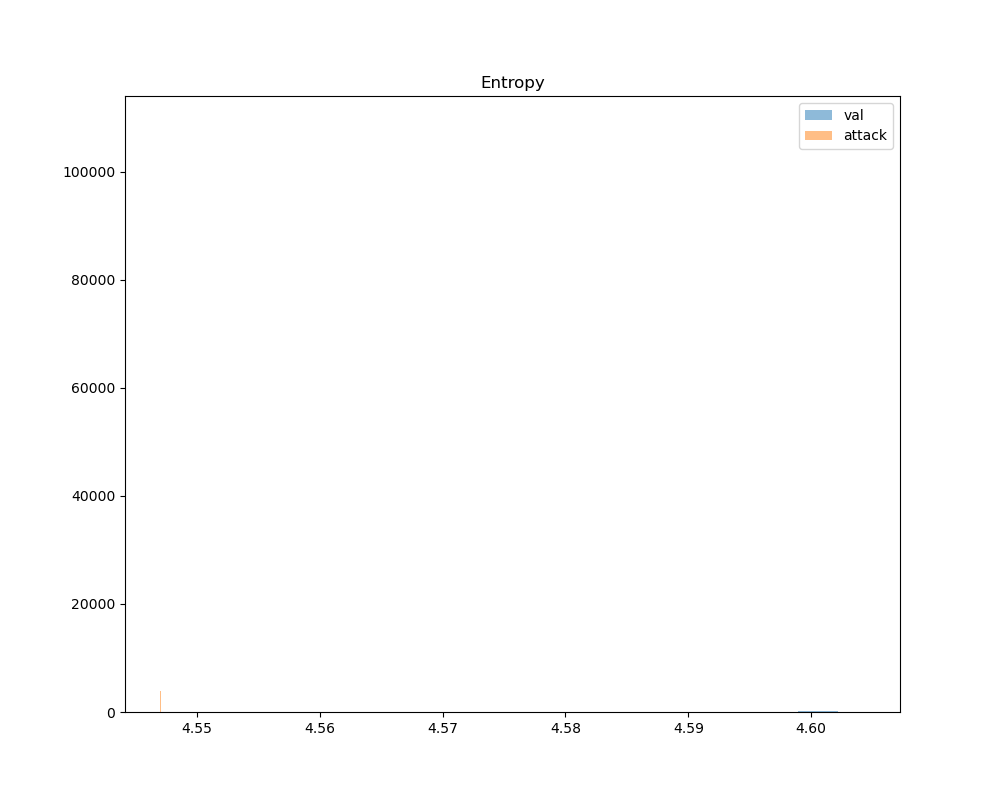

In [89]:
fig, axs = plt.subplots(1,figsize=(10,8))
axs.hist(H_val, bins=50, density=True, alpha=0.5, label='val')
axs.hist(H_attack, bins=100, density=True, alpha=0.5, label='attack')
axs.set_title('Entropy')
axs.legend()

plt.show()

In [59]:
for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            
            clv = clustering_labels_val_[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
    data = []
    for dim in dims_list:
        for n in num_clusters:

            max_val = np.max(prob_val[(dim, n)],axis=1)
            max_attack = np.max(prob_attack[(dim, n)],axis=1)
            
            original_labels = np.zeros(len(entropy_val))
            attack_labels = np.ones(len(entropy_attack))

            y_true = np.concatenate([original_labels, attack_labels])

            y_score = np.concatenate([max_val,max_attack])
            
            auc_ = AUC(y_true=y_true, y_score=y_score, average='macro', multi_class='ovo')

            data.append((dim, n, auc_))

    if key=='equal': # starting building results dataframe
        df = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df.set_index(['dim', 'n_clusters'], inplace=True)
        df.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df = df.join(df_)

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


In [60]:
df.style.background_gradient(subset=df.columns, cmap=cmap, vmin=0.5, vmax=1)

In [51]:
dims_list, num_clusters, dict_SVD.keys()

([10, 15, 20, 25, 30],
 [10, 15, 20, 50, 120, 150],
 dict_keys(['clas-0', 'clas-3', 'feat-28', 'feat-26', 'feat-24']))

In [120]:
# dict_peephole_train = {} 
# dict_peephole_val = {} 
# empirical_posterior = {} 
# distances_prob_train = {}
# distances_prob_val = {}
# clustering_labels_train = {}
# clustering_labels_val = {} 

dict_peephole_attack = {}
distances_prob_attack = {} 
clustering_labels_attack = {} 

for dim in dims_list:
    
    # 1. get peepholes train 
    n_ = 10
    n_clusters_ref = {'feat-24':n_, 'feat-26':n_, 'feat-28':n_, 'clas-0': n_, 'clas-3': n_, }
    # dict_peephole_train_ref = get_dict_peephole_train(dim=dim,
    #                                                   dict_activations_train=dict_activations_train,
    #                                                   n_clusters=n_clusters_ref,
    #                                                   dict_SVD=dict_SVD)
    
    dict_peephole_train_ref = dict_peephole_train[(dim, n_)]
    
    # 2. get peepholes val
    # dict_peephole_val_ref = get_dict_peephole_val(dim=dim, 
    #                                               dict_activations_val=dict_activations_val, 
    #                                               dict_peephole_train=dict_peephole_train_ref,
    #                                               n_clusters=n_clusters_ref,
    #                                               dict_SVD=dict_SVD)
    
    dict_peephole_attack_ref = get_dict_peephole_val(dim=dim, 
                                                     dict_activations_val=dict_activations_attack, 
                                                     dict_peephole_train=dict_peephole_train_ref, # vedere
                                                     n_clusters=n_clusters_ref,
                                                     dict_SVD=dict_SVD)
    
    for n in num_clusters:
        
        n_clusters_ref = {'feat-24':n, 'feat-26':n, 'feat-28':n, 'clas-0': n, 'clas-3': n, }
        
        # 3. get updated peepholes train 
        # dict_peephole_train[(dim, n)] = get_clustering_config(dict_peephole_train=dict_peephole_train_ref,
        #                                                       n_clusters=n_clusters
        #                                                      )

        # 4. get updated peepholes val
        # dict_peephole_val[(dim, n)] = {'peephole': dict_peephole_val_ref['peephole'],
        #                               'clustering_config': dict_peephole_train[(dim, n)]['clustering_config']}
        
        dict_peephole_attack[(dim, n)] = {'peephole': dict_peephole_attack_ref['peephole'],
                                          'clustering_config': dict_peephole_train[(dim, n)]['clustering_config']}
        
        
        # 5. get empirical posteriors
        # empirical_posterior[(dim, n)] = fit_empirical_posteriors(dict_activations_train=dict_activations_train, 
        #                                                          dict_peephole_train=dict_peephole_train[(dim, n)], 
        #                                                          n_classes=num_classes)
        
        # 6. get membership probability for training set
        # distances_prob_train[(dim, n)] = get_distances_prob(dict_peephole_val=None,
        #                                                     dict_peephole_train=dict_peephole_train[(dim, n)],
        #                                                     method=method, 
        #                                                     dim=dim)
        
        # 7. get membership probability for training set
        # distances_prob_val[(dim, n)] = get_distances_prob(dict_peephole_val=dict_peephole_val[(dim, n)],
        #                                                   dict_peephole_train=dict_peephole_train[(dim, n)],
        #                                                   method=method, 
        #                                                   dim=dim)
        
        distances_prob_attack[(dim, n)] = get_distances_prob(dict_peephole_val=dict_peephole_attack[(dim, n)],
                                                             dict_peephole_train=dict_peephole_train[(dim, n)],
                                                             method=method, 
                                                             dim=dim)
        
        # 8. combine clustering labels train
        # clustering_labels_t = []
        # distances_prob = distances_prob_train[(dim, n)]
        # for element in zip(*distances_prob):
        #     ll = element
        #     clustering_labels_t.append(ll)
        # clustering_labels_train[(dim, n)] = clustering_labels_t
            
        # 9. combine clustering labels val
        # clustering_labels_v = []
        # distances_prob = distances_prob_val[(dim, n)]
        # for element in zip(*distances_prob):
        #     ll = element
        #     clustering_labels_v.append(ll)
        # clustering_labels_val[(dim, n)] = clustering_labels_v
        
        clustering_labels_a = []
        distances_prob = distances_prob_attack[(dim, n)]
        for element in zip(*distances_prob):
            ll = element
            clustering_labels_a.append(ll)
        clustering_labels_attack[(dim, n)] = clustering_labels_a
        
    # name = f'dict_peephole_train-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, dict_peephole_train)
    # name = f'dict_peephole_val-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, dict_peephole_val)
    # name = f'empirical_posterior-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, empirical_posterior)
    # name = f'distances_prob_train-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, distances_prob_train)
    # name = f'distances_prob_val-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, distances_prob_val)
    # name = f'clustering_labels_train-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, clustering_labels_train)
    # name = f'clustering_labels_val-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    # save_res(name, clustering_labels_val)
    
    name = f'_dict_peephole_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res(name, dict_peephole_attack)
    name = f'_distances_prob_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res(name, distances_prob_attack)
    name = f'_clustering_labels_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    save_res(name, clustering_labels_attack)

(50, 25089)
(50, 4097)
(50, 25089)
(50, 4097)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(60, 25089)
(60, 4097)
(60, 25089)
(60, 4097)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(70, 25089)
(70, 4097)
(70, 25089)
(70, 4097)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)


In [39]:
dict_peephole_attack_ = []

distances_prob_attack_ = []

clustering_labels_attack_ = []

for dim in dims_list:

    name = f'dict_peephole_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    dict_peephole_attack_.append(load_res(name))

    name = f'distances_prob_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    distances_prob_attack_.append(load_res(name))
    
    name = f'clustering_labels_attack-dim={dim}-method={method}-dataset=CIFAR100.pkl'
    clustering_labels_attack_.append(load_res(name))

In [40]:
dict_peephole_attack = {k: v for d in dict_peephole_attack_ for k, v in d.items()}
distances_prob_attack = {k: v for d in distances_prob_attack_ for k, v in d.items()} 
clustering_labels_attack = {k: v for d in clustering_labels_attack_ for k, v in d.items()}

In [44]:
dict_peephole_attack[(10,10)]['peephole'].keys()

dict_keys(['feat-28', 'clas-0', 'clas-3'])

In [61]:
for key, weights in w_dict.items():
    
    prob_train = {}
    prob_val = {}
    prob_attack = {}

    for dim in tqdm(dims_list):
        for n in num_clusters:

            ep = empirical_posterior[(dim, n)]
            clt = clustering_labels_train[(dim, n)]
            clv = clustering_labels_val[(dim, n)]
            cla = clustering_labels_attack[(dim, n)]

            pt = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clt, 
                               n_classes=num_classes)

            prob_train[(dim, n)] = pt

            pv = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=clv, 
                               n_classes=num_classes)

            prob_val[(dim, n)] = pv

            pa = predict_proba(weights=weights, 
                               empirical_posterior=ep, 
                               clustering_labels=cla, 
                               n_classes=num_classes)

            prob_attack[(dim, n)] = pa
            
    data = []
    data_ = []
    for dim in dims_list:
        for n in num_clusters:
            
            entropy_train = H(prob_train[(dim, n)])
            entropy_val = H(prob_val[(dim, n)])
            entropy_attack = H(prob_attack[(dim, n)])

            threshold = []
            list_val_entropy_ = []
            list_attack_entropy_ = []
            
            array = np.arange(0,100,0.1)
            
            for i in array:
            
                perc = np.percentile(entropy_train, 100-i)
                
                threshold.append(perc)
                idx_val = np.argwhere(entropy_val<perc)[:,0]
                idx_attack = np.argwhere(entropy_attack<perc)[:,0]
                percentage_val = len(idx_val)/len(entropy_val)
                percentage_attack = len(idx_attack)/len(entropy_attack)
                list_val_entropy_.append(percentage_val)
                list_attack_entropy_.append(percentage_attack)

            area_val = np.trapz(list_val_entropy_)
            area_attack = np.trapz(list_attack_entropy_)
            
            # original_labels = np.zeros(len(entropy_val))
            # attack_labels = np.ones(len(entropy_attack))

            # y_true = np.concatenate([original_labels, attack_labels])

            # y_score = np.concatenate([entropy_val, entropy_attack])
            
            # auc_ = AUC(y_true=y_true, y_score=y_score)

            data.append((dim, n, area_attack))
            data_.append((dim, n, area_val))

    if key=='equal': # starting building results dataframe
        df_area_attack = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_area_attack.set_index(['dim', 'n_clusters'], inplace=True)
        df_area_attack.sort_index(inplace=True)
    else: # concatenate with previous results
        df_ = pd.DataFrame(data, columns=['dim', 'n_clusters', key])
        df_.set_index(['dim', 'n_clusters'], inplace=True)
        df_.sort_index(inplace=True)
        df_area_attack = df_area_attack.join(df_)

    if key=='equal': # starting building results dataframe
        df_area_val = pd.DataFrame(data_, columns=['dim', 'n_clusters', key])
        df_area_val.set_index(['dim', 'n_clusters'], inplace=True)
        df_area_val.sort_index(inplace=True)
    else: # concatenate with previous results
        df0_ = pd.DataFrame(data_, columns=['dim', 'n_clusters', key])
        df0_.set_index(['dim', 'n_clusters'], inplace=True)
        df0_.sort_index(inplace=True)
        df_area_val = df_area_val.join(df0_)

100%|█████████████████████████████████████████████| 5/5 [01:21<00:00, 16.44s/it]


In [63]:
df_area_attack.style.background_gradient(subset=df.columns, cmap=cmap, vmin=300, vmax=1000)